In [2]:
import os
import pandas as pd
import numpy as np
import math
from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot
from scipy.stats import shapiro
from scipy.stats import zscore
from scipy.stats import levene
from scipy.stats import boxcox
from scipy.stats import norm
from scipy.stats import probplot
from scipy.stats import friedmanchisquare
from scipy.stats import wilcoxon
from scipy.stats import mannwhitneyu
from scipy.stats import skew
from scipy.stats import kurtosis
from scipy.stats import binomtest
from distfit import distfit
import pingouin as pg

In [3]:
original_data = pd.read_csv('survey_results.csv', index_col=0)
original_df = df = pd.DataFrame(original_data) 
original_df.head()

,group,id,question,answer,time,confidence,correct_answer,correct,zoom_timers,drag_timers,highlight_timers,slower_timers,faster_timers,slider_timers,zoom_interactions,drag_interactions,highlight_interactions,slower_interactions,faster_interactions,slider_interactions
0,B,02f10e19-83e5-48a3-be35-5258e2e89c1a,m_t1_clique_si,3,754,1,3,True,[100],[],"[3400, 429, 8300, 428, 233, 214, 1599, 57199, ...",[],[],[],16,0,162,0,0,0
1,B,02f10e19-83e5-48a3-be35-5258e2e89c1a,nl_t3_single_si,1,86,5,1,True,"[156, 249, 310, 327, 1317, 177, 248, 243, 164,...","[4407, 3694, 3410, 3901, 2870, 701, 3894, 4036]",[],[],[],[],26,8,0,0,0,0
2,B,02f10e19-83e5-48a3-be35-5258e2e89c1a,m_t1_single_tl,3,62,5,3,True,"[156, 151, 203, 318, 162, 159, 158, 277, 1295,...",[],"[315, 381, 516, 279, 915, 551, 284, 277, 367, ...",[],[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",10,0,23,0,0,10
3,B,02f10e19-83e5-48a3-be35-5258e2e89c1a,m_t3_clique_jp,5,605,5,3,False,[],[],"[1947, 263, 396, 9420, 464, 364, 25930, 304, 8...",[],[],[],0,0,100,0,0,0
4,B,02f10e19-83e5-48a3-be35-5258e2e89c1a,m_t1_single_si,2,40,5,2,True,[],[],"[1249, 360, 783, 332, 415, 518, 3727, 481, 114...",[],[],[],0,0,10,0,0,0


In [4]:
wrong_answers = ['0d215911-e63c-46ad-a063-653b709f8253',
'037605fd-b893-4885-b04a-8e9c2bed8a1a',
'1039ad57-5293-4af8-acce-89edd244cc7a',
'86bfd834-db2c-44ee-8300-8f182be02533',
'224c8817-b026-4280-b546-04d6cb5388f7',
'2e4f721a-71de-465c-97c1-4bd8a4c7a5d4',
'ffadb36b-5051-4684-b9cf-ed767a599434',
'f357cda5-2402-4fd5-93ff-d8d6ed2a566d']

In [5]:
# remove id's who answered control questions 2&3 wrong
original_df = original_df[~original_df['id'].isin(wrong_answers)]

In [6]:
#filter control questions out
control_questions = ['control1', 'control2', 'control3']
original_df = original_df[~original_df['question'].isin(control_questions)]


original_df['network_enc'] = original_df['question'].str.split('_').str[0]
original_df['task_type'] = original_df['question'].str.split('_').str[1]
original_df['task_entity'] = original_df['question'].str.split('_').str[2]
original_df['temporal_enc'] = original_df['question'].str.split('_').str[3]
original_df['correct'] = original_df['correct'].apply(str).str.lower()
original_df['time'] = original_df['time'].apply(int)

original_df = original_df.drop(['correct_answer'], axis=1) #'id'
original_df.head()

,group,id,question,answer,time,confidence,correct,zoom_timers,drag_timers,highlight_timers,...,zoom_interactions,drag_interactions,highlight_interactions,slower_interactions,faster_interactions,slider_interactions,network_enc,task_type,task_entity,temporal_enc
0,B,02f10e19-83e5-48a3-be35-5258e2e89c1a,m_t1_clique_si,3,754,1,true,[100],[],"[3400, 429, 8300, 428, 233, 214, 1599, 57199, ...",...,16,0,162,0,0,0,m,t1,clique,si
1,B,02f10e19-83e5-48a3-be35-5258e2e89c1a,nl_t3_single_si,1,86,5,true,"[156, 249, 310, 327, 1317, 177, 248, 243, 164,...","[4407, 3694, 3410, 3901, 2870, 701, 3894, 4036]",[],...,26,8,0,0,0,0,nl,t3,single,si
2,B,02f10e19-83e5-48a3-be35-5258e2e89c1a,m_t1_single_tl,3,62,5,true,"[156, 151, 203, 318, 162, 159, 158, 277, 1295,...",[],"[315, 381, 516, 279, 915, 551, 284, 277, 367, ...",...,10,0,23,0,0,10,m,t1,single,tl
3,B,02f10e19-83e5-48a3-be35-5258e2e89c1a,m_t3_clique_jp,5,605,5,false,[],[],"[1947, 263, 396, 9420, 464, 364, 25930, 304, 8...",...,0,0,100,0,0,0,m,t3,clique,jp
4,B,02f10e19-83e5-48a3-be35-5258e2e89c1a,m_t1_single_si,2,40,5,true,[],[],"[1249, 360, 783, 332, 415, 518, 3727, 481, 114...",...,0,0,10,0,0,0,m,t1,single,si


## Functions

In [7]:
def shapiro_wilk(data):
    stat, p = shapiro(data)
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    # interpret
    alpha = 0.05
    if p > alpha:
        print('Sample looks Gaussian (fail to reject H0)')
    else:
        print('Sample does not look Gaussian (reject H0)')

In [8]:
def levene_test(arr1, arr2, arr3, arr4, center):
    stat, p = levene(arr1, arr2, arr3, arr4, center=center)
    print('Statistics=%.3f, p=%.3f' % (stat, p))

In [9]:
def test_distribution(time_orig, time_trans):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

    prob = probplot(time_orig, dist=norm, plot=ax1)
    prob = probplot(time_trans, dist=norm, plot=ax2)

    ax1.set_title('Original Data')
    ax1.set_ylabel('Time Taken')
    ax2.set_title('Transformed Data, λ = %s' % -0.322);
    ax2.set_ylabel('');

In [10]:
def box_cox(df):
    df_trans, lmbda = boxcox(df)
    return df_trans

In [11]:
def remove_outlier_IQR(df, col, lower, upper):
    Q1=df[col].quantile(lower/100)
    Q3=df[col].quantile(upper/100)
    IQR=Q3-Q1
    
    df_final=df[~((df[col]<(Q1-1.5*IQR)) | (df[col]>(Q3+1.5*IQR)))]
    return df_final

In [12]:
def plot_hist(data):
    pyplot.hist(data, bins="sqrt")

In [13]:
def cleanse(df):
    # step 4: IQR outlier removal
    df_old = df
    df = remove_outlier_IQR(df, 'time_trans', 25, 75)
    test_distribution(df_old['time'], df['time_trans'])
    shapiro_wilk(df['time_trans'])

In [14]:
def transform_data(df):
    df['time_trans'] = box_cox(df['time'])
    test_distribution(df['time'], df['time_trans'])

    shapiro_wilk(df['time_trans'])

In [15]:
def check_dist(df):
    dist = distfit(alpha=0.05, stats='RSS')
    dist.fit_transform(df,verbose=1)
    dist.plot(verbose=1)
    dist.summary

In [16]:
def box_plot(df):
    sns.boxplot(x=df)

In [17]:
def skew_and_kurt(df, col):
    sk = skew(df[col])
    kurt = kurtosis(df[col])
    print('Skew: {0}, Kurtosis: {1}'.format(sk, kurt))
    return sk, kurt

In [18]:
def count_plot(df, col):
    sns.countplot(x=col, data=df)

## H1

In [19]:
# step 1: create data groups (nl vs m)
h1_nl_df = original_df.loc[original_df['network_enc'] == 'nl']
h1_m_df = original_df.loc[original_df['network_enc'] == 'm']

# step 1.1: further subdivide based on task type
# nl vs m for t1
h1_nl_df_t1 = h1_nl_df.loc[h1_nl_df['task_type'] == 't1']
h1_m_df_t1 = h1_m_df.loc[h1_m_df['task_type'] == 't1']

# nl vs m for t2
h1_nl_df_t2 = h1_nl_df.loc[h1_nl_df['task_type'] == 't2']
h1_m_df_t2 = h1_m_df.loc[h1_m_df['task_type'] == 't2']

# nl vs m for t3
h1_nl_df_t3 = h1_nl_df.loc[h1_nl_df['task_type'] == 't3']
h1_m_df_t3 = h1_m_df.loc[h1_m_df['task_type'] == 't3']

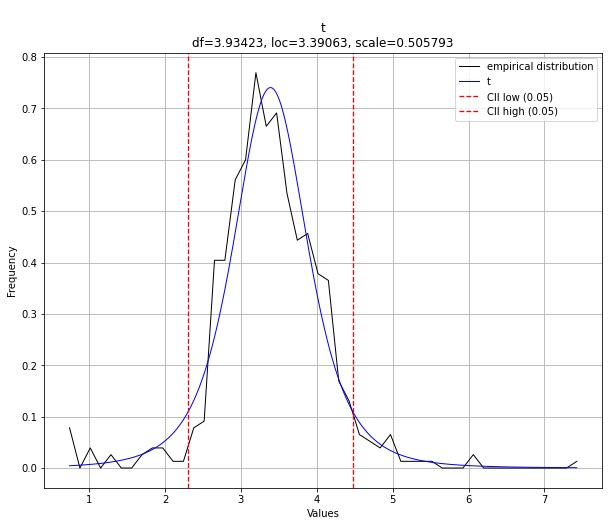

In [20]:
# step 2: check data distribution
check_dist(box_cox(h1_nl_df_t1['time']))

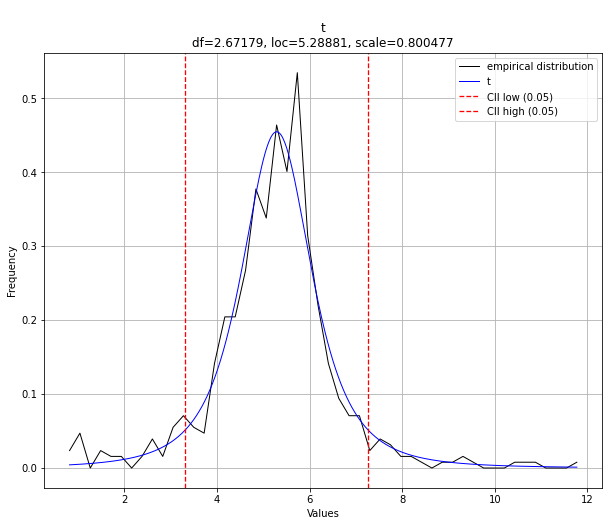

In [21]:
# step 2: check data distribution
check_dist(box_cox(h1_nl_df_t2['time']))

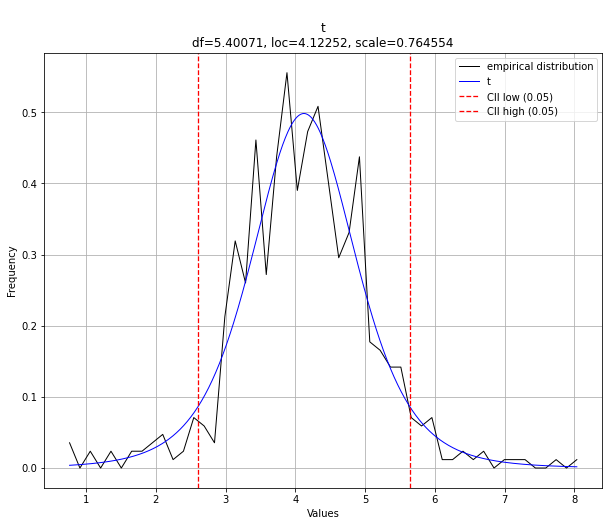

In [22]:
# step 2: check data distribution
check_dist(box_cox(h1_nl_df_t3['time']))

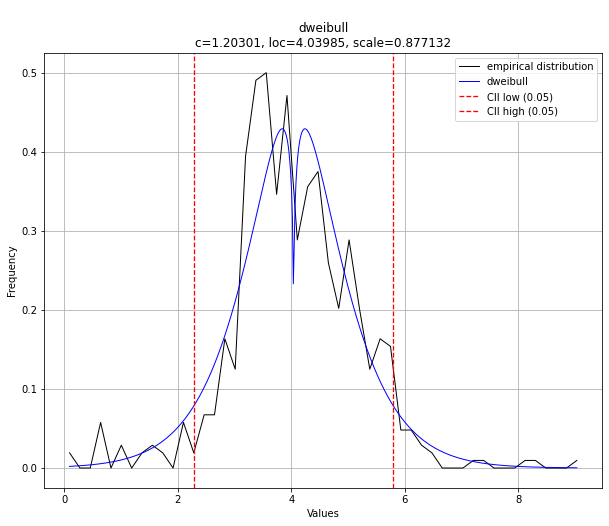

In [23]:
# step 2: check data distribution
check_dist(box_cox(h1_m_df_t1['time']))

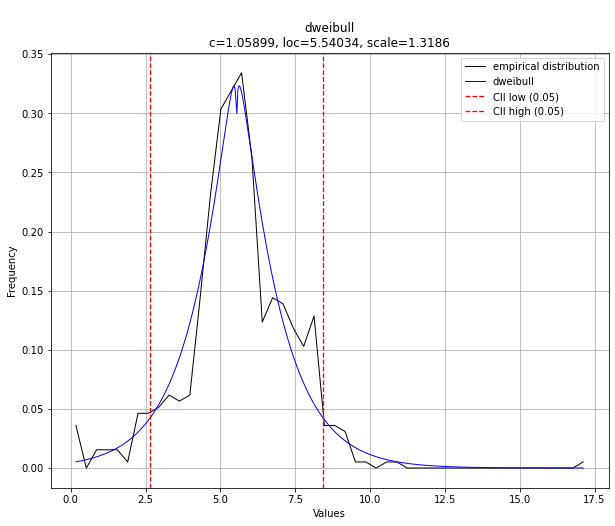

In [24]:
# step 2: check data distribution
check_dist(box_cox(h1_m_df_t2['time']))

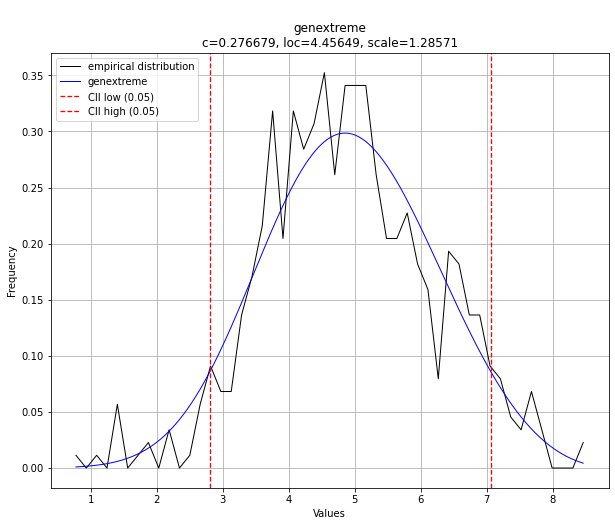

In [25]:
# step 2: check data distribution
check_dist(box_cox(h1_m_df_t3['time']))

Statistics=0.938, p=0.000
Sample does not look Gaussian (reject H0)


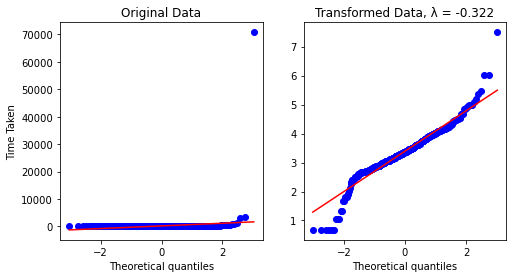

In [26]:
# step 3: transform using box cox and compare before and after
transform_data(h1_nl_df_t1)

Statistics=0.931, p=0.000
Sample does not look Gaussian (reject H0)


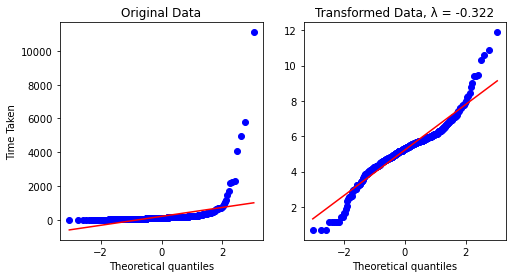

In [27]:
# step 3: transform using box cox and compare before and after
transform_data(h1_nl_df_t2)

Statistics=0.977, p=0.000
Sample does not look Gaussian (reject H0)


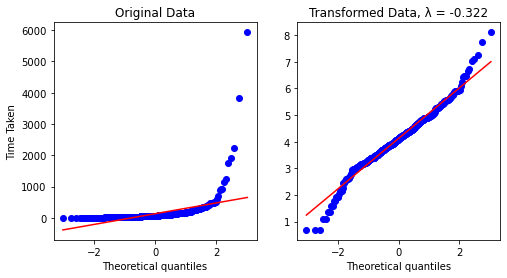

In [28]:
# step 3: transform using box cox and compare before and after
transform_data(h1_nl_df_t3)

Statistics=0.970, p=0.000
Sample does not look Gaussian (reject H0)


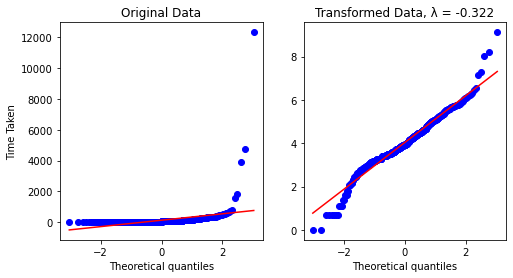

In [29]:
# step 3: transform using box cox and compare before and after
transform_data(h1_m_df_t1)

Statistics=0.957, p=0.000
Sample does not look Gaussian (reject H0)


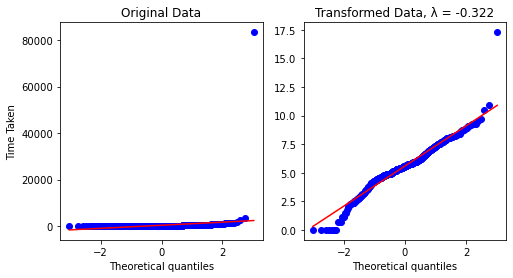

In [30]:
# step 3: transform using box cox and compare before and after
transform_data(h1_m_df_t2)

Statistics=0.994, p=0.020
Sample does not look Gaussian (reject H0)


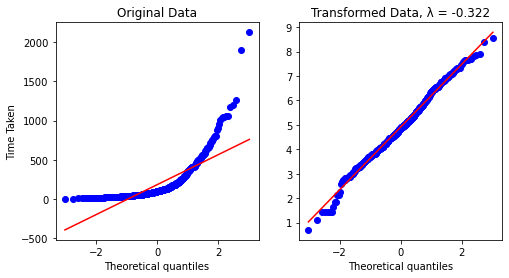

In [31]:
# step 3: transform using box cox and compare before and after
transform_data(h1_m_df_t3)

Statistics=0.991, p=0.002
Sample does not look Gaussian (reject H0)


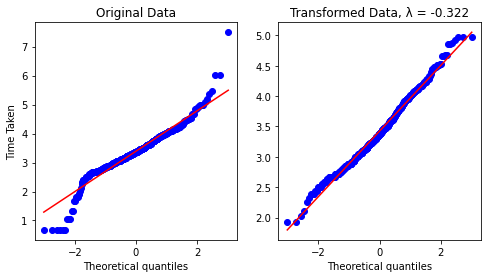

In [32]:
# step 4: IQR outlier removal
h1_nl_df_t1_cleansed = remove_outlier_IQR(h1_nl_df_t1, 'time_trans', 25, 75)
test_distribution(h1_nl_df_t1['time_trans'], h1_nl_df_t1_cleansed['time_trans'])
shapiro_wilk(h1_nl_df_t1_cleansed['time_trans'])

Statistics=0.992, p=0.006
Sample does not look Gaussian (reject H0)


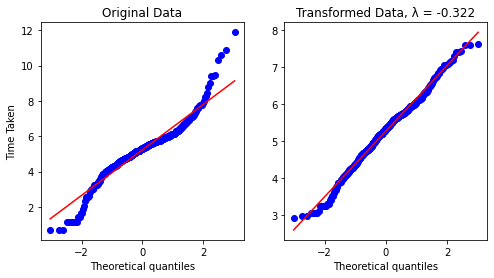

In [33]:
# step 4: IQR outlier removal
h1_nl_df_t2_cleansed = remove_outlier_IQR(h1_nl_df_t2, 'time_trans', 25, 75)
test_distribution(h1_nl_df_t2['time_trans'], h1_nl_df_t2_cleansed['time_trans'])
shapiro_wilk(h1_nl_df_t2_cleansed['time_trans'])

Statistics=0.996, p=0.257
Sample looks Gaussian (fail to reject H0)


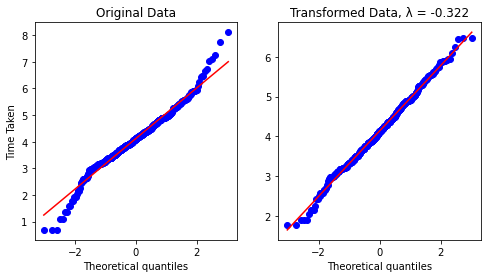

In [34]:
# step 4: IQR outlier removal
h1_nl_df_t3_cleansed = remove_outlier_IQR(h1_nl_df_t3, 'time_trans', 25, 75)
test_distribution(h1_nl_df_t3['time_trans'], h1_nl_df_t3_cleansed['time_trans'])
shapiro_wilk(h1_nl_df_t3_cleansed['time_trans'])

Statistics=0.989, p=0.000
Sample does not look Gaussian (reject H0)


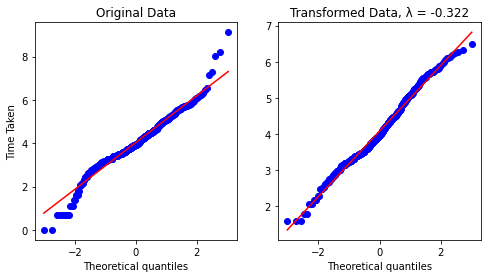

In [35]:
# step 4: IQR outlier removal
h1_m_df_t1_cleansed = remove_outlier_IQR(h1_m_df_t1, 'time_trans', 25, 75)
test_distribution(h1_m_df_t1['time_trans'], h1_m_df_t1_cleansed['time_trans'])
shapiro_wilk(h1_m_df_t1_cleansed['time_trans'])

Statistics=0.988, p=0.000
Sample does not look Gaussian (reject H0)


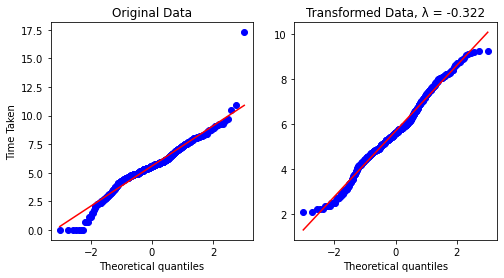

In [36]:
# step 4: IQR outlier removal
h1_m_df_t2_cleansed = remove_outlier_IQR(h1_m_df_t2, 'time_trans', 25, 75)
test_distribution(h1_m_df_t2['time_trans'], h1_m_df_t2_cleansed['time_trans'])
shapiro_wilk(h1_m_df_t2_cleansed['time_trans'])

Statistics=0.991, p=0.002
Sample does not look Gaussian (reject H0)


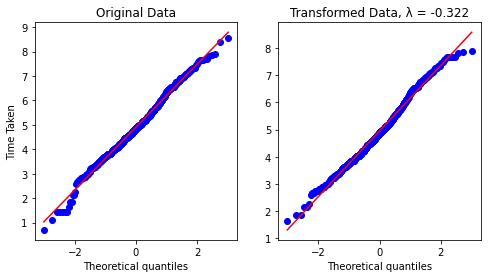

In [37]:
# step 4: IQR outlier removal
h1_m_df_t3_cleansed = remove_outlier_IQR(h1_m_df_t3, 'time_trans', 25, 75)
test_distribution(h1_m_df_t3['time_trans'], h1_m_df_t3_cleansed['time_trans'])
shapiro_wilk(h1_m_df_t3_cleansed['time_trans'])

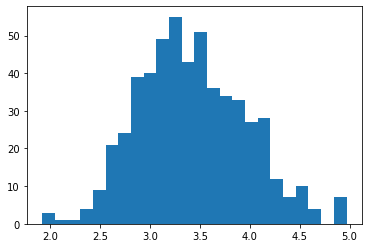

In [38]:
plot_hist(h1_nl_df_t1_cleansed['time_trans'])

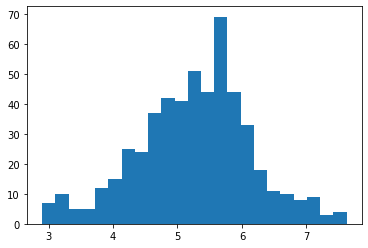

In [39]:
plot_hist(h1_nl_df_t2_cleansed['time_trans'])

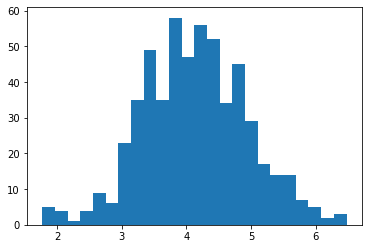

In [40]:
plot_hist(h1_nl_df_t3_cleansed['time_trans'])

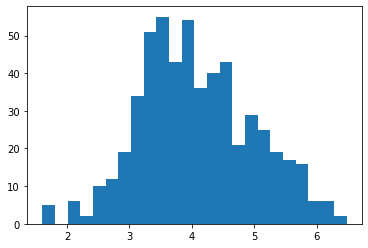

In [41]:
plot_hist(h1_m_df_t1_cleansed['time_trans'])

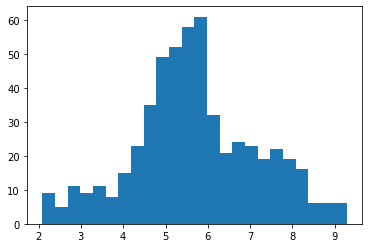

In [42]:
plot_hist(h1_m_df_t2_cleansed['time_trans'])

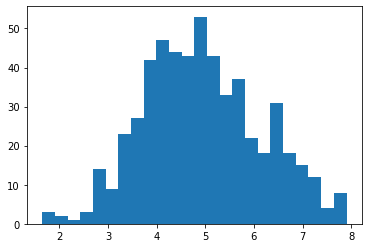

In [43]:
plot_hist(h1_m_df_t3_cleansed['time_trans'])

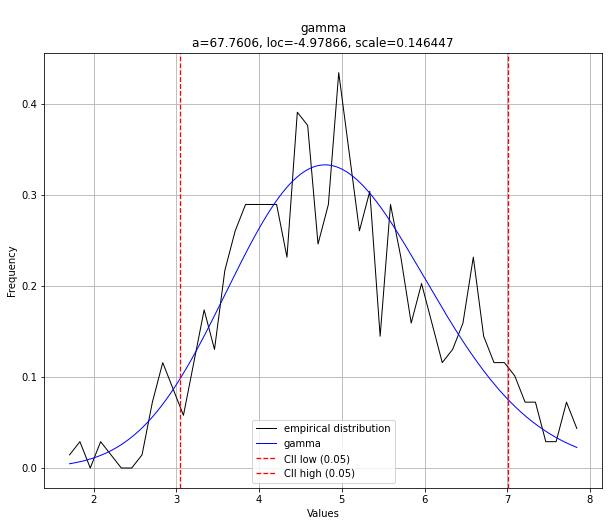

In [44]:
check_dist(h1_m_df_t3_cleansed['time_trans'])

In [45]:
print('NL T1')
skew_and_kurt(h1_nl_df_t1_cleansed, 'time_trans')
print('NL T2')
skew_and_kurt(h1_nl_df_t2_cleansed, 'time_trans')
print('NL T2')
skew_and_kurt(h1_nl_df_t3_cleansed, 'time_trans')
print('M T1')
skew_and_kurt(h1_m_df_t1_cleansed, 'time_trans')
print('M T2')
skew_and_kurt(h1_m_df_t2_cleansed, 'time_trans')
print('M T3')
skew_and_kurt(h1_m_df_t2_cleansed, 'time_trans')

NL T1
Skew: 0.28280103108977, Kurtosis: -0.11438524456072585
NL T2
Skew: -0.1608722564333692, Kurtosis: 0.09407685260650656
NL T2
Skew: 0.03442294228905598, Kurtosis: 0.0569619023830934
M T1
Skew: 0.16867817900011137, Kurtosis: -0.2635657010273915
M T2
Skew: 0.04178687193959833, Kurtosis: -0.11148388707619405
M T3
Skew: 0.04178687193959833, Kurtosis: -0.11148388707619405


(0.04178687193959833, -0.11148388707619405)

Statistics=0.977, p=0.000
Sample does not look Gaussian (reject H0)
Statistics=0.996, p=0.000
Sample does not look Gaussian (reject H0)


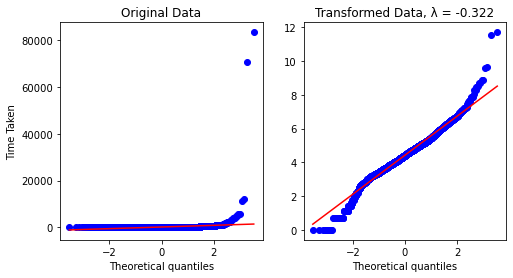

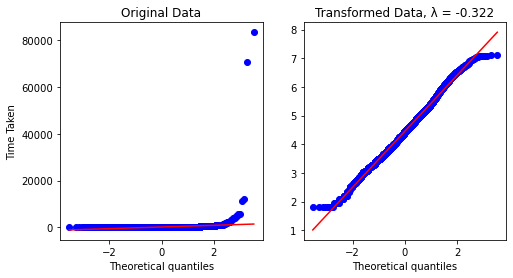

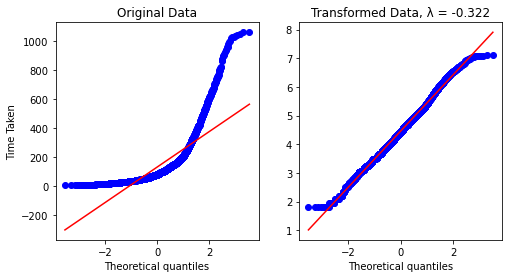

In [46]:
# step 4: IQR outlier removal
transform_data(original_df)
original_df_cleansed = remove_outlier_IQR(original_df, 'time_trans', 25, 75)
test_distribution(original_df['time'], original_df_cleansed['time_trans'])
test_distribution(original_df_cleansed['time'], original_df_cleansed['time_trans'])
shapiro_wilk(original_df_cleansed['time_trans'])

In [47]:
# # check if nl vs m is different
# pg.friedman(data=original_df, dv="time_trans", within=["network_enc", "task_type"], method="chisq")

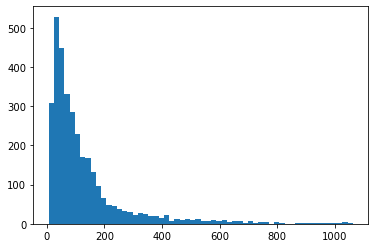

In [48]:
plot_hist(original_df_cleansed['time'])

In [49]:
# check if tasks are different in nl and m
# pg.friedman(data=h1_nl_df, dv="time_trans", within="task_type")

In [50]:
# friedman(data=h1_m_df, dv="time_trans", within="task_type")

In [51]:
# H0: NL[time] === M[time]
# H1: NL[time] !== M[time]
mannwhitneyu(h1_nl_df['time'], h1_m_df['time'], alternative="two-sided") # 0.00000460934 << 0.05 -> reject H0 assume not equal

MannwhitneyuResult(statistic=1309116.0, pvalue=4.609345345004485e-06)

In [52]:
# H0: NL[time] === M[time]
# H1: NL[time] !== M[time]
mannwhitneyu(h1_nl_df['time'], h1_m_df['time'], alternative="less") # 0.00000230467... << 0.05 -> reject H0 assume not equal

MannwhitneyuResult(statistic=1309116.0, pvalue=2.3046726725022424e-06)

In [53]:
mannwhitneyu(h1_nl_df_t1['time'], h1_m_df_t1['time'], alternative="less") # ~0.014-> reject? << 0.05 -> reject H0

MannwhitneyuResult(statistic=146618.5, pvalue=0.006867247155202645)

In [54]:
# H0 NL_T1[time] >= M_T1[time]
# H1.1 NL_T1[time] < M_T1[time]
mannwhitneyu(h1_nl_df_t1['time'], h1_m_df_t1['time'], alternative="less") # 0.006867247155202645 -> reject? 
# -> NL_T1 faster than M_T1

MannwhitneyuResult(statistic=146618.5, pvalue=0.006867247155202645)

In [55]:
# H0 NL_T1[time] >= M_T1[time]
# H1.1 NL_T1[time] < M_T1[time]
mannwhitneyu(h1_nl_df_t2['time'], h1_m_df_t2['time'], alternative="less") # 0.006867247155202645 -> reject? 
# -> M_T2 faster than or equal NL_T2

MannwhitneyuResult(statistic=154540.5, pvalue=0.16509464970518734)

In [56]:
# H0 NL_T1[time] >= M_T1[time]
# H1.1 NL_T1[time] < M_T1[time]
mannwhitneyu(h1_nl_df_t3['time'], h1_m_df_t3['time'], alternative="less") # 0.006867247155202645 -> reject? 
# -> NL_T3 faster than M_T3

MannwhitneyuResult(statistic=133248.5, pvalue=6.178450282400558e-07)

In [57]:
print(h1_nl_df_t1_cleansed['time'].mean(), h1_nl_df_t2_cleansed['time'].mean(), h1_nl_df_t3_cleansed['time'].mean())
print(h1_m_df_t1_cleansed['time'].mean(), h1_m_df_t2_cleansed['time'].mean(), h1_m_df_t3_cleansed['time'].mean())

73.49814126394052 133.41176470588235 107.32129963898917
97.93647912885662 194.20555555555555 175.92753623188406


<AxesSubplot:xlabel='time', ylabel='network_enc'>

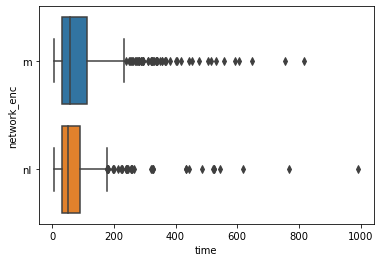

In [58]:
sns.boxplot(x='time', y='network_enc', data=original_df_cleansed[original_df_cleansed['task_type'] == 't1'])

<AxesSubplot:xlabel='correct', ylabel='count'>

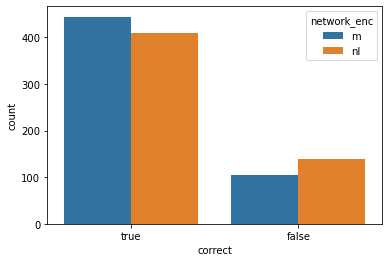

In [59]:
sns.countplot(x="correct", hue="network_enc", data=original_df_cleansed[original_df_cleansed['task_type'] == 't1'])

<AxesSubplot:xlabel='time', ylabel='network_enc'>

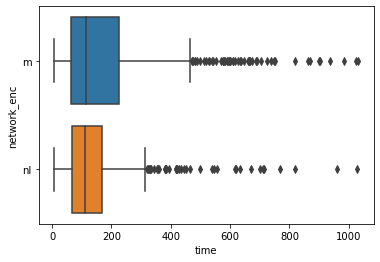

In [60]:
sns.boxplot(x='time', y='network_enc', data=original_df_cleansed[original_df_cleansed['task_type'] == 't2'])

In [61]:
original_df_cleansed[(original_df_cleansed['network_enc'] == 'm') & (original_df_cleansed['task_type'] == 't2')]['time'].mean()

182.56822429906543

In [62]:
original_df_cleansed[(original_df_cleansed['network_enc'] == 'nl') & (original_df_cleansed['task_type'] == 't2')]['time'].mean()

140.88073394495413

<AxesSubplot:xlabel='correct', ylabel='count'>

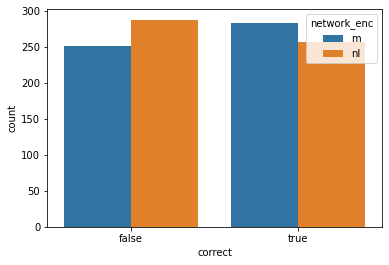

In [63]:
sns.countplot(x="correct", hue="network_enc", data=original_df_cleansed[original_df_cleansed['task_type'] == 't2'])

<AxesSubplot:xlabel='time', ylabel='network_enc'>

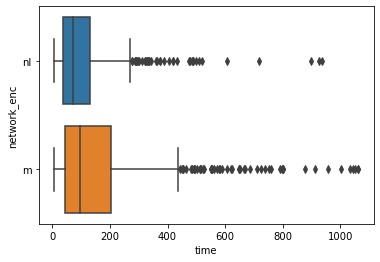

In [64]:
sns.boxplot(x='time', y='network_enc', data=original_df_cleansed[original_df_cleansed['task_type'] == 't3'])

<AxesSubplot:xlabel='correct', ylabel='count'>

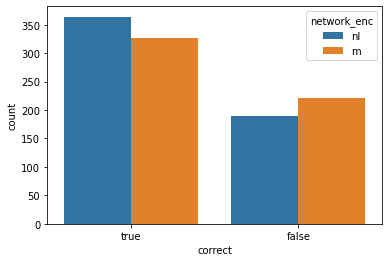

In [65]:
sns.countplot(x="correct", hue="network_enc", data=original_df_cleansed[original_df_cleansed['task_type'] == 't3'])

In [66]:
# H0 NL_T2[time] >= M_T2[time]
# H1.2 NL_T2[time] < M_T2[time]
mannwhitneyu(h1_nl_df_t2_cleansed['time'], h1_m_df_t2_cleansed['time'], alternative="two-sided") # 0.16509464970518734 -> approve?

MannwhitneyuResult(statistic=135213.5, pvalue=0.15971335382911456)

In [67]:
# H0 NL_T3[time] >= M_T3[time]
# H1.3 NL_T3[time] < M_T3[time]
mannwhitneyu(h1_nl_df_t3['time'], h1_m_df_t3['time'], alternative="less") # 6.178450282400558e-07 -> reject?

MannwhitneyuResult(statistic=133248.5, pvalue=6.178450282400558e-07)

In [68]:
h1_df = pd.DataFrame()
h1_df = h1_df.append(h1_nl_df_t1_cleansed)
h1_df = h1_df.append(h1_nl_df_t2_cleansed)
h1_df = h1_df.append(h1_nl_df_t3_cleansed)

h1_df = h1_df.append(h1_m_df_t1_cleansed)
h1_df = h1_df.append(h1_m_df_t2_cleansed)
h1_df = h1_df.append(h1_m_df_t3_cleansed)

h1_df

,group,id,question,answer,time,confidence,correct,zoom_timers,drag_timers,highlight_timers,...,drag_interactions,highlight_interactions,slower_interactions,faster_interactions,slider_interactions,network_enc,task_type,task_entity,temporal_enc,time_trans
7,B,02f10e19-83e5-48a3-be35-5258e2e89c1a,nl_t1_single_si,3,106,5,true,"[1175, 1678]","[3725, 3687, 3773, 3748]",[],...,4,0,0,0,0,nl,t1,single,si,3.919000
8,B,02f10e19-83e5-48a3-be35-5258e2e89c1a,nl_t1_single_an,4,151,5,true,"[2725, 158, 348, 185, 169, 66, 685, 84, 698]","[2152, 814, 919]",[],...,3,0,19,0,0,nl,t1,single,an,4.162896
21,B,02f10e19-83e5-48a3-be35-5258e2e89c1a,nl_t1_single_tl,3,40,5,true,"[154, 218, 160, 84, 418, 289, 5023, 258, 248]","[1501, 3374]",[],...,2,0,0,0,2,nl,t1,single,tl,3.211917
26,B,02f10e19-83e5-48a3-be35-5258e2e89c1a,nl_t1_clique_an,2,138,4,true,"[160, 259, 287, 165, 1435, 199, 442, 224, 263,...","[3410, 1325, 3685, 3222, 3410, 3499, 3749, 326...",[],...,10,0,0,0,0,nl,t1,clique,an,4.101471
32,B,02f10e19-83e5-48a3-be35-5258e2e89c1a,nl_t1_single_jp,2,19,5,true,"[397, 231, 647, 207, 719]",[],[],...,0,0,0,0,0,nl,t1,single,jp,2.634954
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3951,A,fd0eab90-ea5f-48cf-9796-8115762f1f51,m_t3_clique_jp,3,69,3,true,[],[],[],...,0,0,0,0,8,m,t3,clique,jp,4.493430
3952,A,fd0eab90-ea5f-48cf-9796-8115762f1f51,m_t3_clique_an,5,279,2,false,[],[],[],...,0,0,0,0,8,m,t3,clique,an,6.096021
3955,A,fd0eab90-ea5f-48cf-9796-8115762f1f51,m_t3_clique_si,3,175,2,false,[],[],[],...,0,0,0,0,7,m,t3,clique,si,5.554056
3956,A,fd0eab90-ea5f-48cf-9796-8115762f1f51,m_t3_single_tl,4,29,5,true,[],[],[],...,0,0,0,0,3,m,t3,single,tl,3.529974


In [69]:
pg.pairwise_tukey(data=h1_df, dv="time_trans", between="network_enc")

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,m,nl,4.902124,4.266294,0.635829,0.043265,14.696048,1.348810e-12,0.514518


In [70]:
pg.pairwise_tukey(data=h1_df, dv="time_trans", between="task_type")

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,t1,t2,3.755959,5.483672,-1.727713,0.045856,-37.677019,0.0,-1.622383
1,t1,t3,3.755959,4.538880,-0.782921,0.045446,-17.227612,0.0,-0.735195
2,t2,t3,5.483672,4.538880,0.944792,0.045681,20.682331,0.0,0.887196


In [71]:
pg.anova(data=h1_df, dv="time_trans", between=["network_enc","task_type"], detailed=True, effsize="n2")

,Source,SS,DF,MS,F,p-unc,n2
0,network_enc,329.075582,1.0,329.075582,320.343867,2.085438e-68,0.062028
1,task_type,1611.949480,2.0,805.974740,784.588949,7.771341e-279,0.303839
2,network_enc * task_type,19.504086,2.0,9.752043,9.493282,7.746302e-05,0.003676
3,Residual,3344.749828,3256.0,1.027257,NaN,NaN,NaN


In [72]:
pg.kruskal(data=h1_df[h1_df['task_type']=="t1"], dv="time", between="network_enc")

,Source,ddof1,H,p-unc
Kruskal,network_enc,1,6.554343,0.010463


In [73]:
pg.kruskal(data=h1_df[h1_df['task_type']=="t2"], dv="time", between="network_enc")

,Source,ddof1,H,p-unc
Kruskal,network_enc,1,1.977217,0.159684


In [74]:
pg.kruskal(data=h1_df[h1_df['task_type']=="t3"], dv="time", between="network_enc")

,Source,ddof1,H,p-unc
Kruskal,network_enc,1,26.765387,2.297153e-07


In [75]:
pg.pairwise_ttests(data=h1_df, dv="time", within=["task_type", "network_enc"], subject="id", parametric=True, alpha=0.05, alternative="greater", padjust="bonf", correction=True, return_desc=True)

,Contrast,task_type,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,task_type,-,t1,t2,85.284606,30.049786,163.159311,67.050855,True,True,-11.544792,67.0,greater,1.000000e+00,1.000000e+00,bonf,1.193e-15,-1.490460
1,task_type,-,t1,t3,85.284606,30.049786,139.892603,60.517771,True,True,-10.162489,67.0,greater,1.000000e+00,1.000000e+00,bonf,2.44e-13,-1.136554
2,task_type,-,t2,t3,163.159311,67.050855,139.892603,60.517771,True,True,4.577153,67.0,greater,1.049723e-05,3.149170e-05,bonf,1774.915,0.362251
3,network_enc,-,m,nl,155.607227,67.943940,103.283787,32.587114,True,True,8.989559,67.0,greater,1.997599e-13,NaN,NaN,3.99e+10,0.976472
4,task_type * network_enc,t1,m,nl,97.754231,43.004345,72.814980,26.752045,True,True,5.278165,67.0,greater,7.579609e-07,2.273883e-06,bonf,2.071e+04,0.692482
5,task_type * network_enc,t2,m,nl,195.491071,93.280346,130.827550,50.822639,True,True,7.874833,67.0,greater,2.023261e-11,6.069782e-11,bonf,4.672e+08,0.856047
6,task_type * network_enc,t3,m,nl,173.576377,94.363265,106.208829,40.775591,True,True,6.898670,67.0,greater,1.149434e-09,3.448302e-09,bonf,9.752e+06,0.921608


In [76]:
pg.pairwise_ttests(data=h1_df, dv="time", between=["task_type", "network_enc"], parametric=True, alpha=0.05, alternative="greater", padjust="bonf", correction=True, return_desc=True)

,Contrast,task_type,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,task_type,-,t1,t2,85.863177,91.808317,164.179007,172.141878,False,True,-13.142014,1619.712288,greater,1.000000e+00,1.000000e+00,bonf,1.361e-35,-0.569127
1,task_type,-,t1,t3,85.863177,91.808317,141.562387,172.723875,False,True,-9.453564,1688.885182,greater,1.000000e+00,1.000000e+00,bonf,1.284e-18,-0.401689
2,task_type,-,t2,t3,164.179007,172.141878,141.562387,172.723875,False,True,3.056681,2168.703305,greater,1.132663e-03,3.397988e-03,bonf,9.898,0.131112
3,network_enc,-,m,nl,155.779671,189.524330,104.574429,99.822481,False,True,9.673968,2495.916518,greater,4.662242e-22,NaN,NaN,7.073e+18,0.337285
4,task_type * network_enc,t1,m,nl,97.936479,106.585013,73.498141,71.687877,False,True,4.449218,965.444064,greater,4.810588e-06,1.443176e-05,bonf,2185.133,0.268271
5,task_type * network_enc,t2,m,nl,194.205556,217.807911,133.411765,97.814013,False,True,5.904615,751.885250,greater,2.675042e-09,8.025127e-09,bonf,3.13e+06,0.358383
6,task_type * network_enc,t3,m,nl,175.927536,209.987853,107.321300,115.430939,False,True,6.729558,855.472671,greater,1.557497e-11,4.672492e-11,bonf,4.527e+08,0.404824


In [77]:
pg.ttest(h1_df[h1_df['network_enc']=='m']['time_trans'], h1_df[h1_df['network_enc']=='nl']['time_trans'], alternative="greater", correction=True, confidence=0.95)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,14.722633,3094.460541,greater,8.973885e-48,"[0.56, inf]",0.514636,1.978e+44,1.0


true     0.807623
false    0.192377
Name: correct, dtype: float64


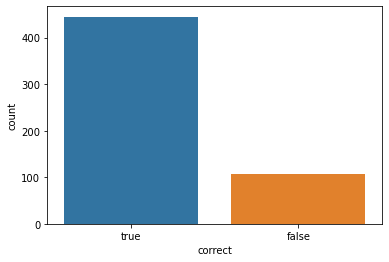

In [78]:
count_plot(h1_df[(h1_df['network_enc']=='m') & (h1_df['task_type']=="t1")], 'correct')

# check percentage of correct
print(h1_df[(h1_df['network_enc']=='m') & (h1_df['task_type']=="t1")]['correct'].value_counts()/len(h1_df[(h1_df['network_enc']=='m') & (h1_df['task_type']=="t1")]))

true     0.65704
false    0.34296
Name: correct, dtype: float64


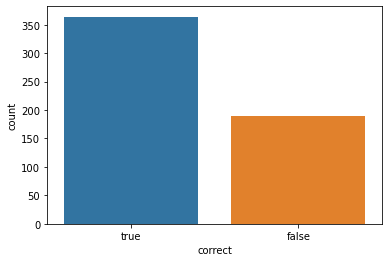

In [79]:
count_plot(h1_df[(h1_df['network_enc']=='nl') & (h1_df['task_type']=="t3")], 'correct')

# check percentage of correct
print(h1_df[(h1_df['network_enc']=='nl') & (h1_df['task_type']=="t3")]['correct'].value_counts()/len(h1_df[(h1_df['network_enc']=='nl') & (h1_df['task_type']=="t3")]))

In [80]:
success_m, fail_m = h1_df[(h1_df['network_enc']=='m')]['correct'].value_counts()
success_nl, fail_nl = h1_df[(h1_df['network_enc']=='nl')]['correct'].value_counts()
num_trial_m = len(h1_df[(h1_df['network_enc']=='m')])
num_trial_nl = len(h1_df[(h1_df['network_enc']=='nl')])
success_prob_nl, fail_prob_nl = h1_df[(h1_df['network_enc']=='nl')]['correct'].value_counts()/len(h1_df[(h1_df['network_enc']=='nl')])
success_prob_m, fail_prob_m = h1_df[(h1_df['network_enc']=='m')]['correct'].value_counts()/len(h1_df[(h1_df['network_enc']=='m')])

binomtest(success_m, num_trial_m, p=success_prob_nl, alternative="two-sided")

BinomTestResult(k=1058, n=1643, alternative='two-sided', proportion_estimate=0.6439440048691418, pvalue=0.19300663251801303)

In [81]:
task_type = 't3'
success_m, fail_m = h1_df[(h1_df['network_enc']=='m') & (h1_df['task_type']==task_type)]['correct'].value_counts()
success_nl, fail_nl = h1_df[(h1_df['network_enc']=='nl') & (h1_df['task_type']==task_type)]['correct'].value_counts()
num_trial_m = len(h1_df[(h1_df['network_enc']=='m') & (h1_df['task_type']==task_type)])
num_trial_nl = len(h1_df[(h1_df['network_enc']=='nl') & (h1_df['task_type']==task_type)])
success_prob_nl, fail_prob_nl = h1_df[(h1_df['network_enc']=='nl') & (h1_df['task_type']==task_type)]['correct'].value_counts()/len(h1_df[(h1_df['network_enc']=='nl') & (h1_df['task_type']==task_type)])
success_prob_m, fail_prob_m = h1_df[(h1_df['network_enc']=='m') & (h1_df['task_type']==task_type)]['correct'].value_counts()/len(h1_df[(h1_df['network_enc']=='m') & (h1_df['task_type']==task_type)])

binomtest(success_m, num_trial_m, p=success_prob_nl, alternative="less")

BinomTestResult(k=328, n=552, alternative='less', proportion_estimate=0.5942028985507246, pvalue=0.0012194423379743385)

true     0.65704
false    0.34296
Name: correct, dtype: float64


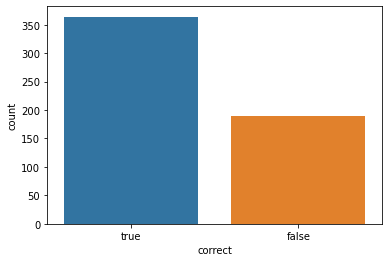

In [82]:
count_plot(h1_df[(h1_df['network_enc']=='nl') & (h1_df['task_type']==task_type)], 'correct')
print(h1_df[(h1_df['network_enc']=='nl') & (h1_df['task_type']==task_type)]['correct'].value_counts()/len(h1_df[(h1_df['network_enc']=='nl') & (h1_df['task_type']==task_type)]))

true     0.594203
false    0.405797
Name: correct, dtype: float64


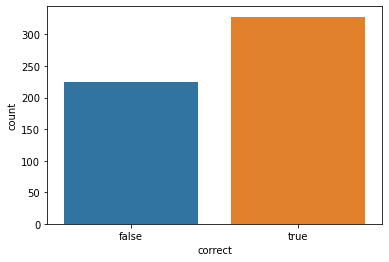

In [83]:
count_plot(h1_df[(h1_df['network_enc']=='m') & (h1_df['task_type']==task_type)], 'correct')
print(h1_df[(h1_df['network_enc']=='m') & (h1_df['task_type']==task_type)]['correct'].value_counts()/len(h1_df[(h1_df['network_enc']=='m') & (h1_df['task_type']==task_type)]))

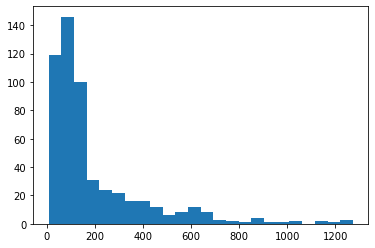

In [84]:
plot_hist(h1_df[(h1_df['network_enc']=='m') & (h1_df['task_type']=='t2')]['time'])

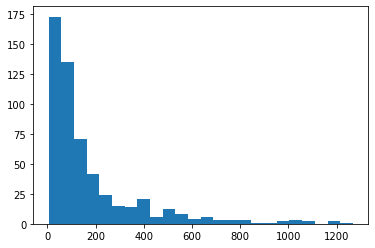

In [85]:
plot_hist(h1_df[(h1_df['network_enc']=='m') & (h1_df['task_type']=='t3')]['time'])

In [86]:
print(h1_df[(h1_df['network_enc']=='m') & (h1_df['task_type']=='t1')]['time_trans'].mean(),
h1_df[(h1_df['network_enc']=='m') & (h1_df['task_type']=='t2')]['time_trans'].mean(),
h1_df[(h1_df['network_enc']=='m') & (h1_df['task_type']=='t3')]['time_trans'].mean())

4.080011134108357 5.697457793041901 4.944702571908319


In [87]:
print(h1_df[(h1_df['network_enc']=='nl') & (h1_df['task_type']=='t1')]['time_trans'].mean(),
h1_df[(h1_df['network_enc']=='nl') & (h1_df['task_type']=='t2')]['time_trans'].mean(),
h1_df[(h1_df['network_enc']=='nl') & (h1_df['task_type']=='t3')]['time_trans'].mean())

3.4240774642212384 5.264613450281624 4.134522434245693


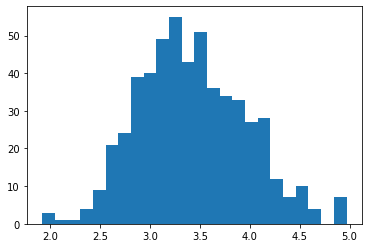

In [88]:
plot_hist(h1_df[(h1_df['network_enc']=='nl') & (h1_df['task_type']=='t1')]['time_trans'])

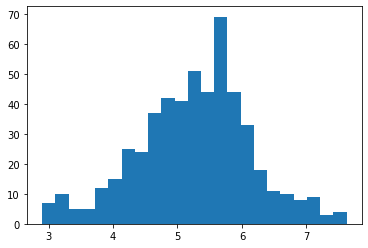

In [89]:
plot_hist(h1_df[(h1_df['network_enc']=='nl') & (h1_df['task_type']=='t2')]['time_trans'])

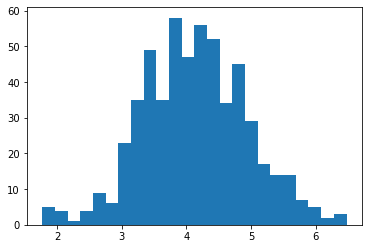

In [90]:
plot_hist(h1_df[(h1_df['network_enc']=='nl') & (h1_df['task_type']=='t3')]['time_trans'])

In [91]:
h1_df[(h1_df['network_enc']=='m') & (h1_df['group']=='B')]['time_trans'].mean()

4.936188059507523

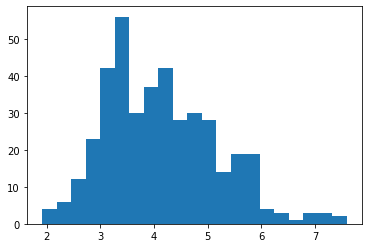

In [92]:
plot_hist(h1_df[(h1_df['network_enc']=='nl') & (h1_df['group']=='A')]['time_trans'])

In [93]:
h1_df[(h1_df['network_enc']=='nl') & (h1_df['group']=='A')]['time_trans'].mean()

4.143076028303441

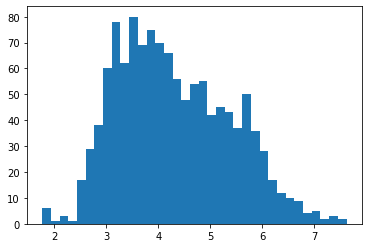

In [94]:
plot_hist(h1_df[(h1_df['network_enc']=='nl') & (h1_df['group']=='B')]['time_trans'])

In [95]:
h1_df[(h1_df['network_enc']=='nl') & (h1_df['group']=='B')]['time_trans'].mean()

4.307536294419091

## H2

In [96]:
# step 1: create data groups (si vs jp vs tl vs an)
h2_si_df = original_df.loc[original_df['temporal_enc'] == 'si']
h2_jp_df = original_df.loc[original_df['temporal_enc'] == 'jp']
h2_tl_df = original_df.loc[original_df['temporal_enc'] == 'tl']
h2_an_df = original_df.loc[original_df['temporal_enc'] == 'an']

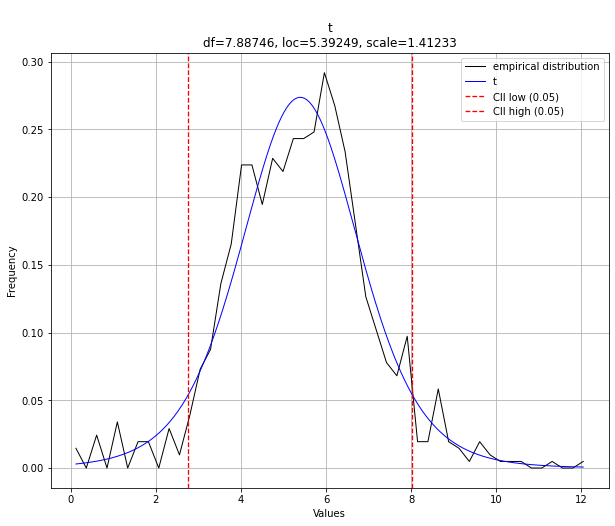

In [97]:
# step 2: check data distribution
check_dist(box_cox(h2_si_df['time']))

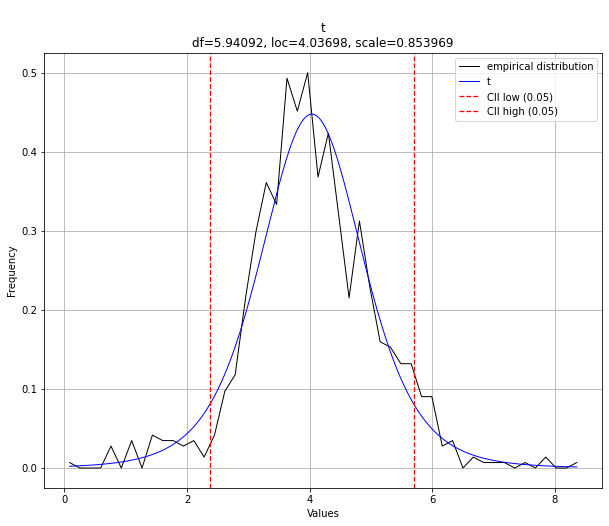

In [98]:
# step 2: check data distribution
check_dist(box_cox(h2_jp_df['time']))

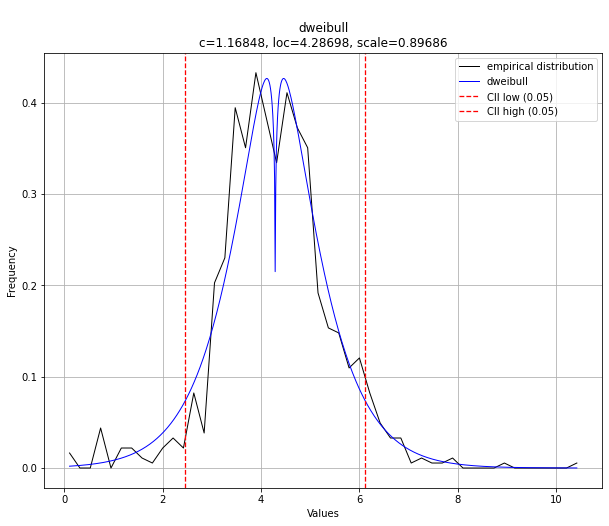

In [99]:
# step 2: check data distribution
check_dist(box_cox(h2_tl_df['time']))

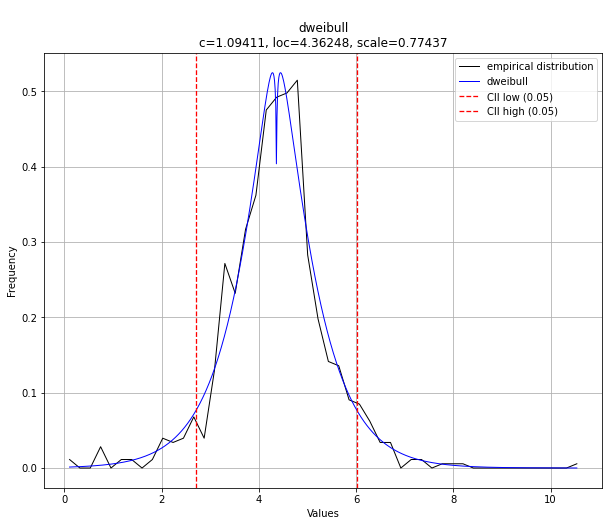

In [100]:
# step 2: check data distribution
check_dist(box_cox(h2_an_df['time']))

Statistics=0.989, p=0.000
Sample does not look Gaussian (reject H0)


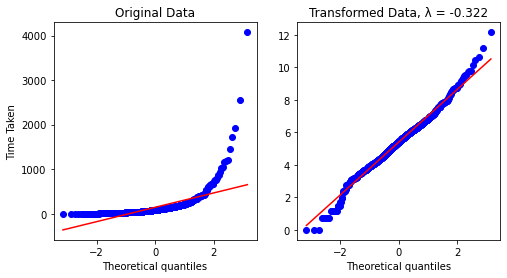

In [101]:
# step 3: transform using box cox and compare before and after
transform_data(h2_si_df)

Statistics=0.982, p=0.000
Sample does not look Gaussian (reject H0)


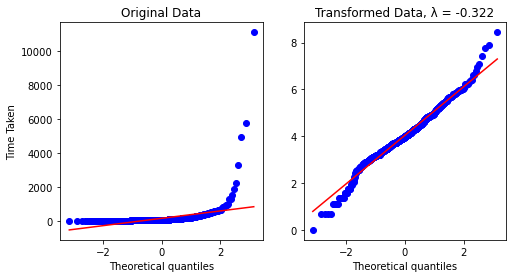

In [102]:
# step 3: transform using box cox and compare before and after
transform_data(h2_jp_df)

Statistics=0.971, p=0.000
Sample does not look Gaussian (reject H0)


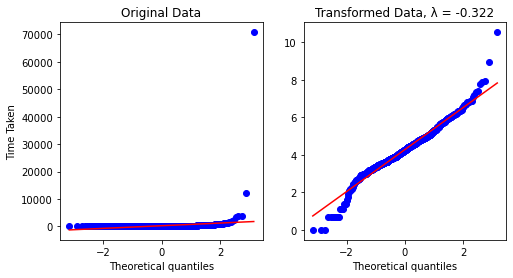

In [103]:
# step 3: transform using box cox and compare before and after
transform_data(h2_tl_df)

Statistics=0.962, p=0.000
Sample does not look Gaussian (reject H0)


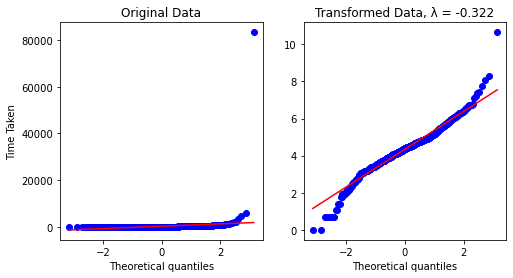

In [104]:
# step 3: transform using box cox and compare before and after
transform_data(h2_an_df)

Statistics=0.996, p=0.060
Sample looks Gaussian (fail to reject H0)


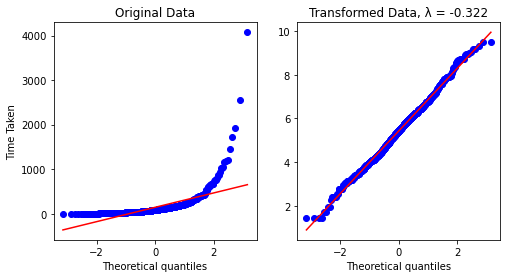

In [105]:
# step 4: IQR outlier removal
h2_si_df_cleansed = remove_outlier_IQR(h2_si_df, 'time_trans', 25, 75)
test_distribution(h2_si_df['time'], h2_si_df_cleansed['time_trans'])
shapiro_wilk(h2_si_df_cleansed['time_trans'])

Statistics=0.992, p=0.000
Sample does not look Gaussian (reject H0)


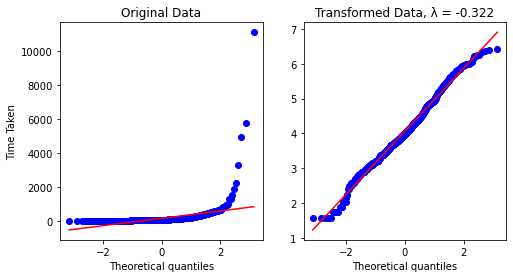

In [106]:
# step 4: IQR outlier removal
h2_jp_df_cleansed = remove_outlier_IQR(h2_jp_df, 'time_trans', 25, 75)
test_distribution(h2_jp_df['time'], h2_jp_df_cleansed['time_trans'])
shapiro_wilk(h2_jp_df_cleansed['time_trans'])

Statistics=0.992, p=0.000
Sample does not look Gaussian (reject H0)


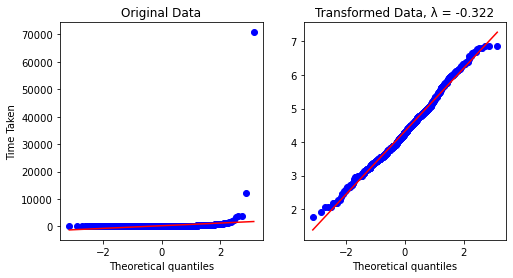

In [107]:
# step 4: IQR outlier removal
h2_tl_df_cleansed = remove_outlier_IQR(h2_tl_df, 'time_trans', 25, 75)
test_distribution(h2_tl_df['time'], h2_tl_df_cleansed['time_trans'])
shapiro_wilk(h2_tl_df_cleansed['time_trans'])

Statistics=0.995, p=0.011
Sample does not look Gaussian (reject H0)


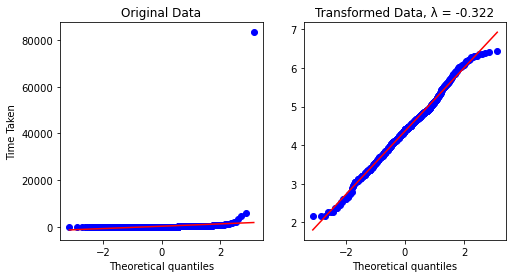

In [108]:
# step 4: IQR outlier removal
h2_an_df_cleansed = remove_outlier_IQR(h2_an_df, 'time_trans', 25, 75)
test_distribution(h2_an_df['time'], h2_an_df_cleansed['time_trans'])
shapiro_wilk(h2_an_df_cleansed['time_trans'])

In [348]:
h2_df = pd.DataFrame()
h2_df = h2_df.append(h2_si_df_cleansed)
h2_df = h2_df.append(h2_jp_df_cleansed)
h2_df = h2_df.append(h2_tl_df_cleansed)
h2_df = h2_df.append(h2_an_df_cleansed)

h2_df

,group,id,question,answer,time,confidence,correct,zoom_timers,drag_timers,highlight_timers,...,drag_interactions,highlight_interactions,slower_interactions,faster_interactions,slider_interactions,network_enc,task_type,task_entity,temporal_enc,time_trans
0,B,02f10e19-83e5-48a3-be35-5258e2e89c1a,m_t1_clique_si,3,754,1,true,[100],[],"[3400, 429, 8300, 428, 233, 214, 1599, 57199, ...",...,0,162,0,0,0,m,t1,clique,si,8.943646
1,B,02f10e19-83e5-48a3-be35-5258e2e89c1a,nl_t3_single_si,1,86,5,true,"[156, 249, 310, 327, 1317, 177, 248, 243, 164,...","[4407, 3694, 3410, 3901, 2870, 701, 3894, 4036]",[],...,8,0,0,0,0,nl,t3,single,si,5.433607
4,B,02f10e19-83e5-48a3-be35-5258e2e89c1a,m_t1_single_si,2,40,5,true,[],[],"[1249, 360, 783, 332, 415, 518, 3727, 481, 114...",...,0,10,0,0,0,m,t1,single,si,4.344969
7,B,02f10e19-83e5-48a3-be35-5258e2e89c1a,nl_t1_single_si,3,106,5,true,"[1175, 1678]","[3725, 3687, 3773, 3748]",[],...,4,0,0,0,0,nl,t1,single,si,5.743717
12,B,02f10e19-83e5-48a3-be35-5258e2e89c1a,m_t2_single_si,4,118,4,false,"[159, 153, 161, 393, 150, 159, 1020, 179]",[],"[364, 300, 230, 233, 261, 365, 227, 698, 200, ...",...,0,30,0,0,0,m,t2,single,si,5.904964
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3958,A,fd0eab90-ea5f-48cf-9796-8115762f1f51,nl_t3_single_an,2,26,4,true,[],[],[],...,0,0,0,0,3,nl,t3,single,an,3.199790
3959,A,fd0eab90-ea5f-48cf-9796-8115762f1f51,nl_t3_single_an,2,374,4,true,[],[],[],...,0,0,0,0,3,nl,t3,single,an,5.733358
3961,A,fd0eab90-ea5f-48cf-9796-8115762f1f51,nl_t2_clique_an,5,125,2,false,[],[],[],...,0,0,0,0,3,nl,t2,clique,an,4.701001
3965,A,fd0eab90-ea5f-48cf-9796-8115762f1f51,nl_t1_single_an,4,202,5,true,[],[],[],...,0,0,0,0,23,nl,t1,single,an,5.154657


In [110]:
pg.pairwise_tukey(data=h2_df, dv="time", between="temporal_enc")

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,an,jp,127.760404,118.322854,9.437550,7.446890,1.267314,0.583890,0.062958
1,an,si,127.760404,129.690621,-1.930218,7.460199,-0.258735,0.993931,-0.012876
2,an,tl,127.760404,141.350060,-13.589656,7.425082,-1.830236,0.259228,-0.090657
3,jp,si,118.322854,129.690621,-11.367768,7.381780,-1.539977,0.413629,-0.075835
4,jp,tl,118.322854,141.350060,-23.027206,7.346288,-3.134536,0.009403,-0.153617
5,si,tl,129.690621,141.350060,-11.659439,7.359779,-1.584210,0.387771,-0.077781


In [111]:
mannwhitneyu(x=h2_df[h2_df['temporal_enc']=="si"]['time'], y=h2_df[h2_df['temporal_enc']=="jp"]['time'], alternative="greater")

MannwhitneyuResult(statistic=372543.0, pvalue=0.0003101354213128871)

In [112]:
mannwhitneyu(x=h2_df[h2_df['temporal_enc']=="tl"]['time'], y=h2_df[h2_df['temporal_enc']=="jp"]['time'], alternative="two-sided")

MannwhitneyuResult(statistic=378576.5, pvalue=0.0009198359960173086)

In [113]:
mannwhitneyu(x=h2_df[h2_df['temporal_enc']=="si"]['time'], y=h2_df[h2_df['temporal_enc']=="an"]['time'], alternative="two-sided")

MannwhitneyuResult(statistic=315343.0, pvalue=0.2766497832363817)

In [114]:
mannwhitneyu(x=h2_df[h2_df['temporal_enc']=="si"]['time'], y=h2_df[h2_df['temporal_enc']=="tl"]['time'], alternative="two-sided")

MannwhitneyuResult(statistic=345230.5, pvalue=0.8662564273543666)

In [115]:
pg.anova(data=h2_df, dv="time", between=["temporal_enc","network_enc"], detailed=True, effsize="n2") # 0.02 < 0.05  0.35

,Source,SS,DF,MS,F,p-unc,n2
0,temporal_enc,2.133539e+05,3.0,7.111797e+04,3.226312,2.162826e-02,0.002894
1,network_enc,1.347225e+06,1.0,1.347225e+06,61.117713,7.194003e-15,0.018276
2,temporal_enc * network_enc,7.262225e+04,3.0,2.420742e+04,1.098185,3.485623e-01,0.000985
3,Residual,7.208099e+07,3270.0,2.204312e+04,NaN,NaN,NaN


In [116]:
pg.kruskal(data=h2_df, dv="time", between="temporal_enc")

,Source,ddof1,H,p-unc
Kruskal,temporal_enc,3,25.932969,0.00001


<AxesSubplot:xlabel='time', ylabel='temporal_enc'>

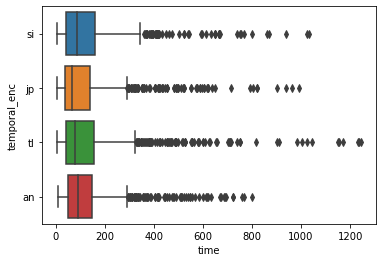

In [117]:
sns.boxplot(x='time', y='temporal_enc', data=h2_df)

In [118]:
h2_df[h2_df['temporal_enc'] == 'si']['time'].mean()

129.69062119366626

In [119]:
h2_df[h2_df['temporal_enc'] == 'jp']['time'].mean()

118.32285368802901

In [120]:
h2_df[h2_df['temporal_enc'] == 'tl']['time'].mean()

141.3500597371565

In [121]:
h2_df[h2_df['temporal_enc'] == 'an']['time'].mean()

127.76040353089533

<AxesSubplot:xlabel='correct', ylabel='count'>

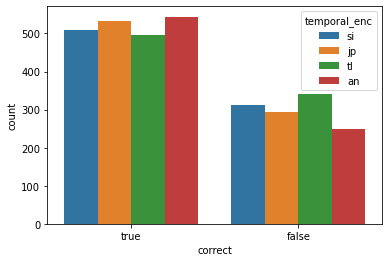

In [122]:
sns.countplot(x="correct", hue="temporal_enc", data=h2_df)

In [123]:
pg.pairwise_ttests(data=h2_df, dv="time", within="temporal_enc", subject="id", parametric=True, alpha=0.05, alternative="two-sided", padjust="bonf", correction=True, return_desc=True)

,Contrast,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,temporal_enc,an,jp,127.066606,48.178445,117.791490,57.755876,True,True,1.452221,67.0,two-sided,0.151107,0.906643,bonf,0.362,0.173421
1,temporal_enc,an,si,127.066606,48.178445,129.842945,55.075053,True,True,-0.445082,67.0,two-sided,0.657695,1.000000,bonf,0.146,-0.053357
2,temporal_enc,an,tl,127.066606,48.178445,139.697147,65.058658,True,True,-1.940368,67.0,two-sided,0.056545,0.339269,bonf,0.777,-0.219406
3,temporal_enc,jp,si,117.791490,57.755876,129.842945,55.075053,True,True,-1.819072,67.0,two-sided,0.073369,0.440216,bonf,0.631,-0.212362
4,temporal_enc,jp,tl,117.791490,57.755876,139.697147,65.058658,True,True,-3.321960,67.0,two-sided,0.001450,0.008703,bonf,18.363,-0.354102
5,temporal_enc,si,tl,129.842945,55.075053,139.697147,65.058658,True,True,-1.801468,67.0,two-sided,0.076129,0.456772,bonf,0.613,-0.162574


In [124]:
pg.ttest(h2_df[h2_df['temporal_enc']=='si']['time'], h2_df[h2_df['temporal_enc']=='jp']['time'], alternative="two-sided")
# new alpha 0.01666666666

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,1.614961,1645.998981,two-sided,0.106511,"[-2.44, 25.17]",0.079562,0.201,0.36485


In [125]:
pg.ttest(h2_df[h2_df['temporal_enc']=='si']['time'], h2_df[h2_df['temporal_enc']=='an']['time'], alternative="two-sided", correction=False, confidence=0.95)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.285742,1612,two-sided,0.775113,"[-11.32, 15.18]",0.014227,0.058,0.059394


In [126]:
pg.ttest(h2_df[h2_df['temporal_enc']=='si']['time'], h2_df[h2_df['temporal_enc']=='tl']['time'], alternative="two-sided", correction=False, confidence=0.95)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-1.465643,1656,two-sided,0.142936,"[-27.26, 3.94]",0.071992,0.16,0.310547


true     0.621194
false    0.378806
Name: correct, dtype: float64


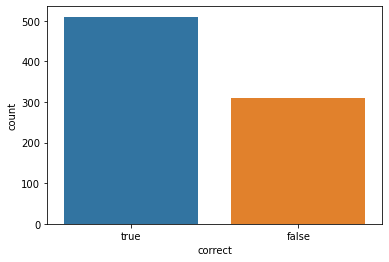

In [127]:
count_plot(h2_df[(h2_df['temporal_enc']=='si')], 'correct')

# check percentage of correct
print(h2_df[(h2_df['temporal_enc']=='si')]['correct'].value_counts()/len(h2_df[(h2_df['temporal_enc']=='si')]))

true     0.644498
false    0.355502
Name: correct, dtype: float64


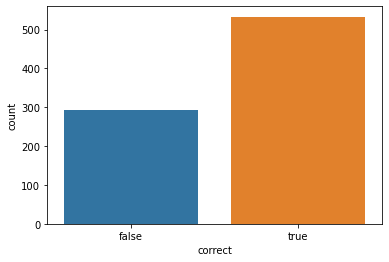

In [128]:
count_plot(h2_df[(h2_df['temporal_enc']=='jp')], 'correct')

# check percentage of correct
print(h2_df[(h2_df['temporal_enc']=='jp')]['correct'].value_counts()/len(h2_df[(h2_df['temporal_enc']=='jp')]))

true     0.686003
false    0.313997
Name: correct, dtype: float64


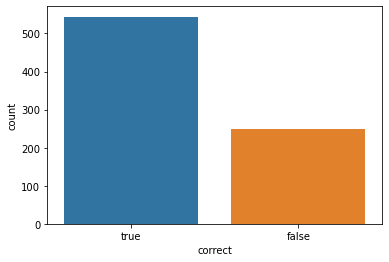

In [129]:
count_plot(h2_df[(h2_df['temporal_enc']=='an')], 'correct')

# check percentage of correct
print(h2_df[(h2_df['temporal_enc']=='an')]['correct'].value_counts()/len(h2_df[(h2_df['temporal_enc']=='an')]))

true     0.591398
false    0.408602
Name: correct, dtype: float64


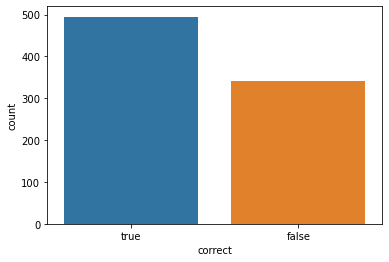

In [130]:
count_plot(h2_df[(h2_df['temporal_enc']=='tl')], 'correct')

# check percentage of correct
print(h2_df[(h2_df['temporal_enc']=='tl')]['correct'].value_counts()/len(h2_df[(h2_df['temporal_enc']=='tl')]))

In [131]:
success_si, fail_si = h2_df[(h2_df['temporal_enc']=='si')]['correct'].value_counts()
success_jp, fail_jp = h2_df[(h2_df['temporal_enc']=='jp')]['correct'].value_counts()
success_tl, fail_tl = h2_df[(h2_df['temporal_enc']=='tl')]['correct'].value_counts()
success_an, fail_an = h2_df[(h2_df['temporal_enc']=='an')]['correct'].value_counts()

num_trial_si = len(h2_df[(h2_df['temporal_enc']=='si')])
num_trial_jp = len(h2_df[(h2_df['temporal_enc']=='jp')])
num_trial_tl = len(h2_df[(h2_df['temporal_enc']=='tl')])
num_trial_an = len(h2_df[(h2_df['temporal_enc']=='an')])

success_prob_si, fail_prob_si = h2_df[(h2_df['temporal_enc']=='si')]['correct'].value_counts()/len(h2_df[(h2_df['temporal_enc']=='si')])
success_prob_jp, fail_prob_jp = h2_df[(h2_df['temporal_enc']=='jp')]['correct'].value_counts()/len(h2_df[(h2_df['temporal_enc']=='jp')])
success_prob_tl, fail_prob_tl = h2_df[(h2_df['temporal_enc']=='tl')]['correct'].value_counts()/len(h2_df[(h2_df['temporal_enc']=='tl')])
success_prob_an, fail_prob_an = h2_df[(h2_df['temporal_enc']=='an')]['correct'].value_counts()/len(h2_df[(h2_df['temporal_enc']=='an')])

In [132]:
binomtest(success_si, num_trial_si, p=success_prob_jp, alternative="less")

BinomTestResult(k=510, n=821, alternative='less', proportion_estimate=0.6211936662606578, pvalue=0.08758688028337891)

In [133]:
binomtest(success_si, num_trial_si, p=success_prob_tl, alternative="less") # 0.044 > 0.01666667

BinomTestResult(k=510, n=821, alternative='less', proportion_estimate=0.6211936662606578, pvalue=0.9622429929388011)

In [134]:
binomtest(success_si, num_trial_si, p=success_prob_an, alternative="less")

BinomTestResult(k=510, n=821, alternative='less', proportion_estimate=0.6211936662606578, pvalue=4.7434448238323595e-05)

In [135]:
binomtest(success_tl, num_trial_tl, p=success_prob_jp, alternative="less")

BinomTestResult(k=495, n=837, alternative='less', proportion_estimate=0.5913978494623656, pvalue=0.0008294154501909828)

In [136]:
binomtest(success_tl, num_trial_tl, p=success_prob_an, alternative="less")

BinomTestResult(k=495, n=837, alternative='less', proportion_estimate=0.5913978494623656, pvalue=4.945293291416584e-09)

## H3

In [137]:
# step 1: create data groups (tl vs an)
h3_tl_df = original_df.loc[original_df['temporal_enc'] == 'tl']
h3_an_df = original_df.loc[original_df['temporal_enc'] == 'an']

# No difference in time
# TL is more correct than AN

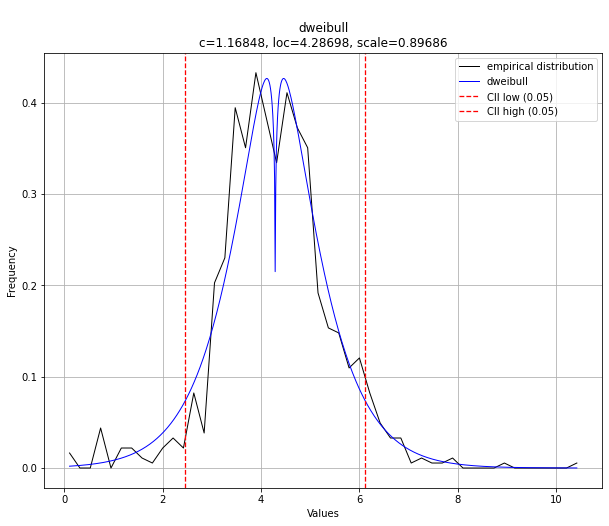

In [138]:
# step 2: check data distribution
check_dist(box_cox(h3_tl_df['time']))

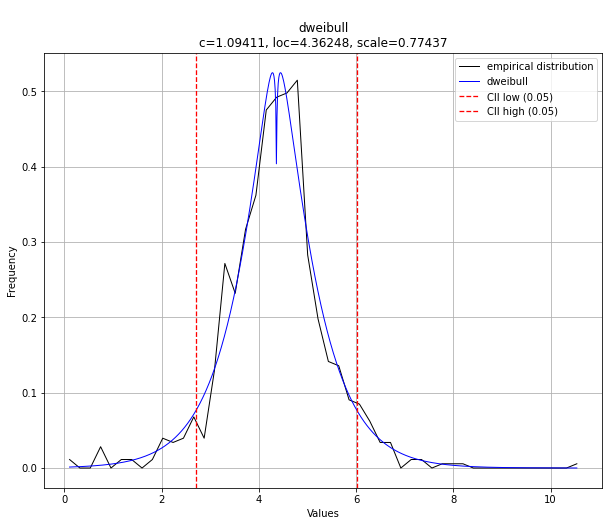

In [139]:
# step 2: check data distribution
check_dist(box_cox(h3_an_df['time']))

Statistics=0.971, p=0.000
Sample does not look Gaussian (reject H0)


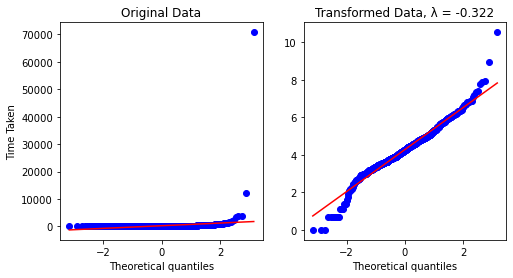

In [140]:
# step 3: transform using box cox and compare before and after
transform_data(h3_tl_df)

Statistics=0.962, p=0.000
Sample does not look Gaussian (reject H0)


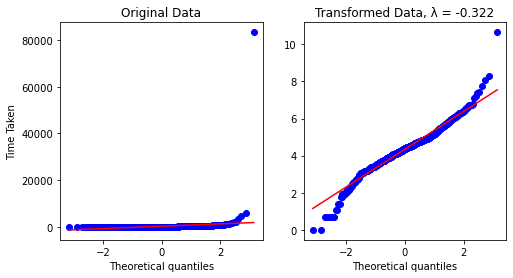

In [141]:
# step 3: transform using box cox and compare before and after
transform_data(h3_an_df)

Statistics=0.983, p=0.000
Sample does not look Gaussian (reject H0)


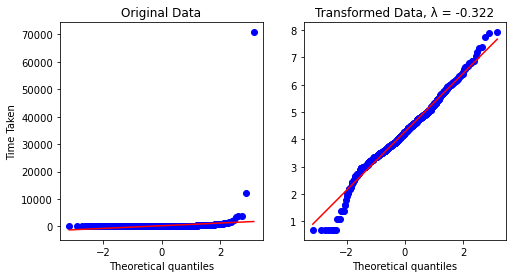

In [142]:
# step 4: IQR outlier removal
h3_tl_df_cleansed = remove_outlier_IQR(h3_tl_df, 'time_trans', 25, 75)
test_distribution(h3_tl_df['time'], h3_tl_df_cleansed['time_trans'])
shapiro_wilk(h3_tl_df_cleansed['time_trans'])

Statistics=0.990, p=0.000
Sample does not look Gaussian (reject H0)


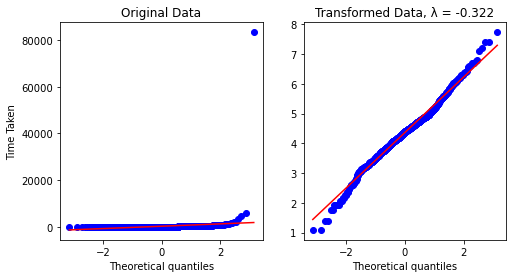

In [143]:
# step 4: IQR outlier removal
h3_an_df_cleansed = remove_outlier_IQR(h3_an_df, 'time_trans', 25, 75)
test_distribution(h3_an_df['time'], h3_an_df_cleansed['time_trans'])
shapiro_wilk(h3_an_df_cleansed['time_trans'])

In [144]:
h3_df = pd.DataFrame()
h3_df = h3_df.append(h3_tl_df_cleansed)
h3_df = h3_df.append(h3_an_df_cleansed)

h3_df

,group,id,question,answer,time,confidence,correct,zoom_timers,drag_timers,highlight_timers,...,drag_interactions,highlight_interactions,slower_interactions,faster_interactions,slider_interactions,network_enc,task_type,task_entity,temporal_enc,time_trans
2,B,02f10e19-83e5-48a3-be35-5258e2e89c1a,m_t1_single_tl,3,62,5,true,"[156, 151, 203, 318, 162, 159, 158, 277, 1295,...",[],"[315, 381, 516, 279, 915, 551, 284, 277, 367, ...",...,0,23,0,0,10,m,t1,single,tl,4.037088
5,B,02f10e19-83e5-48a3-be35-5258e2e89c1a,m_t3_clique_tl,4,652,4,false,"[155, 158, 414, 151, 2016, 501, 71, 745, 547]",[],"[632, 343, 312, 1063, 994, 18016, 428, 1684, 7...",...,0,151,0,0,39,m,t3,clique,tl,6.259902
13,B,02f10e19-83e5-48a3-be35-5258e2e89c1a,m_t1_clique_tl,1,132,5,true,"[164, 151, 224, 1176]",[],"[201, 796, 1398, 265, 4065, 1500, 213, 799, 35...",...,0,69,0,0,0,m,t1,clique,tl,4.757100
14,B,02f10e19-83e5-48a3-be35-5258e2e89c1a,nl_t3_clique_tl,4,146,4,false,"[1745, 314, 234, 1651, 657]",[3140],[],...,1,0,0,0,14,nl,t3,clique,tl,4.852707
15,B,02f10e19-83e5-48a3-be35-5258e2e89c1a,m_t2_single_tl,4,257,4,true,"[218, 327, 454, 331, 775, 229, 204, 151, 1449]",[],"[662, 498, 912, 344, 331, 481, 232, 249, 333, ...",...,0,56,0,0,9,m,t2,single,tl,5.387111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3958,A,fd0eab90-ea5f-48cf-9796-8115762f1f51,nl_t3_single_an,2,26,4,true,[],[],[],...,0,0,0,0,3,nl,t3,single,an,3.199790
3959,A,fd0eab90-ea5f-48cf-9796-8115762f1f51,nl_t3_single_an,2,374,4,true,[],[],[],...,0,0,0,0,3,nl,t3,single,an,5.733358
3961,A,fd0eab90-ea5f-48cf-9796-8115762f1f51,nl_t2_clique_an,5,125,2,false,[],[],[],...,0,0,0,0,3,nl,t2,clique,an,4.701001
3965,A,fd0eab90-ea5f-48cf-9796-8115762f1f51,nl_t1_single_an,4,202,5,true,[],[],[],...,0,0,0,0,23,nl,t1,single,an,5.154657


In [145]:
pg.pairwise_tukey(data=h3_df, dv="time_trans", between="temporal_enc")

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,an,tl,4.366365,4.285321,0.081044,0.049307,1.643651,0.100435,0.080143


In [146]:
mannwhitneyu(x=h3_df[h3_df['temporal_enc']=="an"]['time'], y=h3_df[h3_df['temporal_enc']=="tl"]['time'], alternative="two-sided")

MannwhitneyuResult(statistic=372762.5, pvalue=0.05205698492233544)

In [147]:
print(h3_an_df_cleansed['time'].mean(), h3_tl_df_cleansed['time'].mean())

148.3890243902439 159.01276102088167


In [148]:
pg.kruskal(data=h3_df, dv="time", between="temporal_enc")

,Source,ddof1,H,p-unc
Kruskal,temporal_enc,1,3.774132,0.052051


In [149]:
pg.anova(data=h3_df, dv="time_trans", between="temporal_enc", detailed=True, effsize="n2")

,Source,SS,DF,MS,F,p-unc,n2
0,temporal_enc,2.760177,1,2.760177,2.701589,0.100435,0.001606
1,Within,1716.433504,1680,1.021687,NaN,NaN,NaN


<AxesSubplot:xlabel='time', ylabel='temporal_enc'>

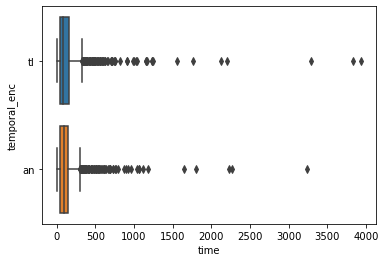

In [150]:
sns.boxplot(x='time', y='temporal_enc', data=h3_df)

In [151]:
h3_df[h3_df['temporal_enc'] == 'tl']['time'].mean()

159.01276102088167

In [152]:
h3_df[h3_df['temporal_enc'] == 'an']['time'].mean()

148.3890243902439

In [153]:
pg.pairwise_ttests(data=h3_df, dv="time", within="temporal_enc", subject="id", parametric=True, alpha=0.05, alternative="two-sided", padjust="bonf", correction=True, return_desc=True)

,Contrast,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
0,temporal_enc,an,tl,147.717656,75.300997,156.240257,106.126034,True,True,-0.63339,67.0,two-sided,0.528635,0.161,-0.092104


In [154]:
pg.ttest(h3_df[h3_df['temporal_enc']=='an']['time'], h3_df[h3_df['temporal_enc']=='tl']['time'], alternative="two-sided", correction=True, confidence=0.95)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.815238,1610.789851,two-sided,0.415056,"[-36.18, 14.94]",0.039515,0.076,0.1278


true     0.590487
false    0.409513
Name: correct, dtype: float64


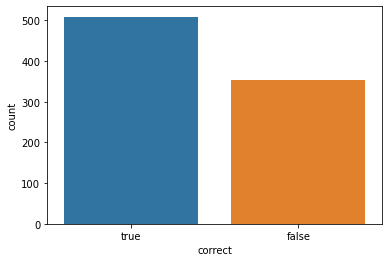

In [155]:
count_plot(h3_df[(h3_df['temporal_enc']=='tl')], 'correct')

# check percentage of correct
print(h3_df[(h3_df['temporal_enc']=='tl')]['correct'].value_counts()/len(h3_df[(h3_df['temporal_enc']=='tl')]))

true     0.680488
false    0.319512
Name: correct, dtype: float64


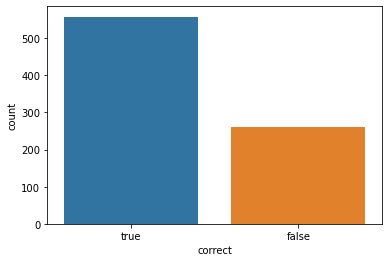

In [156]:
count_plot(h3_df[(h3_df['temporal_enc']=='an')], 'correct')

# check percentage of correct
print(h3_df[(h3_df['temporal_enc']=='an')]['correct'].value_counts()/len(h3_df[(h3_df['temporal_enc']=='an')]))

In [157]:
success_tl, fail_tl = h3_df[(h3_df['temporal_enc']=='tl')]['correct'].value_counts()
success_an, fail_an = h3_df[(h3_df['temporal_enc']=='an')]['correct'].value_counts()

num_trial_tl = len(h3_df[(h3_df['temporal_enc']=='tl')])
num_trial_an = len(h3_df[(h3_df['temporal_enc']=='an')])

success_prob_tl, fail_prob_tl = h3_df[(h3_df['temporal_enc']=='tl')]['correct'].value_counts()/len(h3_df[(h3_df['temporal_enc']=='tl')])
success_prob_an, fail_prob_an = h3_df[(h3_df['temporal_enc']=='an')]['correct'].value_counts()/len(h3_df[(h3_df['temporal_enc']=='an')])

In [158]:
binomtest(success_tl, num_trial_tl, p=success_prob_an, alternative="less")

BinomTestResult(k=509, n=862, alternative='less', proportion_estimate=0.5904872389791184, pvalue=1.7152153803763043e-08)

## H4

In [159]:
# step 1: create data groups (a vs b)
h4_a_df = original_df.loc[original_df['group'] == 'A']
h4_b_df = original_df.loc[original_df['group'] == 'B']

# interaction group time >= non-interaction group time (no significant difference)
# interaction group correctness > non-interaction group correctness (significant difference)

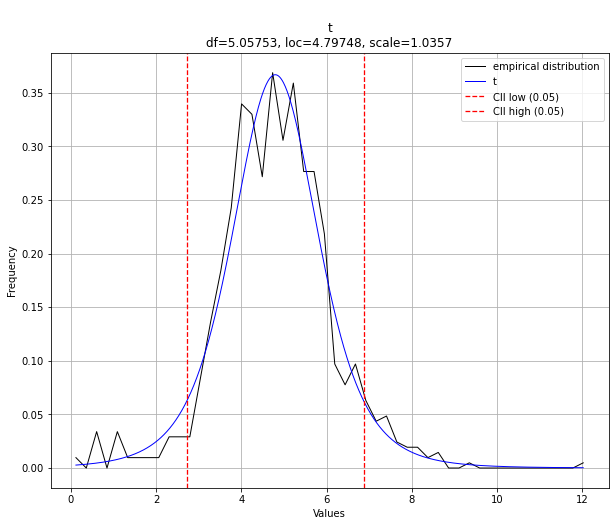

In [160]:
# step 2: check data distribution
check_dist(box_cox(h4_a_df['time']))

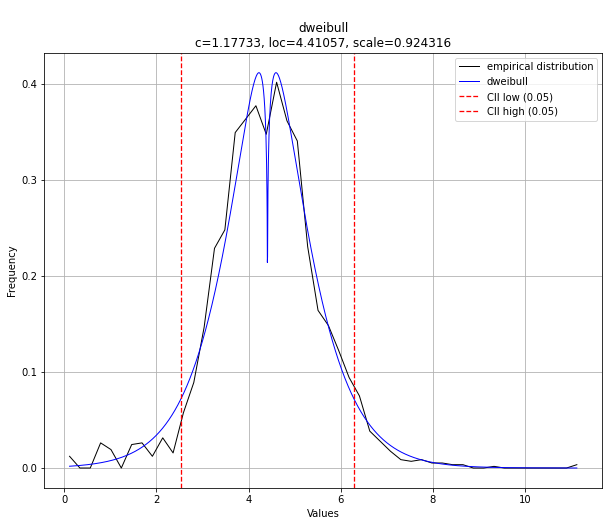

In [161]:
# step 2: check data distribution
check_dist(box_cox(h4_b_df['time']))

Statistics=0.975, p=0.000
Sample does not look Gaussian (reject H0)


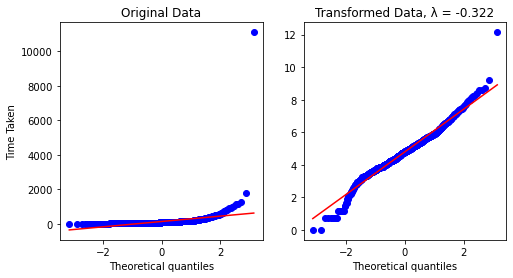

In [162]:
# step 3: transform using box cox and compare before and after
transform_data(h4_a_df)

Statistics=0.979, p=0.000
Sample does not look Gaussian (reject H0)


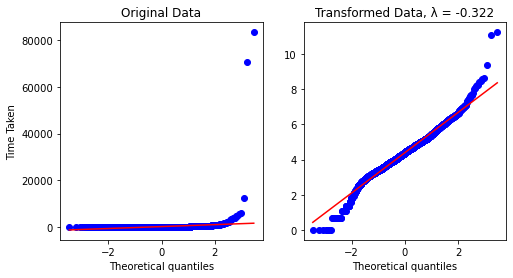

In [163]:
# step 3: transform using box cox and compare before and after
transform_data(h4_b_df)

Statistics=0.983, p=0.000
Sample does not look Gaussian (reject H0)


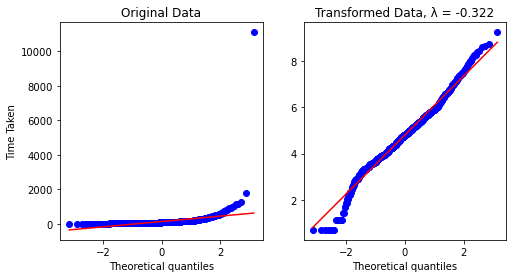

In [164]:
# step 4: IQR outlier removal
h4_a_df_cleansed = remove_outlier_IQR(h4_a_df, 'time_trans', 25, 75)
test_distribution(h4_a_df['time'], h4_a_df_cleansed['time_trans'])
shapiro_wilk(h4_a_df_cleansed['time_trans'])

Statistics=0.989, p=0.000
Sample does not look Gaussian (reject H0)


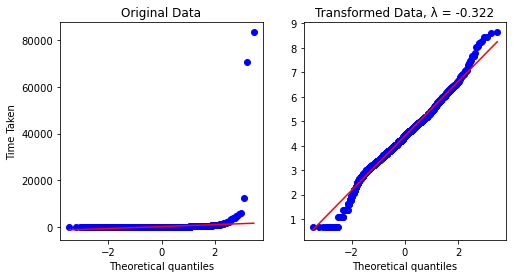

In [165]:
# step 4: IQR outlier removal
h4_b_df_cleansed = remove_outlier_IQR(h4_b_df, 'time_trans', 25, 75)
test_distribution(h4_b_df['time'], h4_b_df_cleansed['time_trans'])
shapiro_wilk(h4_b_df_cleansed['time_trans'])

In [166]:
h4_df = pd.DataFrame()
h4_df = h4_df.append(h4_a_df_cleansed)
h4_df = h4_df.append(h4_b_df_cleansed)

h4_df

,group,id,question,answer,time,confidence,correct,zoom_timers,drag_timers,highlight_timers,...,drag_interactions,highlight_interactions,slower_interactions,faster_interactions,slider_interactions,network_enc,task_type,task_entity,temporal_enc,time_trans
264,A,0fe0c9f2-4f5c-44ab-933d-f0b25f7bbe47,m_t2_single_tl,1,73,2,false,[],[],[],...,0,0,0,0,17,m,t2,single,tl,4.834578
265,A,0fe0c9f2-4f5c-44ab-933d-f0b25f7bbe47,nl_t3_single_tl,2,33,4,true,[],[],[],...,0,0,0,0,9,nl,t3,single,tl,3.852512
266,A,0fe0c9f2-4f5c-44ab-933d-f0b25f7bbe47,nl_t2_clique_an,6,214,2,false,[],[],[],...,0,0,0,0,9,nl,t2,clique,an,6.234663
267,A,0fe0c9f2-4f5c-44ab-933d-f0b25f7bbe47,nl_t2_single_jp,4,78,3,true,[],[],[],...,0,0,0,0,9,nl,t2,single,jp,4.918465
268,A,0fe0c9f2-4f5c-44ab-933d-f0b25f7bbe47,nl_t3_clique_tl,5,99,2,false,[],[],[],...,0,0,0,0,19,nl,t3,clique,tl,5.222869
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3861,B,f81817ac-49cb-47ed-a599-6b9ba011360d,nl_t3_clique_jp,5,152,5,false,"[1248, 165, 292, 159, 456, 244, 1136, 478, 856...",[2596],[],...,1,0,0,0,0,nl,t3,clique,jp,5.006387
3862,B,f81817ac-49cb-47ed-a599-6b9ba011360d,nl_t1_single_jp,2,27,5,true,"[232, 1799, 238]",[3225],[],...,1,0,0,0,0,nl,t1,single,jp,3.288302
3863,B,f81817ac-49cb-47ed-a599-6b9ba011360d,m_t3_clique_an,4,52,3,true,"[232, 1799, 238]",[3225],[],...,1,0,0,0,0,m,t3,clique,an,3.940417
3864,B,f81817ac-49cb-47ed-a599-6b9ba011360d,nl_t2_single_an,4,132,5,true,"[969, 505, 161, 630, 443]",[1350],[],...,1,0,0,0,0,nl,t2,single,an,4.866276


In [167]:
pg.pairwise_tukey(data=h4_df, dv="time_trans", between="group")

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,A,B,4.806587,4.403592,0.402994,0.046009,8.759088,0.0,0.347705


In [168]:
mannwhitneyu(x=h4_df[h4_df['group']=="A"]['time'], y=h4_df[h4_df['group']=="B"]['time'], alternative="less")

MannwhitneyuResult(statistic=973004.0, pvalue=2.682443322786264e-05)

<AxesSubplot:xlabel='time', ylabel='group'>

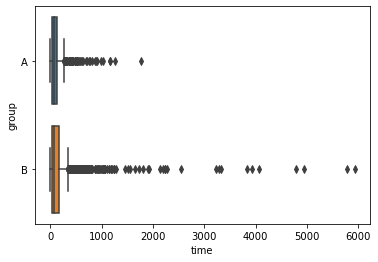

In [169]:
sns.boxplot(x='time', y='group', data=h4_df)

In [170]:
h4_df[h4_df['group'] == 'A']['time'].mean()

114.7612293144208

In [171]:
h4_df[h4_df['group'] == 'B']['time'].mean()

163.83274161735702

In [172]:
pg.anova(data=h4_df, dv="time_trans", between="group", detailed=True, effsize="n2")

,Source,SS,DF,MS,F,p-unc,n2
0,group,103.015065,1,103.015065,76.721627,3.056824e-18,0.022201
1,Within,4537.024522,3379,1.342712,NaN,NaN,NaN


In [173]:
pg.kruskal(data=h4_df, dv="time", between="group")

,Source,ddof1,H,p-unc
Kruskal,group,1,16.314769,0.000054


In [174]:
pg.ttest(h4_df[h4_df['group']=='A']['time'], h4_df[h4_df['group']=='B']['time'], alternative="less", correction=True, confidence=0.95)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-5.680379,3114.828249,less,7.338544e-09,"[-inf, -34.86]",0.159679,7.673e+05,0.991248


In [175]:
pg.pairwise_ttests(data=h4_df, dv="time_trans", between="group",parametric=True, alpha=0.05, alternative="two-sided", padjust="bonf", correction=True, return_desc=True)

,Contrast,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
0,group,A,B,4.806587,1.274861,4.403592,1.117358,False,True,8.202833,1305.179438,two-sided,5.567718e-16,1.094e+13,0.347705


true     0.58156
false    0.41844
Name: correct, dtype: float64


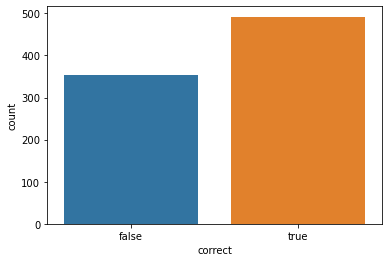

In [176]:
count_plot(h4_df[(h4_df['group']=='A')], 'correct')

# check percentage of correct
print(h4_df[(h4_df['group']=='A')]['correct'].value_counts()/len(h4_df[(h4_df['group']=='A')]))

true     0.650493
false    0.349507
Name: correct, dtype: float64


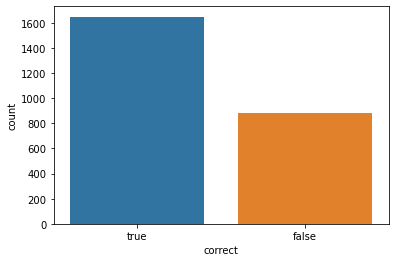

In [177]:
count_plot(h4_df[(h4_df['group']=='B')], 'correct')

# check percentage of correct
print(h4_df[(h4_df['group']=='B')]['correct'].value_counts()/len(h4_df[(h4_df['group']=='B')]))

In [178]:
success_a, fail_a = h4_df[(h4_df['group']=='A')]['correct'].value_counts()
success_b, fail_b = h4_df[(h4_df['group']=='B')]['correct'].value_counts()

num_trial_a = len(h4_df[(h4_df['group']=='A')])
num_trial_b = len(h4_df[(h4_df['group']=='B')])

success_prob_a, fail_prob_a = h4_df[(h4_df['group']=='A')]['correct'].value_counts()/len(h4_df[(h4_df['group']=='A')])
success_prob_b, fail_prob_b = h4_df[(h4_df['group']=='B')]['correct'].value_counts()/len(h4_df[(h4_df['group']=='B')])

In [179]:
binomtest(success_a, num_trial_a, p=success_prob_b, alternative="less")

BinomTestResult(k=492, n=846, alternative='less', proportion_estimate=0.5815602836879432, pvalue=1.910544503283136e-05)

## H5

In [180]:
# step 1: create data groups (tl vs an)
h5_nl_df = original_df.loc[original_df['network_enc'] == 'nl']
h5_m_df = original_df.loc[original_df['network_enc'] == 'm']

# m_single, m_clique
# nl_single, nl_clique

# m_single time < nl_single time
# m_clique time > nl_clique time

# m_single correctness > nl_single correctness
# m_clique correctness < nl_clique correctness

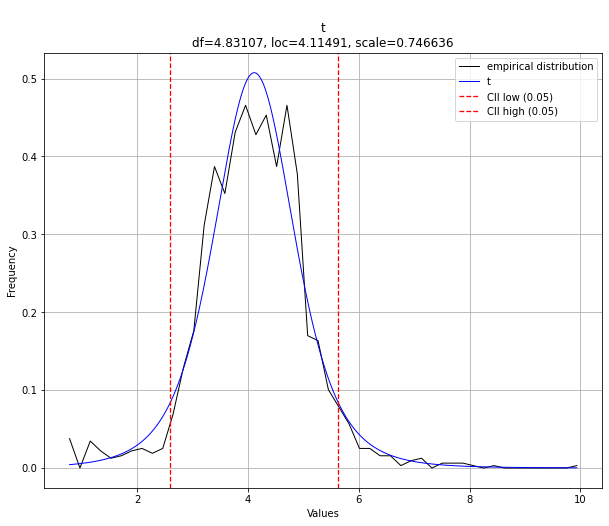

In [181]:
# step 2: check data distribution
check_dist(box_cox(h5_nl_df['time']))

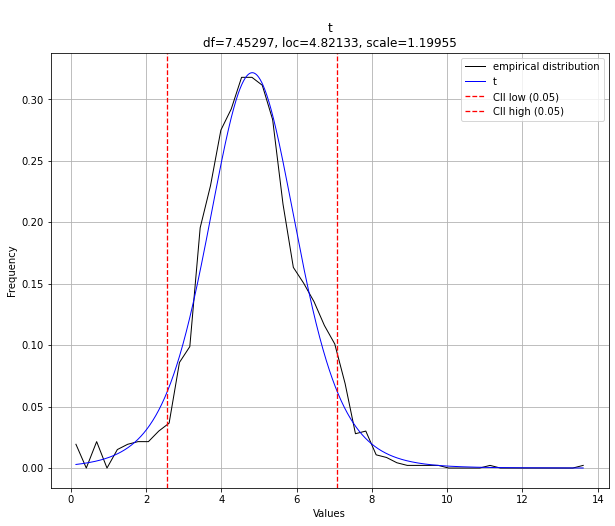

In [182]:
# step 2: check data distribution
check_dist(box_cox(h5_m_df['time']))

Statistics=0.965, p=0.000
Sample does not look Gaussian (reject H0)


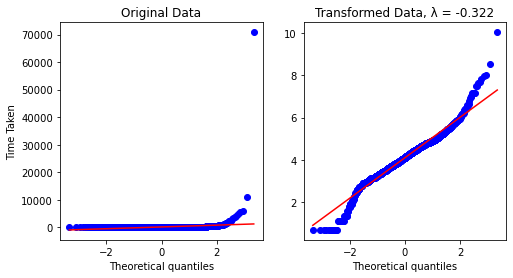

In [183]:
# step 3: transform using box cox and compare before and after
transform_data(h5_nl_df)

Statistics=0.983, p=0.000
Sample does not look Gaussian (reject H0)


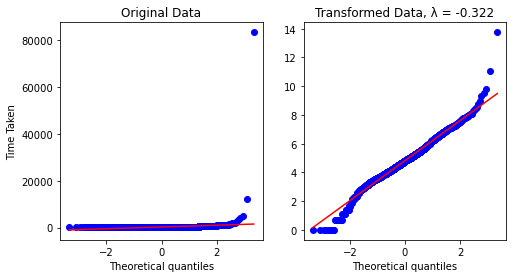

In [184]:
# step 3: transform using box cox and compare before and after
transform_data(h5_m_df)

Statistics=0.974, p=0.000
Sample does not look Gaussian (reject H0)


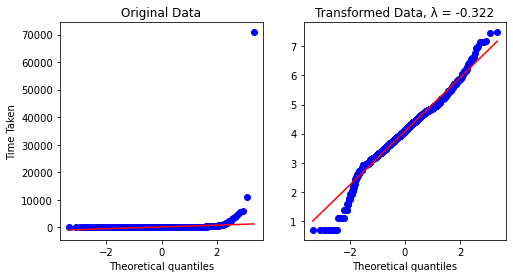

In [185]:
# step 4: IQR outlier removal
h5_nl_df_cleansed = remove_outlier_IQR(h5_nl_df, 'time_trans', 25, 75)
test_distribution(h5_nl_df['time'], h5_nl_df_cleansed['time_trans'])
shapiro_wilk(h5_nl_df_cleansed['time_trans'])

Statistics=0.989, p=0.000
Sample does not look Gaussian (reject H0)


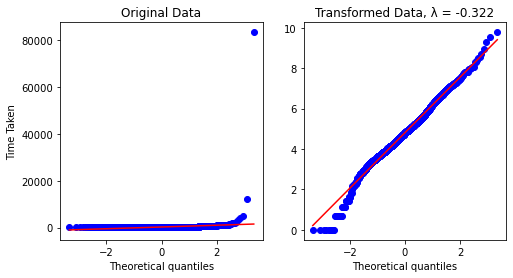

In [186]:
# step 4: IQR outlier removal
h5_m_df_cleansed = remove_outlier_IQR(h5_m_df, 'time_trans', 25, 75)
test_distribution(h5_m_df['time'], h5_m_df_cleansed['time_trans'])
shapiro_wilk(h5_m_df_cleansed['time_trans'])

In [187]:
# step 5: further subdivide based on task type
# single vs clique for nl
h5_nl_single_df = h5_nl_df.loc[h5_nl_df['task_entity'] == 'single']
h5_nl_clique_df = h5_nl_df.loc[h5_nl_df['task_entity'] == 'clique']

# single vs clique for m
h5_m_single_df = h5_m_df.loc[h5_m_df['task_entity'] == 'single']
h5_m_clique_df = h5_m_df.loc[h5_m_df['task_entity'] == 'clique']

In [188]:
h5_df = pd.DataFrame()
h5_df = h5_df.append(h5_m_df_cleansed)
h5_df = h5_df.append(h5_nl_df_cleansed)

h5_df

,group,id,question,answer,time,confidence,correct,zoom_timers,drag_timers,highlight_timers,...,drag_interactions,highlight_interactions,slower_interactions,faster_interactions,slider_interactions,network_enc,task_type,task_entity,temporal_enc,time_trans
0,B,02f10e19-83e5-48a3-be35-5258e2e89c1a,m_t1_clique_si,3,754,1,true,[100],[],"[3400, 429, 8300, 428, 233, 214, 1599, 57199, ...",...,0,162,0,0,0,m,t1,clique,si,7.408786
2,B,02f10e19-83e5-48a3-be35-5258e2e89c1a,m_t1_single_tl,3,62,5,true,"[156, 151, 203, 318, 162, 159, 158, 277, 1295,...",[],"[315, 381, 516, 279, 915, 551, 284, 277, 367, ...",...,0,23,0,0,10,m,t1,single,tl,4.422604
3,B,02f10e19-83e5-48a3-be35-5258e2e89c1a,m_t3_clique_jp,5,605,5,false,[],[],"[1947, 263, 396, 9420, 464, 364, 25930, 304, 8...",...,0,100,0,0,0,m,t3,clique,jp,7.135580
4,B,02f10e19-83e5-48a3-be35-5258e2e89c1a,m_t1_single_si,2,40,5,true,[],[],"[1249, 360, 783, 332, 415, 518, 3727, 481, 114...",...,0,10,0,0,0,m,t1,single,si,3.923765
5,B,02f10e19-83e5-48a3-be35-5258e2e89c1a,m_t3_clique_tl,4,652,4,false,"[155, 158, 414, 151, 2016, 501, 71, 745, 547]",[],"[632, 343, 312, 1063, 994, 18016, 428, 1684, 7...",...,0,151,0,0,39,m,t3,clique,tl,7.228197
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3966,A,fd0eab90-ea5f-48cf-9796-8115762f1f51,nl_t3_single_si,1,38,4,true,[],[],[],...,0,0,0,0,23,nl,t3,single,si,3.510913
3968,A,fd0eab90-ea5f-48cf-9796-8115762f1f51,nl_t2_clique_jp,6,47,1,false,[],[],[],...,0,0,0,0,23,nl,t2,clique,jp,3.708433
3969,A,fd0eab90-ea5f-48cf-9796-8115762f1f51,nl_t3_clique_jp,4,28,2,false,[],[],[],...,0,0,0,0,23,nl,t3,clique,jp,3.225698
3970,A,fd0eab90-ea5f-48cf-9796-8115762f1f51,nl_t2_clique_si,3,74,1,false,[],[],[],...,0,0,0,0,23,nl,t2,clique,si,4.127483


In [189]:
# m_single time < nl_single time
# m_clique time > nl_clique time
pg.pairwise_tukey(data=h5_df[h5_df["task_entity"] == "single"], dv="time_trans", between="network_enc")

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,m,nl,4.39321,3.842985,0.550225,0.045385,12.123561,3.206324e-13,0.585246


In [190]:
pg.pairwise_tukey(data=h5_df[h5_df["task_entity"] == "clique"], dv="time_trans", between="network_enc")

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,m,nl,5.245628,4.335381,0.910247,0.063078,14.430413,1.507683e-13,0.705919


In [191]:
mannwhitneyu(x=h5_df[(h5_df['task_entity']=='single') & (h5_df['network_enc']=='m')]['time'], y=h5_df[(h5_df['task_entity']=='single') & (h5_df['network_enc']=='nl')]['time'], alternative="two-sided")

MannwhitneyuResult(statistic=404549.5, pvalue=0.00032015589061485544)

In [192]:
mannwhitneyu(x=h5_df[(h5_df['task_entity']=='clique') & (h5_df['network_enc']=='m')]['time'], y=h5_df[(h5_df['task_entity']=='clique') & (h5_df['network_enc']=='nl')]['time'], alternative="two-sided")

MannwhitneyuResult(statistic=412220.5, pvalue=1.0788372734238065e-10)

(0.0, 900.0)

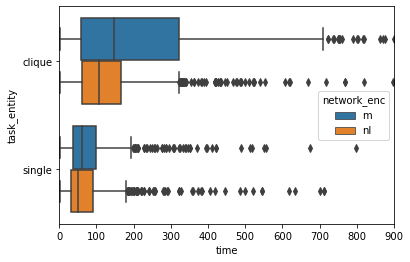

In [193]:
ax = sns.boxplot(x='time', y='task_entity', hue="network_enc", data=h5_df)
ax.set_xlim(0, 900)

In [194]:
mean_m_single = h5_df.query('task_entity=="single" & network_enc=="m"')['time'].mean()
mean_m_clique = h5_df.query('task_entity=="clique" & network_enc=="m"')['time'].mean()
mean_nl_single = h5_df.query('task_entity=="single" & network_enc=="nl"')['time'].mean()
mean_nl_clique = h5_df.query('task_entity=="clique" & network_enc=="nl"')['time'].mean()

print(mean_m_single, mean_m_clique)
print(mean_nl_single, mean_nl_clique)

90.24883177570094 245.20119760479042
97.08498253783469 146.66706586826348


true     0.864486
false    0.135514
Name: correct, dtype: float64


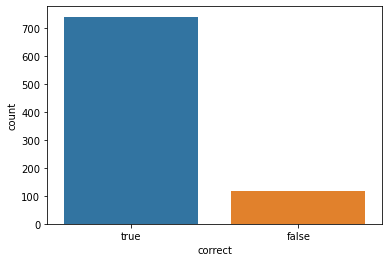

In [195]:
count_plot(h5_df.query('task_entity=="single" & network_enc=="m"'), 'correct')

# check percentage of correct
print(h5_df.query('task_entity=="single" & network_enc=="m"')['correct'].value_counts()/len(h5_df.query('task_entity=="single" & network_enc=="m"')))

false    0.586826
true     0.413174
Name: correct, dtype: float64


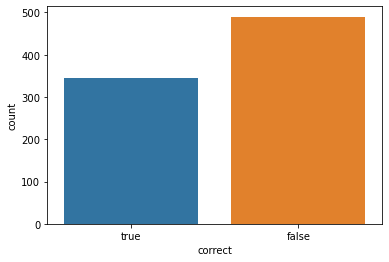

In [196]:
count_plot(h5_df.query('task_entity=="clique" & network_enc=="m"'), 'correct')

# check percentage of correct
print(h5_df.query('task_entity=="clique" & network_enc=="m"')['correct'].value_counts()/len(h5_df.query('task_entity=="clique" & network_enc=="m"')))

true     0.821886
false    0.178114
Name: correct, dtype: float64


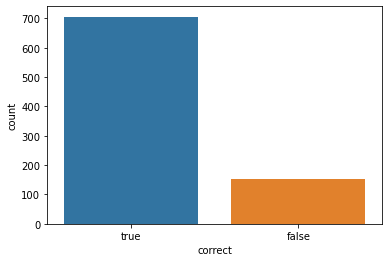

In [197]:
count_plot(h5_df.query('task_entity=="single" & network_enc=="nl"'), 'correct')

# check percentage of correct
print(h5_df.query('task_entity=="single" & network_enc=="nl"')['correct'].value_counts()/len(h5_df.query('task_entity=="single" & network_enc=="nl"')))

false    0.578443
true     0.421557
Name: correct, dtype: float64


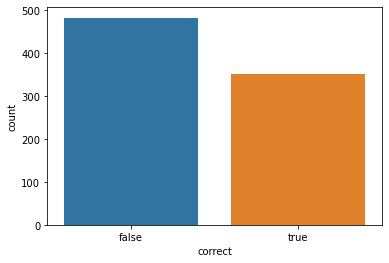

In [198]:
count_plot(h5_df.query('task_entity=="clique" & network_enc=="nl"'), 'correct')

# check percentage of correct
print(h5_df.query('task_entity=="clique" & network_enc=="nl"')['correct'].value_counts()/len(h5_df.query('task_entity=="clique" & network_enc=="nl"')))

In [199]:
pg.anova(data=h5_df[h5_df['task_entity'] == 'clique'], dv="time", between="network_enc", detailed=True, effsize="n2")

,Source,SS,DF,MS,F,p-unc,n2
0,network_enc,4.053497e+06,1,4.053497e+06,54.410442,2.552141e-13,0.03159
1,Within,1.242635e+08,1668,7.449851e+04,NaN,NaN,NaN


In [200]:
pg.kruskal(data=h5_df[h5_df['task_entity']=='single'], dv="time", between="network_enc")

,Source,ddof1,H,p-unc
Kruskal,network_enc,1,12.94898,0.00032


In [201]:
pg.kruskal(data=h5_df[h5_df['task_entity']=='clique'], dv="time", between="network_enc")

,Source,ddof1,H,p-unc
Kruskal,network_enc,1,41.673745,1.078476e-10


In [202]:
pg.ttest(h5_df[(h5_df['task_entity']=='single') & (h5_df['network_enc']=='m')]['time'], h5_df[(h5_df['task_entity']=='single') & (h5_df['network_enc']=='nl')]['time'], alternative="two-sided", correction=True, confidence=0.95)
# M VS NL (single) greater

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.718273,1622.88837,two-sided,0.472692,"[-25.5, 11.83]",0.034674,0.07,0.110754


In [203]:
pg.ttest(h5_df[(h5_df['task_entity']=='clique') & (h5_df['network_enc']=='m')]['time'], h5_df[(h5_df['task_entity']=='clique') & (h5_df['network_enc']=='nl')]['time'], alternative="greater", correction=True, confidence=0.95)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,7.376343,1359.02266,greater,1.409903e-13,"[76.55, inf]",0.361005,3.764e+10,1.0


In [204]:
pg.pairwise_ttests(data=h5_df[(h5_df['task_entity']=='single')], dv="time_trans", between="network_enc",parametric=True, alpha=0.05, alternative="two-sided", padjust="bonf", correction=True, return_desc=True)

,Contrast,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
0,network_enc,m,nl,4.39321,1.012482,3.842985,0.861179,False,True,12.120157,1668.179051,two-sided,1.829630e-32,1.357e+29,0.585246


In [205]:
pg.pairwise_ttests(data=h5_df[(h5_df['task_entity']=='clique')], dv="time_trans", between="network_enc",parametric=True, alpha=0.05, alternative="two-sided", padjust="bonf", correction=True, return_desc=True)

,Contrast,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
0,network_enc,m,nl,5.245628,1.56042,4.335381,0.942049,False,True,14.430413,1370.650072,two-sided,4.737416e-44,1.198e+41,0.705919


true     0.864486
false    0.135514
Name: correct, dtype: float64


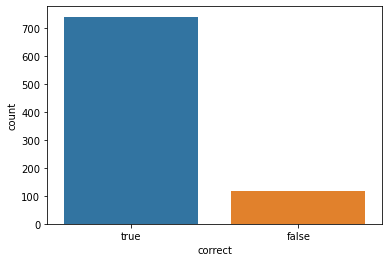

In [206]:
# M SINGLE
count_plot(h5_df[(h5_df['task_entity']=='single') & (h5_df['network_enc']=='m')], 'correct')

# check percentage of correct
print(h5_df[(h5_df['task_entity']=='single') & (h5_df['network_enc']=='m')]['correct'].value_counts()/len(h5_df[(h5_df['task_entity']=='single') & (h5_df['network_enc']=='m')]))

false    0.586826
true     0.413174
Name: correct, dtype: float64


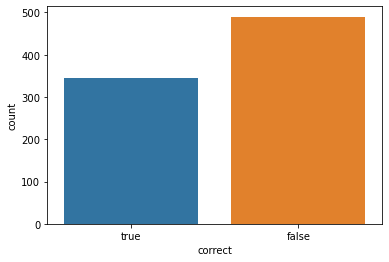

In [207]:
# M CLIQUE
count_plot(h5_df[(h5_df['task_entity']=='clique') & (h5_df['network_enc']=='m')], 'correct')

# check percentage of correct
print(h5_df[(h5_df['task_entity']=='clique') & (h5_df['network_enc']=='m')]['correct'].value_counts()/len(h5_df[(h5_df['task_entity']=='clique') & (h5_df['network_enc']=='m')]))

true     0.821886
false    0.178114
Name: correct, dtype: float64


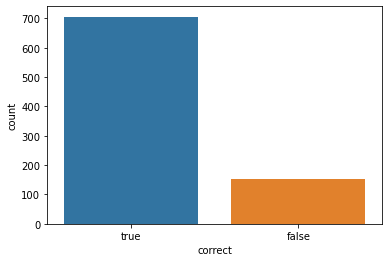

In [208]:
# NL SINGLE
count_plot(h5_df[(h5_df['task_entity']=='single') & (h5_df['network_enc']=='nl')], 'correct')

# check percentage of correct
print(h5_df[(h5_df['task_entity']=='single') & (h5_df['network_enc']=='nl')]['correct'].value_counts()/len(h5_df[(h5_df['task_entity']=='single') & (h5_df['network_enc']=='nl')]))

false    0.578443
true     0.421557
Name: correct, dtype: float64


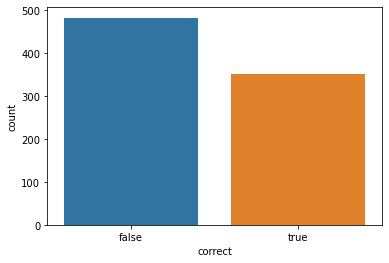

In [209]:
# NL CLIQUE
count_plot(h5_df[(h5_df['task_entity']=='clique') & (h5_df['network_enc']=='nl')], 'correct')

# check percentage of correct
print(h5_df[(h5_df['task_entity']=='clique') & (h5_df['network_enc']=='nl')]['correct'].value_counts()/len(h5_df[(h5_df['task_entity']=='clique') & (h5_df['network_enc']=='nl')]))

In [210]:
success_m_single, fail_m_single = h5_df[(h5_df['task_entity']=='single') & (h5_df['network_enc']=='m')]['correct'].value_counts()
success_m_clique, fail_m_clique = h5_df[(h5_df['task_entity']=='clique') & (h5_df['network_enc']=='m')]['correct'].value_counts()
success_nl_single, fail_nl_single = h5_df[(h5_df['task_entity']=='single') & (h5_df['network_enc']=='nl')]['correct'].value_counts()
success_nl_clique, fail_nl_clique = h5_df[(h5_df['task_entity']=='clique') & (h5_df['network_enc']=='nl')]['correct'].value_counts()

num_trial_m_single = len(h5_df[(h5_df['task_entity']=='single') & (h5_df['network_enc']=='m')])
num_trial_m_clique = len(h5_df[(h5_df['task_entity']=='clique') & (h5_df['network_enc']=='m')])
num_trial_nl_single = len(h5_df[(h5_df['task_entity']=='single') & (h5_df['network_enc']=='nl')])
num_trial_nl_clique = len(h5_df[(h5_df['task_entity']=='clique') & (h5_df['network_enc']=='nl')])

success_prob_m_single, fail_prob_m_single = h5_df[(h5_df['task_entity']=='single') & (h5_df['network_enc']=='m')]['correct'].value_counts()/len(h5_df[(h5_df['task_entity']=='single') & (h5_df['network_enc']=='m')])
success_prob_m_clique, fail_prob_m_clique = h5_df[(h5_df['task_entity']=='clique') & (h5_df['network_enc']=='m')]['correct'].value_counts()/len(h5_df[(h5_df['task_entity']=='clique') & (h5_df['network_enc']=='m')])
success_prob_nl_single, fail_prob_nl_single = h5_df[(h5_df['task_entity']=='single') & (h5_df['network_enc']=='nl')]['correct'].value_counts()/len(h5_df[(h5_df['task_entity']=='single') & (h5_df['network_enc']=='nl')])
success_prob_nl_clique, fail_prob_nl_clique = h5_df[(h5_df['task_entity']=='clique') & (h5_df['network_enc']=='nl')]['correct'].value_counts()/len(h5_df[(h5_df['task_entity']=='clique') & (h5_df['network_enc']=='nl')])

In [211]:
binomtest(success_m_single, num_trial_m_single, p=success_prob_nl_single, alternative="greater")

BinomTestResult(k=740, n=856, alternative='greater', proportion_estimate=0.8644859813084113, pvalue=0.00045975825409672933)

In [212]:
binomtest(success_nl_clique, num_trial_nl_clique, p=success_prob_m_clique, alternative="greater")

BinomTestResult(k=483, n=835, alternative='greater', proportion_estimate=0.578443113772455, pvalue=0.701436355090384)

## H6

In [213]:
# pairwise tests for time
# M_SI M_JP
# M_SI M_AN
# M_SI M_TL
# M_SI NL_SI
# M_SI NL_JP
# M_SI NL_AN
# M_SI NL_TL
# Alpha = 0.00625 (bonferoni correction for 7 tests) - this is the threshold

# step 1: create data groups (nl vs m)
h6_nl_df = original_df.loc[original_df['network_enc'] == 'nl']
h6_m_df = original_df.loc[original_df['network_enc'] == 'm']

# step 1.1: further subdivide based on task type
# nl vs m for si
h6_nl_df_si = h1_nl_df.loc[h1_nl_df['temporal_enc'] == 'si']
h6_m_df_si = h1_m_df.loc[h1_m_df['temporal_enc'] == 'si']

# nl vs m for jp
h6_nl_df_jp = h1_nl_df.loc[h1_nl_df['temporal_enc'] == 'jp']
h6_m_df_jp = h1_m_df.loc[h1_m_df['temporal_enc'] == 'jp']

# nl vs m for tl
h6_nl_df_tl = h1_nl_df.loc[h1_nl_df['temporal_enc'] == 'tl']
h6_m_df_tl = h1_m_df.loc[h1_m_df['temporal_enc'] == 'tl']

# nl vs m for an
h6_nl_df_an = h1_nl_df.loc[h1_nl_df['temporal_enc'] == 'an']
h6_m_df_an = h1_m_df.loc[h1_m_df['temporal_enc'] == 'an']

# binominal for correcctness
# Alpha = 0.00625 (bonferoni correction for 8 tests)

# parse new csv to check preferences of network + temporal encoding

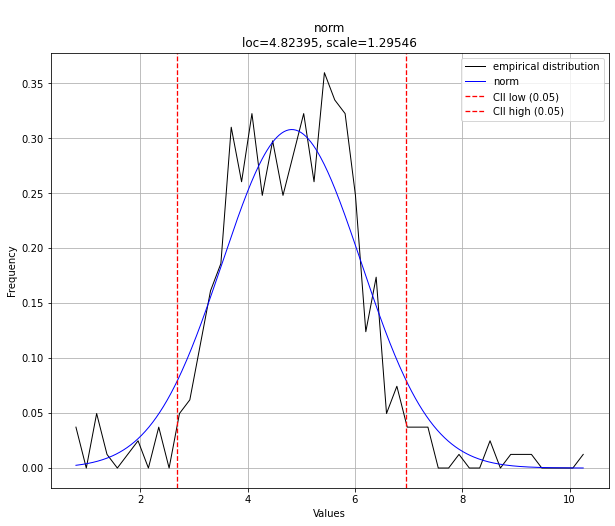

In [214]:
# step 2: check data distribution
check_dist(box_cox(h6_nl_df_si['time']))

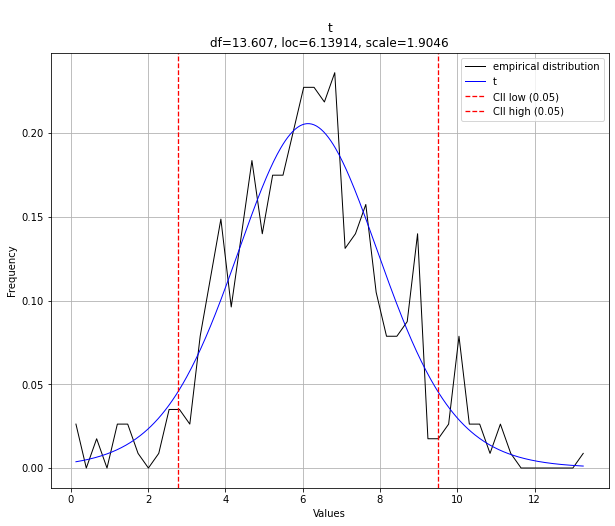

In [215]:
# step 2: check data distribution
check_dist(box_cox(h6_m_df_si['time']))

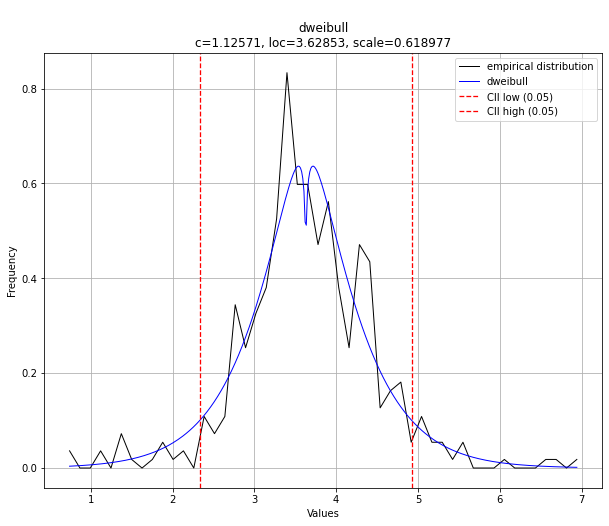

In [216]:
# step 2: check data distribution
check_dist(box_cox(h6_nl_df_jp['time']))

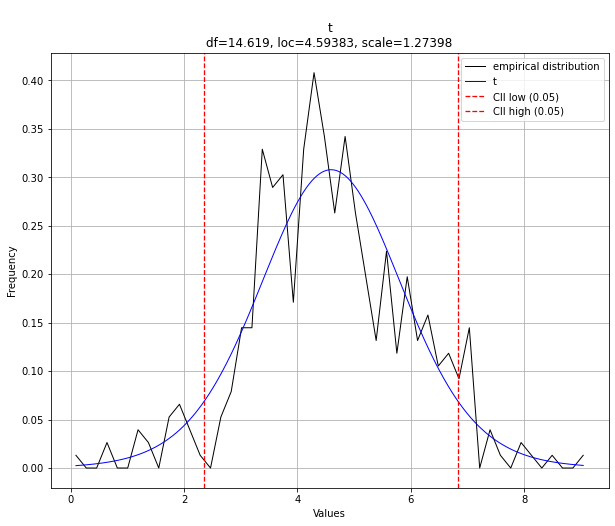

In [217]:
# step 2: check data distribution
check_dist(box_cox(h6_m_df_jp['time']))

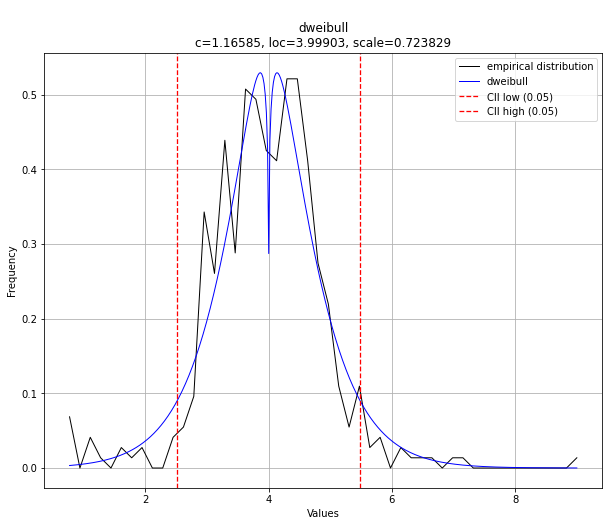

In [218]:
# step 2: check data distribution
check_dist(box_cox(h6_nl_df_tl['time']))

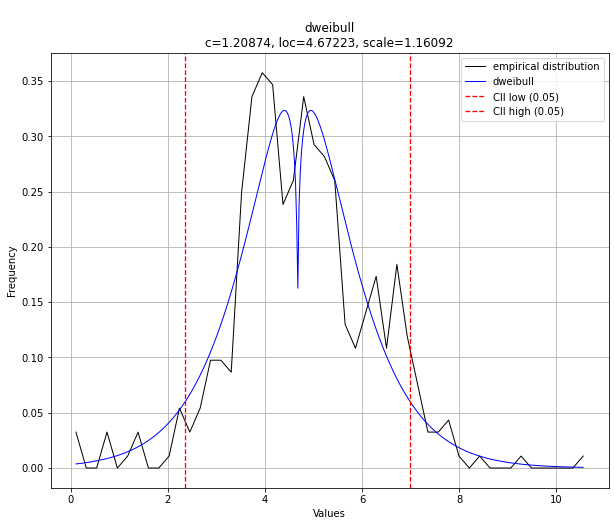

In [219]:
# step 2: check data distribution
check_dist(box_cox(h6_m_df_tl['time']))

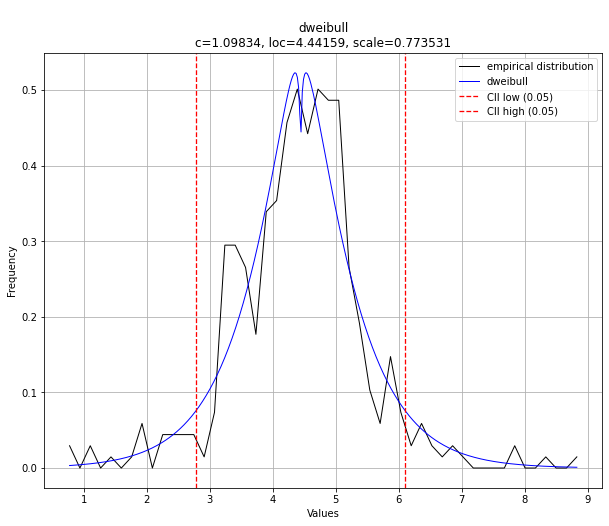

In [220]:
# step 2: check data distribution
check_dist(box_cox(h6_nl_df_an['time']))

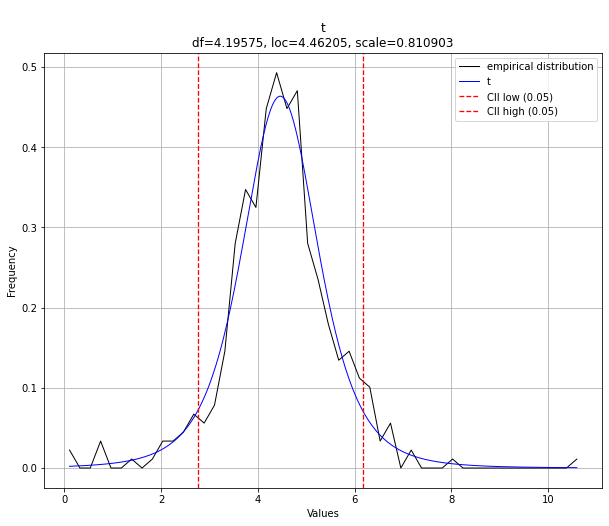

In [221]:
# step 2: check data distribution
check_dist(box_cox(h6_m_df_an['time']))

Statistics=0.976, p=0.000
Sample does not look Gaussian (reject H0)


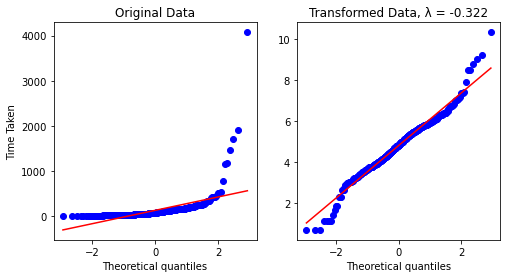

In [222]:
# step 3: transform using box cox and compare before and after
transform_data(h6_nl_df_si)

Statistics=0.994, p=0.113
Sample looks Gaussian (fail to reject H0)


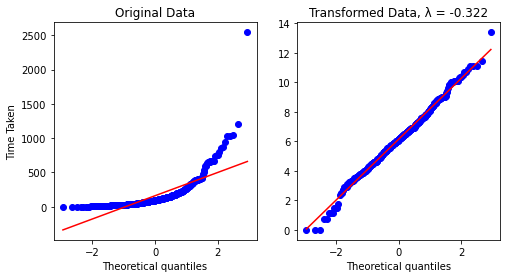

In [223]:
# step 3: transform using box cox and compare before and after
transform_data(h6_m_df_si)

Statistics=0.967, p=0.000
Sample does not look Gaussian (reject H0)


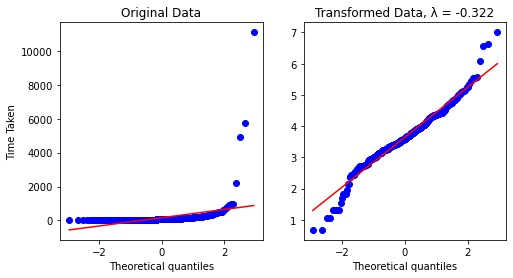

In [224]:
# step 3: transform using box cox and compare before and after
transform_data(h6_nl_df_jp)

Statistics=0.991, p=0.012
Sample does not look Gaussian (reject H0)


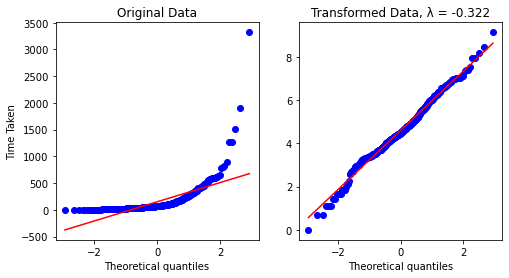

In [225]:
# step 3: transform using box cox and compare before and after
transform_data(h6_m_df_jp)

Statistics=0.947, p=0.000
Sample does not look Gaussian (reject H0)


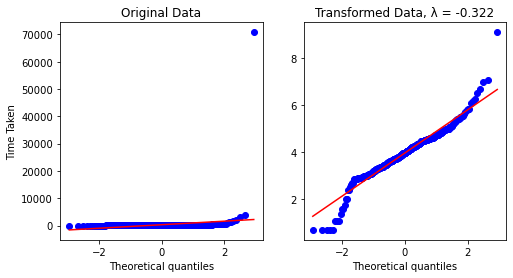

In [226]:
# step 3: transform using box cox and compare before and after
transform_data(h6_nl_df_tl)

Statistics=0.983, p=0.000
Sample does not look Gaussian (reject H0)


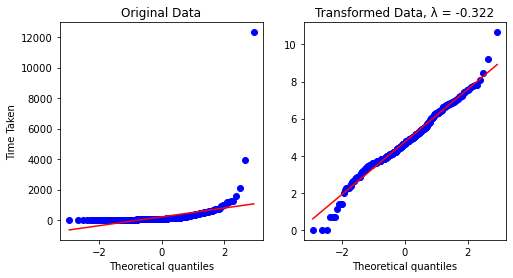

In [227]:
# step 3: transform using box cox and compare before and after
transform_data(h6_m_df_tl)

Statistics=0.965, p=0.000
Sample does not look Gaussian (reject H0)


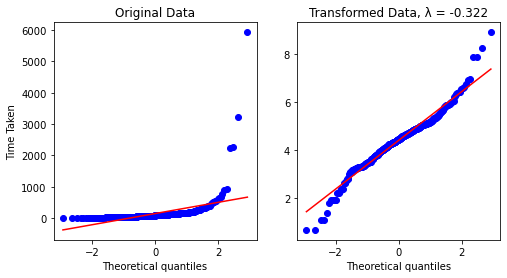

In [228]:
# step 3: transform using box cox and compare before and after
transform_data(h6_nl_df_an)

Statistics=0.956, p=0.000
Sample does not look Gaussian (reject H0)


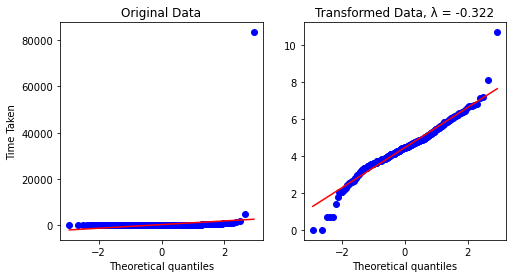

In [229]:
# step 3: transform using box cox and compare before and after
transform_data(h6_m_df_an)

Statistics=0.994, p=0.132
Sample looks Gaussian (fail to reject H0)


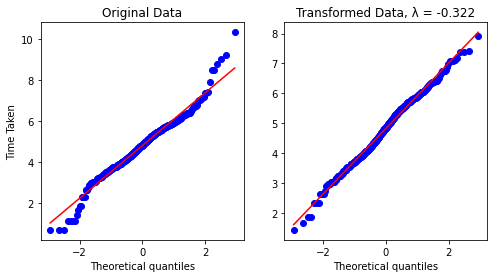

In [230]:
# step 4: IQR outlier removal
h6_nl_df_si_cleansed = remove_outlier_IQR(h6_nl_df_si, 'time_trans', 25, 75)
test_distribution(h6_nl_df_si['time_trans'], h6_nl_df_si_cleansed['time_trans'])
shapiro_wilk(h6_nl_df_si_cleansed['time_trans'])

Statistics=0.994, p=0.127
Sample looks Gaussian (fail to reject H0)


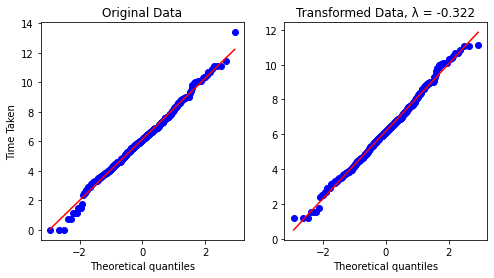

In [231]:
# step 4: IQR outlier removal
h6_m_df_si_cleansed = remove_outlier_IQR(h6_m_df_si, 'time_trans', 25, 75)
test_distribution(h6_m_df_si['time_trans'], h6_m_df_si_cleansed['time_trans'])
shapiro_wilk(h6_m_df_si_cleansed['time_trans'])

Statistics=0.994, p=0.076
Sample looks Gaussian (fail to reject H0)


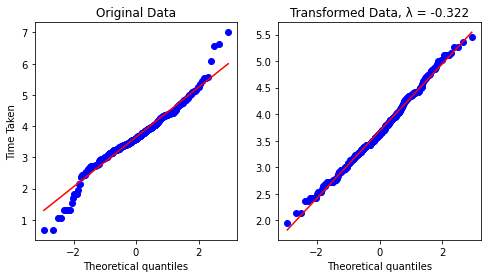

In [232]:
# step 4: IQR outlier removal
h6_nl_df_jp_cleansed = remove_outlier_IQR(h6_nl_df_jp, 'time_trans', 25, 75)
test_distribution(h6_nl_df_jp['time_trans'], h6_nl_df_jp_cleansed['time_trans'])
shapiro_wilk(h6_nl_df_jp_cleansed['time_trans'])

Statistics=0.991, p=0.010
Sample does not look Gaussian (reject H0)


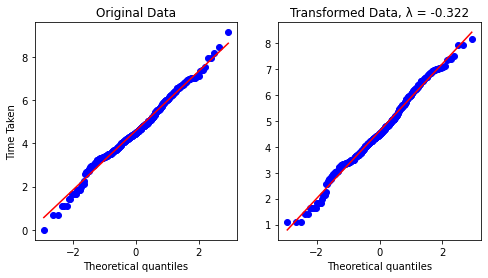

In [233]:
# step 4: IQR outlier removal
h6_m_df_jp_cleansed = remove_outlier_IQR(h6_m_df_jp, 'time_trans', 25, 75)
test_distribution(h6_m_df_jp['time_trans'], h6_m_df_jp_cleansed['time_trans'])
shapiro_wilk(h6_m_df_jp_cleansed['time_trans'])

Statistics=0.995, p=0.187
Sample looks Gaussian (fail to reject H0)


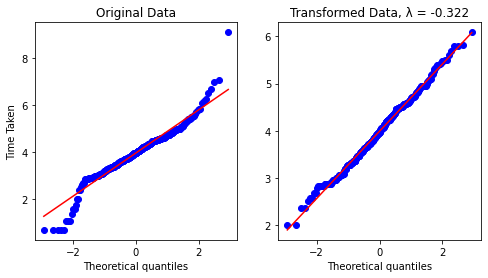

In [234]:
# step 4: IQR outlier removal
h6_nl_df_tl_cleansed = remove_outlier_IQR(h6_nl_df_tl, 'time_trans', 25, 75)
test_distribution(h6_nl_df_tl['time_trans'], h6_nl_df_tl_cleansed['time_trans'])
shapiro_wilk(h6_nl_df_tl_cleansed['time_trans'])

Statistics=0.989, p=0.002
Sample does not look Gaussian (reject H0)


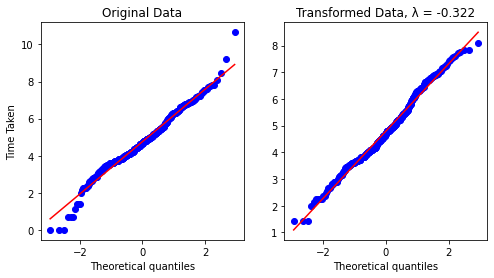

In [235]:
# step 4: IQR outlier removal
h6_m_df_tl_cleansed = remove_outlier_IQR(h6_m_df_tl, 'time_trans', 25, 75)
test_distribution(h6_m_df_tl['time_trans'], h6_m_df_tl_cleansed['time_trans'])
shapiro_wilk(h6_m_df_tl_cleansed['time_trans'])

Statistics=0.994, p=0.113
Sample looks Gaussian (fail to reject H0)


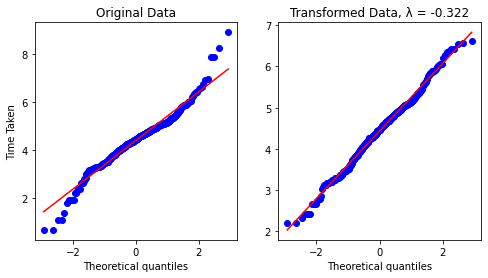

In [236]:
# step 4: IQR outlier removal
h6_nl_df_an_cleansed = remove_outlier_IQR(h6_nl_df_an, 'time_trans', 25, 75)
test_distribution(h6_nl_df_an['time_trans'], h6_nl_df_an_cleansed['time_trans'])
shapiro_wilk(h6_nl_df_an_cleansed['time_trans'])

Statistics=0.993, p=0.044
Sample does not look Gaussian (reject H0)


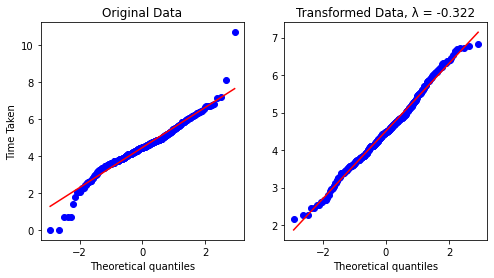

In [237]:
# step 4: IQR outlier removal
h6_m_df_an_cleansed = remove_outlier_IQR(h6_m_df_an, 'time_trans', 25, 75)
test_distribution(h6_m_df_an['time_trans'], h6_m_df_an_cleansed['time_trans'])
shapiro_wilk(h6_m_df_an_cleansed['time_trans'])

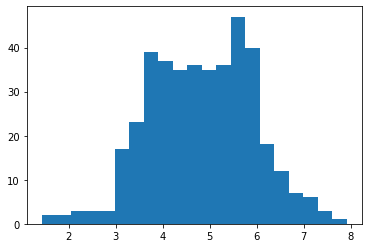

In [238]:
plot_hist(h6_nl_df_si_cleansed['time_trans'])

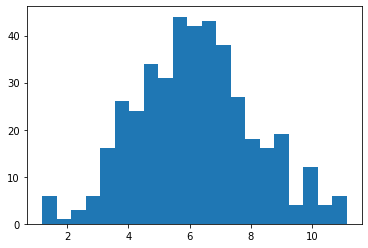

In [239]:
plot_hist(h6_m_df_si_cleansed['time_trans'])

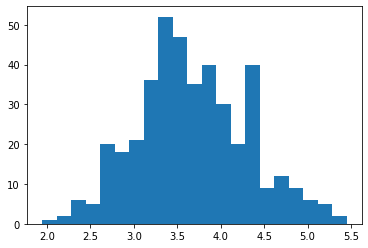

In [240]:
plot_hist(h6_nl_df_jp_cleansed['time_trans'])

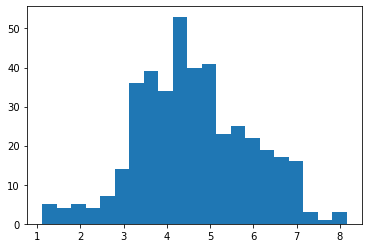

In [241]:
plot_hist(h6_m_df_jp_cleansed['time_trans'])

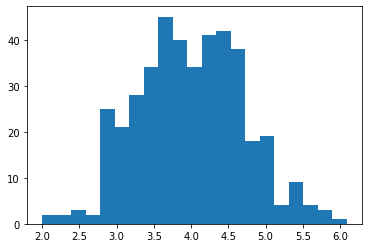

In [242]:
plot_hist(h6_nl_df_tl_cleansed['time_trans'])

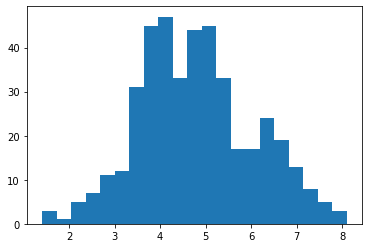

In [243]:
plot_hist(h6_m_df_tl_cleansed['time_trans'])

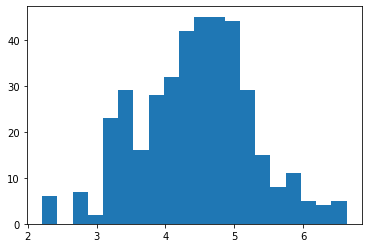

In [244]:
plot_hist(h6_nl_df_an_cleansed['time_trans'])

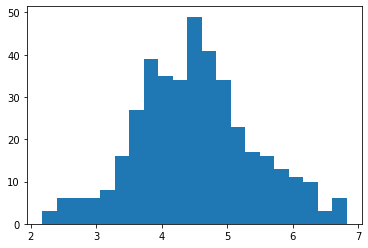

In [245]:
plot_hist(h6_m_df_an_cleansed['time_trans'])

In [246]:
h6_df = pd.DataFrame()
h6_df = h6_df.append(h6_m_df_si_cleansed)
h6_df = h6_df.append(h6_m_df_jp_cleansed)
h6_df = h6_df.append(h6_m_df_tl_cleansed)
h6_df = h6_df.append(h6_m_df_an_cleansed)
h6_df = h6_df.append(h6_nl_df_si_cleansed)
h6_df = h6_df.append(h6_nl_df_jp_cleansed)
h6_df = h6_df.append(h6_nl_df_tl_cleansed)
h6_df = h6_df.append(h6_nl_df_an_cleansed)
h6_df

,group,id,question,answer,time,confidence,correct,zoom_timers,drag_timers,highlight_timers,...,drag_interactions,highlight_interactions,slower_interactions,faster_interactions,slider_interactions,network_enc,task_type,task_entity,temporal_enc,time_trans
0,B,02f10e19-83e5-48a3-be35-5258e2e89c1a,m_t1_clique_si,3,754,1,true,[100],[],"[3400, 429, 8300, 428, 233, 214, 1599, 57199, ...",...,0,162,0,0,0,m,t1,clique,si,10.360080
4,B,02f10e19-83e5-48a3-be35-5258e2e89c1a,m_t1_single_si,2,40,5,true,[],[],"[1249, 360, 783, 332, 415, 518, 3727, 481, 114...",...,0,10,0,0,0,m,t1,single,si,4.697916
12,B,02f10e19-83e5-48a3-be35-5258e2e89c1a,m_t2_single_si,4,118,4,false,"[159, 153, 161, 393, 150, 159, 1020, 179]",[],"[364, 300, 230, 233, 261, 365, 227, 698, 200, ...",...,0,30,0,0,0,m,t2,single,si,6.544313
16,B,02f10e19-83e5-48a3-be35-5258e2e89c1a,m_t2_clique_si,5,294,1,false,"[806, 162, 164, 152, 153, 1356, 2122, 200, 391...",[],"[548, 333, 471, 329, 229, 615, 249, 361, 231, ...",...,0,49,0,0,0,m,t2,clique,si,8.311024
45,B,02f10e19-83e5-48a3-be35-5258e2e89c1a,m_t3_clique_si,5,57,3,true,"[732, 198, 929, 222, 280, 432, 272, 221, 514, ...","[3492, 3898, 3597, 3804]",[],...,4,0,6,0,0,m,t3,clique,si,5.274879
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3949,A,fd0eab90-ea5f-48cf-9796-8115762f1f51,nl_t3_clique_an,4,311,1,true,[],[],[],...,0,0,6,0,0,nl,t3,clique,an,5.834526
3958,A,fd0eab90-ea5f-48cf-9796-8115762f1f51,nl_t3_single_an,2,26,4,true,[],[],[],...,0,0,0,0,3,nl,t3,single,an,3.288476
3959,A,fd0eab90-ea5f-48cf-9796-8115762f1f51,nl_t3_single_an,2,374,4,true,[],[],[],...,0,0,0,0,3,nl,t3,single,an,6.025211
3961,A,fd0eab90-ea5f-48cf-9796-8115762f1f51,nl_t2_clique_an,5,125,2,false,[],[],[],...,0,0,0,0,3,nl,t2,clique,an,4.895232


In [247]:
print(h6_m_df_si_cleansed['time'].mean(), h6_m_df_jp_cleansed['time'].mean(), h6_m_df_tl_cleansed['time'].mean(), h6_m_df_an_cleansed['time'].mean())
print(h6_nl_df_si_cleansed['time'].mean(), h6_nl_df_jp_cleansed['time'].mean(), h6_nl_df_tl_cleansed['time'].mean(), h6_nl_df_an_cleansed['time'].mean())




154.53333333333333 140.13138686131387 168.87234042553192 160.62531017369727
105.25925925925925 99.54807692307692 110.97831325301205 108.83333333333333


In [248]:
h6_m_si_jp = pd.DataFrame()
h6_m_si_jp = h6_m_si_jp.append(h6_m_df_si_cleansed)
h6_m_si_jp = h6_m_si_jp.append(h6_m_df_jp_cleansed)
h6_m_si_jp

,group,id,question,answer,time,confidence,correct,zoom_timers,drag_timers,highlight_timers,...,drag_interactions,highlight_interactions,slower_interactions,faster_interactions,slider_interactions,network_enc,task_type,task_entity,temporal_enc,time_trans
0,B,02f10e19-83e5-48a3-be35-5258e2e89c1a,m_t1_clique_si,3,754,1,true,[100],[],"[3400, 429, 8300, 428, 233, 214, 1599, 57199, ...",...,0,162,0,0,0,m,t1,clique,si,10.360080
4,B,02f10e19-83e5-48a3-be35-5258e2e89c1a,m_t1_single_si,2,40,5,true,[],[],"[1249, 360, 783, 332, 415, 518, 3727, 481, 114...",...,0,10,0,0,0,m,t1,single,si,4.697916
12,B,02f10e19-83e5-48a3-be35-5258e2e89c1a,m_t2_single_si,4,118,4,false,"[159, 153, 161, 393, 150, 159, 1020, 179]",[],"[364, 300, 230, 233, 261, 365, 227, 698, 200, ...",...,0,30,0,0,0,m,t2,single,si,6.544313
16,B,02f10e19-83e5-48a3-be35-5258e2e89c1a,m_t2_clique_si,5,294,1,false,"[806, 162, 164, 152, 153, 1356, 2122, 200, 391...",[],"[548, 333, 471, 329, 229, 615, 249, 361, 231, ...",...,0,49,0,0,0,m,t2,clique,si,8.311024
45,B,02f10e19-83e5-48a3-be35-5258e2e89c1a,m_t3_clique_si,5,57,3,true,"[732, 198, 929, 222, 280, 432, 272, 221, 514, ...","[3492, 3898, 3597, 3804]",[],...,4,0,6,0,0,m,t3,clique,si,5.274879
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3922,A,fd0eab90-ea5f-48cf-9796-8115762f1f51,m_t1_single_jp,3,48,5,true,[],[],[],...,0,0,0,0,5,m,t1,single,jp,4.095394
3923,A,fd0eab90-ea5f-48cf-9796-8115762f1f51,m_t2_clique_jp,5,168,2,false,[],[],[],...,0,0,0,0,5,m,t2,clique,jp,5.521597
3934,A,fd0eab90-ea5f-48cf-9796-8115762f1f51,m_t3_single_jp,1,34,5,true,[],[],[],...,0,0,21,6,0,m,t3,single,jp,3.711764
3951,A,fd0eab90-ea5f-48cf-9796-8115762f1f51,m_t3_clique_jp,3,69,3,true,[],[],[],...,0,0,0,0,8,m,t3,clique,jp,4.503258


In [249]:
# H0: M_SI[time] == M_JP[time]
# H1: M_SI[time] !== M_JP[time]
mannwhitneyu(h6_m_df_si['time'], h6_m_df_jp['time'], alternative="greater") # 0.00000460934 << 0.05 -> reject H0 assume not equal

MannwhitneyuResult(statistic=97981.0, pvalue=0.004759311933461519)

160.79391100702577 151.00721153846155


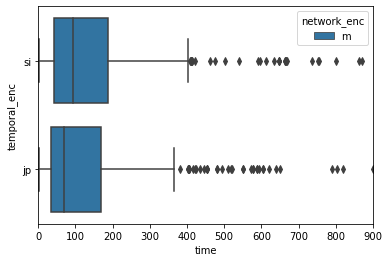

In [250]:
h6_boxplot_tmp = pd.DataFrame()
h6_boxplot_tmp = h6_boxplot_tmp.append(h6_m_df_si)
h6_boxplot_tmp = h6_boxplot_tmp.append(h6_m_df_jp)

ax = sns.boxplot(x='time', y='temporal_enc', hue="network_enc", data=h6_boxplot_tmp)
ax.set_xlim(0, 900)

print(h6_m_df_si['time'].mean(), h6_m_df_jp['time'].mean())

In [251]:
pg.pairwise_tukey(data=h6_m_si_jp, dv="time_trans", between="temporal_enc")

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,jp,si,4.608023,6.184249,-1.576226,0.114352,-13.783974,0.0,-0.955512


In [252]:
pg.anova(data=h6_m_si_jp, dv="time_trans", between="temporal_enc")

,Source,ddof1,ddof2,F,p-unc,np2
0,temporal_enc,1,829,189.997936,4.549997e-39,0.186456


In [253]:
pg.pairwise_ttests(data=h6_m_si_jp, dv="time", within="temporal_enc", subject="id", parametric=True, alpha=0.05, alternative="greater", padjust="bonf", correction=True, return_desc=True)

,Contrast,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
0,temporal_enc,jp,si,139.57577,83.121894,155.632808,81.808847,True,True,-1.533655,67.0,greater,0.935088,0.81,-0.193615


In [254]:
pg.ttest(h6_m_df_si['time'], h6_m_df_jp['time'], alternative="greater")

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.594402,810.878005,greater,0.276205,"[-17.33, inf]",0.041037,0.183,0.146943


In [255]:
pg.kruskal(data=h6_m_si_jp, dv="time", between="temporal_enc")

,Source,ddof1,H,p-unc
Kruskal,temporal_enc,1,7.667794,0.005622


In [256]:
h6_m_si_an = pd.DataFrame()
h6_m_si_an = h6_m_si_an.append(h6_m_df_si_cleansed)
h6_m_si_an = h6_m_si_an.append(h6_m_df_an_cleansed)
h6_m_si_an

,group,id,question,answer,time,confidence,correct,zoom_timers,drag_timers,highlight_timers,...,drag_interactions,highlight_interactions,slower_interactions,faster_interactions,slider_interactions,network_enc,task_type,task_entity,temporal_enc,time_trans
0,B,02f10e19-83e5-48a3-be35-5258e2e89c1a,m_t1_clique_si,3,754,1,true,[100],[],"[3400, 429, 8300, 428, 233, 214, 1599, 57199, ...",...,0,162,0,0,0,m,t1,clique,si,10.360080
4,B,02f10e19-83e5-48a3-be35-5258e2e89c1a,m_t1_single_si,2,40,5,true,[],[],"[1249, 360, 783, 332, 415, 518, 3727, 481, 114...",...,0,10,0,0,0,m,t1,single,si,4.697916
12,B,02f10e19-83e5-48a3-be35-5258e2e89c1a,m_t2_single_si,4,118,4,false,"[159, 153, 161, 393, 150, 159, 1020, 179]",[],"[364, 300, 230, 233, 261, 365, 227, 698, 200, ...",...,0,30,0,0,0,m,t2,single,si,6.544313
16,B,02f10e19-83e5-48a3-be35-5258e2e89c1a,m_t2_clique_si,5,294,1,false,"[806, 162, 164, 152, 153, 1356, 2122, 200, 391...",[],"[548, 333, 471, 329, 229, 615, 249, 361, 231, ...",...,0,49,0,0,0,m,t2,clique,si,8.311024
45,B,02f10e19-83e5-48a3-be35-5258e2e89c1a,m_t3_clique_si,5,57,3,true,"[732, 198, 929, 222, 280, 432, 272, 221, 514, ...","[3492, 3898, 3597, 3804]",[],...,4,0,6,0,0,m,t3,clique,si,5.274879
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3927,A,fd0eab90-ea5f-48cf-9796-8115762f1f51,m_t1_clique_an,2,144,3,true,[],[],[],...,0,0,11,8,0,m,t1,clique,an,4.845841
3933,A,fd0eab90-ea5f-48cf-9796-8115762f1f51,m_t3_single_an,4,129,4,true,[],[],[],...,0,0,21,6,0,m,t3,single,an,4.741223
3948,A,fd0eab90-ea5f-48cf-9796-8115762f1f51,m_t2_single_an,2,100,4,true,[],[],[],...,0,0,6,0,0,m,t2,single,an,4.498592
3952,A,fd0eab90-ea5f-48cf-9796-8115762f1f51,m_t3_clique_an,5,279,2,false,[],[],[],...,0,0,0,0,8,m,t3,clique,an,5.472401


In [257]:
# H0: M_SI[time] == M_AN[time]
# H1: M_SI[time] !== M_AN[time]
mannwhitneyu(h6_m_df_si['time'], h6_m_df_an['time'], alternative="two-sided") # 0.00000460934 << 0.05 -> reject H0 assume not equal

MannwhitneyuResult(statistic=85925.0, pvalue=0.3806953978809854)

160.62531017369727 154.53333333333333


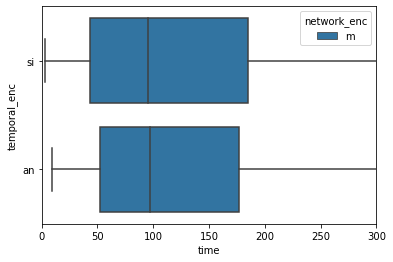

In [258]:
ax = sns.boxplot(x='time', y='temporal_enc', hue="network_enc", data=h6_m_si_an)
ax.set_xlim(0, 300)

print(h6_m_si_an[h6_m_si_an['temporal_enc'] == 'an']['time'].mean(), h6_m_si_an[h6_m_si_an['temporal_enc'] == 'si']['time'].mean())

In [259]:
pg.pairwise_tukey(data=h6_m_si_an, dv="time_trans", between="temporal_enc")

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,an,si,4.505936,6.184249,-1.678312,0.105609,-15.891702,1.773026e-13,-1.107124


In [260]:
pg.pairwise_ttests(data=h6_m_si_an, dv="time", within="temporal_enc", subject="id", parametric=True, alpha=0.05, alternative="greater", padjust="bonf", correction=True, return_desc=True)

,Contrast,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
0,temporal_enc,an,si,158.622199,91.153619,155.632808,81.808847,True,True,0.280886,67.0,greater,0.389832,0.277,0.034323


In [261]:
pg.ttest(h6_m_df_si['time'], h6_m_df_an['time'], alternative="two-sided", correction=True, confidence=0.95)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-1.069065,418.310374,two-sided,0.285657,"[-608.12, 179.66]",0.074476,0.135,0.19076


In [262]:
pg.kruskal(data=h6_m_si_an, dv="time", between="temporal_enc")

,Source,ddof1,H,p-unc
Kruskal,temporal_enc,1,1.183665,0.276611


In [263]:
pg.anova(data=h6_m_si_an, dv="time", between="temporal_enc")

,Source,ddof1,ddof2,F,p-unc,np2
0,temporal_enc,1,821,0.228879,0.632484,0.000279


In [264]:
h6_m_si_tl = pd.DataFrame()
h6_m_si_tl = h6_m_si_tl.append(h6_m_df_si_cleansed)
h6_m_si_tl = h6_m_si_tl.append(h6_m_df_tl_cleansed)
h6_m_si_tl

,group,id,question,answer,time,confidence,correct,zoom_timers,drag_timers,highlight_timers,...,drag_interactions,highlight_interactions,slower_interactions,faster_interactions,slider_interactions,network_enc,task_type,task_entity,temporal_enc,time_trans
0,B,02f10e19-83e5-48a3-be35-5258e2e89c1a,m_t1_clique_si,3,754,1,true,[100],[],"[3400, 429, 8300, 428, 233, 214, 1599, 57199, ...",...,0,162,0,0,0,m,t1,clique,si,10.360080
4,B,02f10e19-83e5-48a3-be35-5258e2e89c1a,m_t1_single_si,2,40,5,true,[],[],"[1249, 360, 783, 332, 415, 518, 3727, 481, 114...",...,0,10,0,0,0,m,t1,single,si,4.697916
12,B,02f10e19-83e5-48a3-be35-5258e2e89c1a,m_t2_single_si,4,118,4,false,"[159, 153, 161, 393, 150, 159, 1020, 179]",[],"[364, 300, 230, 233, 261, 365, 227, 698, 200, ...",...,0,30,0,0,0,m,t2,single,si,6.544313
16,B,02f10e19-83e5-48a3-be35-5258e2e89c1a,m_t2_clique_si,5,294,1,false,"[806, 162, 164, 152, 153, 1356, 2122, 200, 391...",[],"[548, 333, 471, 329, 229, 615, 249, 361, 231, ...",...,0,49,0,0,0,m,t2,clique,si,8.311024
45,B,02f10e19-83e5-48a3-be35-5258e2e89c1a,m_t3_clique_si,5,57,3,true,"[732, 198, 929, 222, 280, 432, 272, 221, 514, ...","[3492, 3898, 3597, 3804]",[],...,4,0,6,0,0,m,t3,clique,si,5.274879
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3931,A,fd0eab90-ea5f-48cf-9796-8115762f1f51,m_t1_single_tl,3,324,5,true,[],[],[],...,0,0,0,0,2,m,t1,single,tl,6.233090
3938,A,fd0eab90-ea5f-48cf-9796-8115762f1f51,m_t3_clique_tl,5,122,4,false,[],[],[],...,0,0,0,0,4,m,t3,clique,tl,5.113756
3943,A,fd0eab90-ea5f-48cf-9796-8115762f1f51,m_t2_clique_tl,5,62,2,false,[],[],[],...,0,0,0,0,5,m,t2,clique,tl,4.354385
3953,A,fd0eab90-ea5f-48cf-9796-8115762f1f51,m_t2_single_tl,4,141,5,true,[],[],[],...,0,0,0,0,3,m,t2,single,tl,5.277857


In [265]:
# H0: M_SI[time] == M_TL[time]
# H1: M_SI[time] !== M_TL[time]
mannwhitneyu(h6_m_df_si_cleansed['time'], h6_m_df_tl_cleansed['time'], alternative="two-sided") # 0.00000460934 << 0.05 -> reject H0 assume not equal

MannwhitneyuResult(statistic=90532.5, pvalue=0.6301645985033413)

168.87234042553192 154.53333333333333


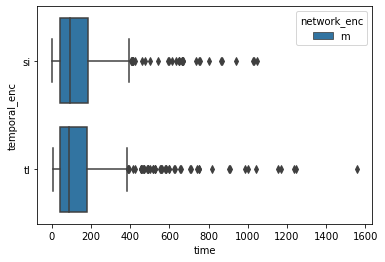

In [266]:
ax = sns.boxplot(x='time', y='temporal_enc', hue="network_enc", data=h6_m_si_tl)
# ax.set_xlim(0, 300)

print(h6_m_si_tl[h6_m_si_tl['temporal_enc'] == 'tl']['time'].mean(), h6_m_si_tl[h6_m_si_tl['temporal_enc'] == 'si']['time'].mean())

In [267]:
pg.pairwise_tukey(data=h6_m_si_tl, dv="time_trans", between="temporal_enc")

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,si,tl,6.184249,4.796648,1.387601,0.112096,12.378659,6.705747e-14,0.851932


In [268]:
pg.pairwise_ttests(data=h6_m_si_tl, dv="time", within="temporal_enc", subject="id", parametric=True, alpha=0.05, alternative="greater", padjust="bonf", correction=True, return_desc=True)

,Contrast,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
0,temporal_enc,si,tl,155.632808,81.808847,169.083613,97.482606,True,True,-1.351508,67.0,greater,0.909461,0.634,-0.148636


In [269]:
pg.ttest(h6_m_df_si_cleansed['time'], h6_m_df_tl_cleansed['time'], alternative="two-sided", correction=True, confidence=0.95)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-1.039379,808.239288,two-sided,0.298939,"[-41.42, 12.74]",0.071544,0.131,0.179485


In [270]:
pg.kruskal(data=h6_m_si_tl, dv="time", between="temporal_enc")

,Source,ddof1,H,p-unc
Kruskal,temporal_enc,1,0.231974,0.630064


In [271]:
pg.anova(data=h6_m_si_tl, dv="time", between="temporal_enc")

,Source,ddof1,ddof2,F,p-unc,np2
0,temporal_enc,1,841,1.078706,0.299286,0.001281


In [272]:
h6_m_si_nl_si = pd.DataFrame()
h6_m_si_nl_si = h6_m_si_nl_si.append(h6_m_df_si_cleansed)
h6_m_si_nl_si = h6_m_si_nl_si.append(h6_nl_df_si_cleansed)
h6_m_si_nl_si

,group,id,question,answer,time,confidence,correct,zoom_timers,drag_timers,highlight_timers,...,drag_interactions,highlight_interactions,slower_interactions,faster_interactions,slider_interactions,network_enc,task_type,task_entity,temporal_enc,time_trans
0,B,02f10e19-83e5-48a3-be35-5258e2e89c1a,m_t1_clique_si,3,754,1,true,[100],[],"[3400, 429, 8300, 428, 233, 214, 1599, 57199, ...",...,0,162,0,0,0,m,t1,clique,si,10.360080
4,B,02f10e19-83e5-48a3-be35-5258e2e89c1a,m_t1_single_si,2,40,5,true,[],[],"[1249, 360, 783, 332, 415, 518, 3727, 481, 114...",...,0,10,0,0,0,m,t1,single,si,4.697916
12,B,02f10e19-83e5-48a3-be35-5258e2e89c1a,m_t2_single_si,4,118,4,false,"[159, 153, 161, 393, 150, 159, 1020, 179]",[],"[364, 300, 230, 233, 261, 365, 227, 698, 200, ...",...,0,30,0,0,0,m,t2,single,si,6.544313
16,B,02f10e19-83e5-48a3-be35-5258e2e89c1a,m_t2_clique_si,5,294,1,false,"[806, 162, 164, 152, 153, 1356, 2122, 200, 391...",[],"[548, 333, 471, 329, 229, 615, 249, 361, 231, ...",...,0,49,0,0,0,m,t2,clique,si,8.311024
45,B,02f10e19-83e5-48a3-be35-5258e2e89c1a,m_t3_clique_si,5,57,3,true,"[732, 198, 929, 222, 280, 432, 272, 221, 514, ...","[3492, 3898, 3597, 3804]",[],...,4,0,6,0,0,m,t3,clique,si,5.274879
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3940,A,fd0eab90-ea5f-48cf-9796-8115762f1f51,nl_t1_clique_si,3,260,5,true,[],[],[],...,0,0,0,0,10,nl,t1,clique,si,6.428468
3947,A,fd0eab90-ea5f-48cf-9796-8115762f1f51,nl_t1_single_si,3,35,5,true,[],[],[],...,0,0,0,0,5,nl,t1,single,si,3.897759
3962,A,fd0eab90-ea5f-48cf-9796-8115762f1f51,nl_t2_single_si,1,25,4,false,[],[],[],...,0,0,0,0,3,nl,t2,single,si,3.497897
3966,A,fd0eab90-ea5f-48cf-9796-8115762f1f51,nl_t3_single_si,1,38,4,true,[],[],[],...,0,0,0,0,23,nl,t3,single,si,3.996537


In [273]:
# H0: M_SI[time] == NL_SI[time]
# H1: M_SI[time] !== NL_SI[time]
mannwhitneyu(h6_m_df_si['time'], h6_nl_df_si['time'], alternative="greater") # 0.00000460934 << 0.05 -> reject H0 assume not equal

MannwhitneyuResult(statistic=98703.0, pvalue=0.003829620662418091)

105.25925925925925 154.53333333333333


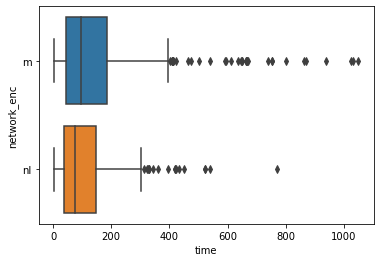

In [274]:
ax = sns.boxplot(x='time', y='network_enc', data=h6_m_si_nl_si)
# ax.set_xlim(0, 300)

print(h6_m_si_nl_si[h6_m_si_nl_si['network_enc'] == 'nl']['time'].mean(), h6_m_si_nl_si[h6_m_si_nl_si['network_enc'] == 'm']['time'].mean())

In [275]:
pg.pairwise_tukey(data=h6_m_si_nl_si, dv="time_trans", between="network_enc")

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,m,nl,6.184249,4.82793,1.356319,0.109727,12.360839,0.0,0.860056


In [276]:
pg.pairwise_ttests(data=h6_m_si_nl_si, dv="time", within="network_enc", subject="id", parametric=True, alpha=0.05, alternative="greater", padjust="bonf", correction=True, return_desc=True)

,Contrast,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
0,network_enc,m,nl,155.632808,81.808847,104.551085,42.632585,True,True,6.600646,67.0,greater,3.900550e-09,3.041e+06,0.778696


In [277]:
pg.ttest(h6_m_df_si_cleansed['time'], h6_nl_df_si_cleansed['time'], alternative="greater", correction=True, confidence=0.95)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,4.973278,646.007136,greater,4.223688e-07,"[32.95, inf]",0.342875,2.513e+04,0.999471


In [278]:
pg.kruskal(data=h6_m_si_nl_si, dv="time", between="network_enc")

,Source,ddof1,H,p-unc
Kruskal,network_enc,1,8.345785,0.003866


In [279]:
pg.anova(data=h6_m_si_nl_si, dv="time", between="network_enc")

,Source,ddof1,ddof2,F,p-unc,np2
0,network_enc,1,823,24.239346,0.000001,0.02861


In [280]:
h6_m_si_nl_jp = pd.DataFrame()
h6_m_si_nl_jp = h6_m_si_nl_jp.append(h6_m_df_si_cleansed)
h6_m_si_nl_jp = h6_m_si_nl_jp.append(h6_nl_df_jp_cleansed)
h6_m_si_nl_jp

,group,id,question,answer,time,confidence,correct,zoom_timers,drag_timers,highlight_timers,...,drag_interactions,highlight_interactions,slower_interactions,faster_interactions,slider_interactions,network_enc,task_type,task_entity,temporal_enc,time_trans
0,B,02f10e19-83e5-48a3-be35-5258e2e89c1a,m_t1_clique_si,3,754,1,true,[100],[],"[3400, 429, 8300, 428, 233, 214, 1599, 57199, ...",...,0,162,0,0,0,m,t1,clique,si,10.360080
4,B,02f10e19-83e5-48a3-be35-5258e2e89c1a,m_t1_single_si,2,40,5,true,[],[],"[1249, 360, 783, 332, 415, 518, 3727, 481, 114...",...,0,10,0,0,0,m,t1,single,si,4.697916
12,B,02f10e19-83e5-48a3-be35-5258e2e89c1a,m_t2_single_si,4,118,4,false,"[159, 153, 161, 393, 150, 159, 1020, 179]",[],"[364, 300, 230, 233, 261, 365, 227, 698, 200, ...",...,0,30,0,0,0,m,t2,single,si,6.544313
16,B,02f10e19-83e5-48a3-be35-5258e2e89c1a,m_t2_clique_si,5,294,1,false,"[806, 162, 164, 152, 153, 1356, 2122, 200, 391...",[],"[548, 333, 471, 329, 229, 615, 249, 361, 231, ...",...,0,49,0,0,0,m,t2,clique,si,8.311024
45,B,02f10e19-83e5-48a3-be35-5258e2e89c1a,m_t3_clique_si,5,57,3,true,"[732, 198, 929, 222, 280, 432, 272, 221, 514, ...","[3492, 3898, 3597, 3804]",[],...,4,0,6,0,0,m,t3,clique,si,5.274879
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3944,A,fd0eab90-ea5f-48cf-9796-8115762f1f51,nl_t3_single_jp,1,46,5,true,[],[],[],...,0,0,0,0,5,nl,t3,single,jp,3.393322
3945,A,fd0eab90-ea5f-48cf-9796-8115762f1f51,nl_t3_single_jp,1,278,5,true,[],[],[],...,0,0,0,0,5,nl,t3,single,jp,4.720978
3968,A,fd0eab90-ea5f-48cf-9796-8115762f1f51,nl_t2_clique_jp,6,47,1,false,[],[],[],...,0,0,0,0,23,nl,t2,clique,jp,3.410119
3969,A,fd0eab90-ea5f-48cf-9796-8115762f1f51,nl_t3_clique_jp,4,28,2,false,[],[],[],...,0,0,0,0,23,nl,t3,clique,jp,2.999059


In [281]:
# H0: M_SI[time] == NL_JP[time] 0.00000327 << 0.0065
# H1: M_SI[time] !== NL_JP[time]
mannwhitneyu(h6_m_df_si_cleansed['time'], h6_nl_df_jp_cleansed['time'], alternative="greater") # 0.00000460934 << 0.05 -> reject H0 assume not equal

MannwhitneyuResult(statistic=103308.0, pvalue=2.4576961934370083e-06)

154.53333333333333 99.54807692307692


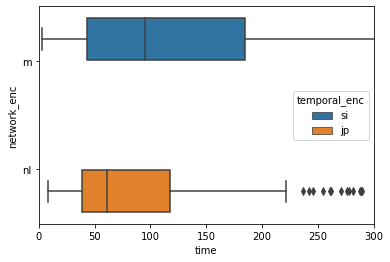

In [282]:
ax = sns.boxplot(x='time', y='network_enc', hue="temporal_enc", data=h6_m_si_nl_jp)
ax.set_xlim(0, 300)

print(h6_m_df_si_cleansed['time'].mean(), h6_nl_df_jp_cleansed['time'].mean())

In [283]:
pg.ttest(h6_m_df_si_cleansed['time'], h6_nl_df_jp_cleansed['time'], alternative="greater", correction=True, confidence=0.95)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,5.414284,687.059456,greater,4.256897e-08,"[38.26, inf]",0.373674,2.235e+05,0.999913


In [284]:
pg.pairwise_ttests(data=h6_m_si_nl_jp, dv="time", within="network_enc", subject="id", parametric=True, alpha=0.05, alternative="greater", padjust="bonf", correction=True, return_desc=True)

,Contrast,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
0,network_enc,m,nl,155.632808,81.808847,97.899702,50.126069,True,True,6.834501,67.0,greater,1.496346e-09,7.581e+06,0.846211


In [285]:
pg.kruskal(data=h6_m_si_nl_jp, dv="time", between="network_enc")

,Source,ddof1,H,p-unc
Kruskal,network_enc,1,20.871284,0.000005


In [286]:
pg.anova(data=h6_m_si_nl_jp, dv="time", between="network_enc")

,Source,ddof1,ddof2,F,p-unc,np2
0,network_enc,1,834,29.182486,8.598326e-08,0.033808


In [287]:
pg.pairwise_tukey(data=h6_m_si_nl_jp, dv="time_trans", between="network_enc")

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,m,nl,6.184249,3.680615,2.503634,0.099466,25.170786,0.0,1.739553


In [288]:
h6_m_si_nl_an = pd.DataFrame()
h6_m_si_nl_an = h6_m_si_nl_an.append(h6_m_df_si_cleansed)
h6_m_si_nl_an = h6_m_si_nl_an.append(h6_nl_df_an_cleansed)
h6_m_si_nl_an

,group,id,question,answer,time,confidence,correct,zoom_timers,drag_timers,highlight_timers,...,drag_interactions,highlight_interactions,slower_interactions,faster_interactions,slider_interactions,network_enc,task_type,task_entity,temporal_enc,time_trans
0,B,02f10e19-83e5-48a3-be35-5258e2e89c1a,m_t1_clique_si,3,754,1,true,[100],[],"[3400, 429, 8300, 428, 233, 214, 1599, 57199, ...",...,0,162,0,0,0,m,t1,clique,si,10.360080
4,B,02f10e19-83e5-48a3-be35-5258e2e89c1a,m_t1_single_si,2,40,5,true,[],[],"[1249, 360, 783, 332, 415, 518, 3727, 481, 114...",...,0,10,0,0,0,m,t1,single,si,4.697916
12,B,02f10e19-83e5-48a3-be35-5258e2e89c1a,m_t2_single_si,4,118,4,false,"[159, 153, 161, 393, 150, 159, 1020, 179]",[],"[364, 300, 230, 233, 261, 365, 227, 698, 200, ...",...,0,30,0,0,0,m,t2,single,si,6.544313
16,B,02f10e19-83e5-48a3-be35-5258e2e89c1a,m_t2_clique_si,5,294,1,false,"[806, 162, 164, 152, 153, 1356, 2122, 200, 391...",[],"[548, 333, 471, 329, 229, 615, 249, 361, 231, ...",...,0,49,0,0,0,m,t2,clique,si,8.311024
45,B,02f10e19-83e5-48a3-be35-5258e2e89c1a,m_t3_clique_si,5,57,3,true,"[732, 198, 929, 222, 280, 432, 272, 221, 514, ...","[3492, 3898, 3597, 3804]",[],...,4,0,6,0,0,m,t3,clique,si,5.274879
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3949,A,fd0eab90-ea5f-48cf-9796-8115762f1f51,nl_t3_clique_an,4,311,1,true,[],[],[],...,0,0,6,0,0,nl,t3,clique,an,5.834526
3958,A,fd0eab90-ea5f-48cf-9796-8115762f1f51,nl_t3_single_an,2,26,4,true,[],[],[],...,0,0,0,0,3,nl,t3,single,an,3.288476
3959,A,fd0eab90-ea5f-48cf-9796-8115762f1f51,nl_t3_single_an,2,374,4,true,[],[],[],...,0,0,0,0,3,nl,t3,single,an,6.025211
3961,A,fd0eab90-ea5f-48cf-9796-8115762f1f51,nl_t2_clique_an,5,125,2,false,[],[],[],...,0,0,0,0,3,nl,t2,clique,an,4.895232


In [289]:
# H0: M_SI[time] == NL_AN[time]
# H1: M_SI[time] !== NL_AN[time]
mannwhitneyu(h6_m_df_si_cleansed['time'], h6_nl_df_an_cleansed['time'], alternative="greater") # 0.00000460934 << 0.05 -> reject H0 assume not equal

MannwhitneyuResult(statistic=90327.5, pvalue=0.016590958156429844)

154.53333333333333 108.83333333333333


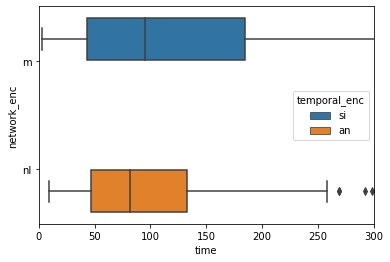

In [290]:
ax = sns.boxplot(x='time', y='network_enc', hue="temporal_enc", data=h6_m_si_nl_an)
ax.set_xlim(0, 300)

print(h6_m_df_si_cleansed['time'].mean(), h6_nl_df_an_cleansed['time'].mean())

In [291]:
pg.ttest(h6_m_df_si_cleansed['time'], h6_nl_df_an_cleansed['time'], alternative="greater", correction=True, confidence=0.95)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,4.555151,664.579051,greater,0.000003,"[29.17, inf]",0.314167,3731.117,0.997721


In [292]:
pg.pairwise_ttests(data=h6_m_si_nl_an, dv="time", within="network_enc", subject="id", parametric=True, alpha=0.05, alternative="greater", padjust="bonf", correction=True, return_desc=True)

,Contrast,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
0,network_enc,m,nl,155.632808,81.808847,107.335749,43.892853,True,True,5.016752,67.0,greater,0.000002,8126.307,0.731574


In [293]:
pg.kruskal(data=h6_m_si_nl_an, dv="time", between="network_enc")

,Source,ddof1,H,p-unc
Kruskal,network_enc,1,4.537001,0.03317


In [294]:
pg.anova(data=h6_m_si_nl_an, dv="time", between="network_enc")

,Source,ddof1,ddof2,F,p-unc,np2
0,network_enc,1,814,20.117504,0.000008,0.024118


In [295]:
pg.pairwise_tukey(data=h6_m_si_nl_an, dv="time_trans", between="network_enc")

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,m,nl,6.184249,4.431884,1.752365,0.104822,16.717545,0.0,1.16989


In [296]:
h6_m_si_nl_tl = pd.DataFrame()
h6_m_si_nl_tl = h6_m_si_nl_tl.append(h6_m_df_si_cleansed)
h6_m_si_nl_tl = h6_m_si_nl_tl.append(h6_nl_df_tl_cleansed)
h6_m_si_nl_tl

,group,id,question,answer,time,confidence,correct,zoom_timers,drag_timers,highlight_timers,...,drag_interactions,highlight_interactions,slower_interactions,faster_interactions,slider_interactions,network_enc,task_type,task_entity,temporal_enc,time_trans
0,B,02f10e19-83e5-48a3-be35-5258e2e89c1a,m_t1_clique_si,3,754,1,true,[100],[],"[3400, 429, 8300, 428, 233, 214, 1599, 57199, ...",...,0,162,0,0,0,m,t1,clique,si,10.360080
4,B,02f10e19-83e5-48a3-be35-5258e2e89c1a,m_t1_single_si,2,40,5,true,[],[],"[1249, 360, 783, 332, 415, 518, 3727, 481, 114...",...,0,10,0,0,0,m,t1,single,si,4.697916
12,B,02f10e19-83e5-48a3-be35-5258e2e89c1a,m_t2_single_si,4,118,4,false,"[159, 153, 161, 393, 150, 159, 1020, 179]",[],"[364, 300, 230, 233, 261, 365, 227, 698, 200, ...",...,0,30,0,0,0,m,t2,single,si,6.544313
16,B,02f10e19-83e5-48a3-be35-5258e2e89c1a,m_t2_clique_si,5,294,1,false,"[806, 162, 164, 152, 153, 1356, 2122, 200, 391...",[],"[548, 333, 471, 329, 229, 615, 249, 361, 231, ...",...,0,49,0,0,0,m,t2,clique,si,8.311024
45,B,02f10e19-83e5-48a3-be35-5258e2e89c1a,m_t3_clique_si,5,57,3,true,"[732, 198, 929, 222, 280, 432, 272, 221, 514, ...","[3492, 3898, 3597, 3804]",[],...,4,0,6,0,0,m,t3,clique,si,5.274879
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3939,A,fd0eab90-ea5f-48cf-9796-8115762f1f51,nl_t1_clique_tl,1,55,2,true,[],[],[],...,0,0,0,0,10,nl,t1,clique,tl,3.714768
3942,A,fd0eab90-ea5f-48cf-9796-8115762f1f51,nl_t1_single_tl,3,49,3,true,[],[],[],...,0,0,0,0,9,nl,t1,single,tl,3.615482
3950,A,fd0eab90-ea5f-48cf-9796-8115762f1f51,nl_t3_clique_tl,5,84,4,false,[],[],[],...,0,0,0,0,8,nl,t3,clique,tl,4.075028
3954,A,fd0eab90-ea5f-48cf-9796-8115762f1f51,nl_t3_single_tl,2,37,5,true,[],[],[],...,0,0,0,0,7,nl,t3,single,tl,3.372196


In [297]:
# H0: M_SI[time] == NL_TL[time]
# H1: M_SI[time] !== NL_TL[time]
mannwhitneyu(h6_m_df_si_cleansed['time'], h6_nl_df_tl_cleansed['time'], alternative="greater") # 0.00000460934 << 0.05 -> reject H0 assume not equal

MannwhitneyuResult(statistic=96271.0, pvalue=0.004430357522683418)

154.53333333333333 110.97831325301205


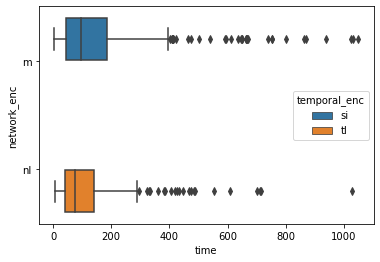

In [298]:
ax = sns.boxplot(x='time', y='network_enc', hue="temporal_enc", data=h6_m_si_nl_tl)
# ax.set_xlim(0, 300)

print(h6_m_df_si_cleansed['time'].mean(), h6_nl_df_tl_cleansed['time'].mean())

In [299]:
pg.ttest(h6_m_df_si_cleansed['time'], h6_nl_df_tl_cleansed['time'], alternative="greater", correction=True, confidence=0.95)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,4.198464,718.046658,greater,0.000015,"[26.47, inf]",0.289878,825.375,0.994455


In [300]:
pg.pairwise_ttests(data=h6_m_si_nl_tl, dv="time", within="network_enc", subject="id", parametric=True, alpha=0.05, alternative="greater", padjust="bonf", correction=True, return_desc=True)

,Contrast,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
0,network_enc,m,nl,155.632808,81.808847,108.471289,51.620747,True,True,5.480419,67.0,greater,3.461198e-07,4.33e+04,0.68562


In [301]:
pg.kruskal(data=h6_m_si_nl_tl, dv="time", between="network_enc")

,Source,ddof1,H,p-unc
Kruskal,network_enc,1,6.851439,0.008857


In [302]:
pg.anova(data=h6_m_si_nl_tl, dv="time", between="network_enc")

,Source,ddof1,ddof2,F,p-unc,np2
0,network_enc,1,833,17.54043,0.000031,0.020623


In [303]:
pg.pairwise_tukey(data=h6_m_si_nl_tl, dv="time_trans", between="network_enc")

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,m,nl,6.184249,3.991082,2.193166,0.100798,21.758117,0.0,1.504612


true     0.611241
false    0.388759
Name: correct, dtype: float64


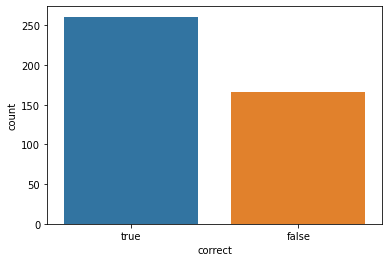

In [304]:
# M SI
count_plot(h6_m_df_si, 'correct')


# check percentage of correct
print(h6_m_df_si['correct'].value_counts()/len(h6_m_df_si))

true     0.641827
false    0.358173
Name: correct, dtype: float64


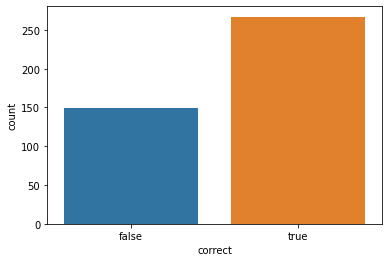

In [305]:
# M JP
count_plot(h6_m_df_jp, 'correct')

# check percentage of correct
print(h6_m_df_jp['correct'].value_counts()/len(h6_m_df_jp))

true     0.664303
false    0.335697
Name: correct, dtype: float64


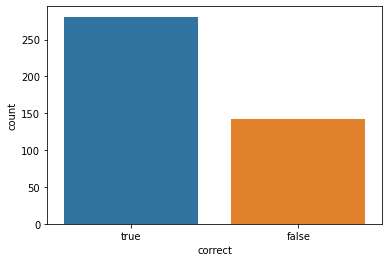

In [306]:
# M TL
count_plot(h6_m_df_tl_cleansed, 'correct')

# check percentage of correct
print(h6_m_df_tl_cleansed['correct'].value_counts()/len(h6_m_df_tl_cleansed))

true     0.655087
false    0.344913
Name: correct, dtype: float64


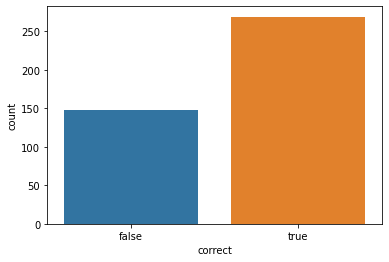

In [307]:
# M AN
count_plot(h6_m_df_an, 'correct')

# check percentage of correct
print(h6_m_si_an.query('temporal_enc=="an"')['correct'].value_counts()/len(h6_m_si_an.query('temporal_enc=="an"')))

true     0.62963
false    0.37037
Name: correct, dtype: float64


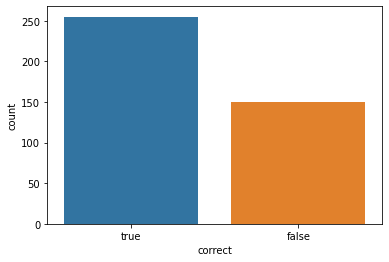

In [308]:
# NL SI
count_plot(h6_nl_df_si_cleansed, 'correct')

# check percentage of correct
print(h6_nl_df_si_cleansed['correct'].value_counts()/len(h6_nl_df_si_cleansed))

true     0.646635
false    0.353365
Name: correct, dtype: float64


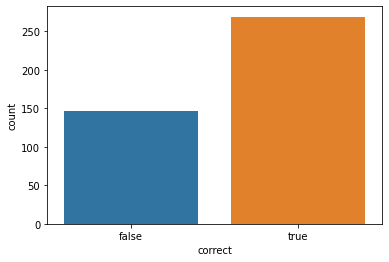

In [309]:
# NL JP
count_plot(h6_nl_df_jp_cleansed, 'correct')

# check percentage of correct
print(h6_nl_df_jp_cleansed['correct'].value_counts()/len(h6_nl_df_jp_cleansed))

true     0.518072
false    0.481928
Name: correct, dtype: float64


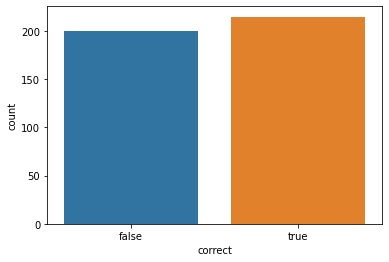

In [310]:
# NL TL
count_plot(h6_nl_df_tl_cleansed, 'correct')

# check percentage of correct
print(h6_nl_df_tl_cleansed['correct'].value_counts()/len(h6_nl_df_tl_cleansed))

true     0.714646
false    0.285354
Name: correct, dtype: float64


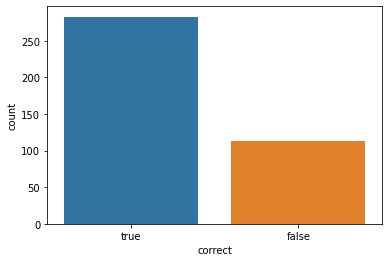

In [311]:
# NL AN
count_plot(h6_nl_df_an_cleansed, 'correct')

# check percentage of correct
print(h6_nl_df_an_cleansed['correct'].value_counts()/len(h6_nl_df_an_cleansed))

In [312]:
success_m_si, fail_m_si = h6_m_df_si_cleansed['correct'].value_counts()
success_m_jp, fail_m_jp = h6_m_df_jp_cleansed['correct'].value_counts()
success_m_an, fail_m_an = h6_m_df_an_cleansed['correct'].value_counts()
success_m_tl, fail_m_tl = h6_m_df_tl_cleansed['correct'].value_counts()

success_nl_si, fail_nl_si = h6_nl_df_si_cleansed['correct'].value_counts()
success_nl_jp, fail_nl_jp = h6_nl_df_jp_cleansed['correct'].value_counts()
success_nl_tl, fail_nl_tl = h6_nl_df_tl_cleansed['correct'].value_counts()
success_nl_an, fail_nl_an = h6_nl_df_an_cleansed['correct'].value_counts()

num_trial_m_si = len(h6_m_df_si_cleansed)
num_trial_m_jp = len(h6_m_df_jp_cleansed)
num_trial_m_tl = len(h6_m_df_tl_cleansed)
num_trial_m_an = len(h6_m_df_an_cleansed)

num_trial_nl_si = len(h6_nl_df_si_cleansed)
num_trial_nl_jp = len(h6_nl_df_jp_cleansed)
num_trial_nl_tl = len(h6_nl_df_tl_cleansed)
num_trial_nl_an = len(h6_nl_df_an_cleansed)


success_prob_m_si, fail_prob_m_si = h6_m_df_si_cleansed['correct'].value_counts()/len(h6_m_df_si_cleansed)
success_prob_m_jp, fail_prob_m_jp = h6_m_df_jp_cleansed['correct'].value_counts()/len(h6_m_df_jp_cleansed)
success_prob_m_tl, fail_prob_m_tl = h6_m_df_tl_cleansed['correct'].value_counts()/len(h6_m_df_tl_cleansed)
success_prob_m_an, fail_prob_m_an = h6_m_df_an_cleansed['correct'].value_counts()/len(h6_m_df_an_cleansed)

success_prob_nl_si, fail_prob_nl_si = h6_nl_df_si_cleansed['correct'].value_counts()/len(h6_nl_df_si_cleansed)
success_prob_nl_jp, fail_prob_nl_jp = h6_nl_df_jp_cleansed['correct'].value_counts()/len(h6_nl_df_jp_cleansed)
success_prob_nl_tl, fail_prob_nl_tl = h6_nl_df_tl_cleansed['correct'].value_counts()/len(h6_nl_df_tl_cleansed)
success_prob_nl_an, fail_prob_nl_an = h6_nl_df_an_cleansed['correct'].value_counts()/len(h6_nl_df_an_cleansed)

In [313]:
binomtest(success_m_si, num_trial_m_si, p=success_prob_m_jp, alternative="greater")

BinomTestResult(k=257, n=420, alternative='greater', proportion_estimate=0.611904761904762, pvalue=0.8932011820811855)

In [314]:
binomtest(success_m_si, num_trial_m_si, p=success_prob_m_tl, alternative="two-sided")

BinomTestResult(k=257, n=420, alternative='two-sided', proportion_estimate=0.611904761904762, pvalue=0.026177343710627497)

In [315]:
binomtest(success_m_si, num_trial_m_si, p=success_prob_m_an, alternative="two-sided")

BinomTestResult(k=257, n=420, alternative='two-sided', proportion_estimate=0.611904761904762, pvalue=0.06468350988063128)

In [316]:
binomtest(success_m_si, num_trial_m_si, p=success_prob_nl_si, alternative="greater")

BinomTestResult(k=257, n=420, alternative='greater', proportion_estimate=0.611904761904762, pvalue=0.7893751802047982)

In [317]:
binomtest(success_m_si, num_trial_m_si, p=success_prob_nl_jp, alternative="greater")

BinomTestResult(k=257, n=420, alternative='greater', proportion_estimate=0.611904761904762, pvalue=0.9374542913099333)

In [318]:
binomtest(success_m_si, num_trial_m_si, p=success_prob_nl_tl, alternative="greater")

BinomTestResult(k=257, n=420, alternative='greater', proportion_estimate=0.611904761904762, pvalue=6.725950964259131e-05)

In [319]:
binomtest(success_m_si, num_trial_m_si, p=success_prob_nl_an, alternative="less")

BinomTestResult(k=257, n=420, alternative='less', proportion_estimate=0.611904761904762, pvalue=3.727370419738113e-06)

## Preferences

In [320]:
preferences_data = pd.read_csv('feedback_results.csv', index_col=0)
preferences_df = df = pd.DataFrame(preferences_data) 
preferences_df.head()

,group,id,NL-JP,NL-SI,NL-TL,NL-AN,M-JP,M-SI,M-TL,M-AN,comments
0,B,02f10e19-83e5-48a3-be35-5258e2e89c1a,4.0,2,5,1,4.0,3.0,5,1.0,Most of the time with the Superimposition tech...
1,B,031203103,5.0,4,5,1,3.0,4.0,3,1.0,"I really hated the animations, it's not possib..."
2,B,037605fd-b893-4885-b04a-8e9c2bed8a1a,5.0,2,3,1,3.0,5.0,2,1.0,The Superimposition was sometimes hard to read...
3,B,0befb8c4-1848-4e6e-8ab6-ffbaac29d2c9,4.0,3,5,2,4.0,5.0,5,1.0,it depends if I am searching for cliques (more...
4,B,0d215911-e63c-46ad-a063-653b709f8253,5.0,2,4,2,3.0,4.0,4,1.0,Animations seemed really impractical for the e...


In [321]:
## 1 NL-TL  
## 2 M-TL  
## 3 NL-JP  
## 4 M-SI  
## 5 M-JP  
## 6 NL-SI  
## 7 NL-AN 
## 8 M-AN

In [322]:
preferences_df['NL-JP'].mean()

3.3733333333333335

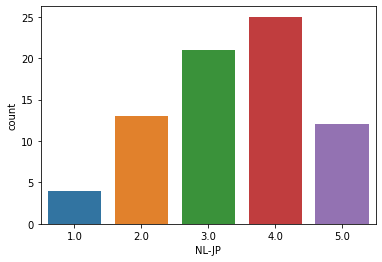

In [323]:
count_plot(preferences_df, col="NL-JP")

In [324]:
preferences_df['NL-SI'].mean()

2.789473684210526

In [325]:
preferences_df['NL-TL'].mean()

4.2631578947368425

In [326]:
preferences_df['NL-AN'].mean()

2.263157894736842

In [327]:
preferences_df['M-JP'].mean()

2.945945945945946

In [328]:
preferences_df['M-SI'].mean()

3.1866666666666665

In [329]:
preferences_df['M-TL'].mean()

3.3815789473684212

In [330]:
preferences_df['M-AN'].mean()

1.68

## Error Rate

In [331]:
ids = original_df['id'].unique()

cols=['Matrix', 'Node-Link', 'Superimposition', 'Juxtaposition', 'Timeline', 'Animation']

task = 't1'
num_m = len(original_df.query('network_enc=="m"')['question'].unique())
num_nl = len(original_df.query('network_enc=="nl"')['question'].unique())

num_si = len(original_df.query('temporal_enc=="si"')['question'].unique())
num_jp = len(original_df.query('temporal_enc=="jp"')['question'].unique())
num_tl = len(original_df.query('temporal_enc=="tl"')['question'].unique())
num_an = len(original_df.query('temporal_enc=="an"')['question'].unique())

rows = []

for id in ids:
    error_rate_m = original_df[original_df['id'] == id].query('network_enc=="m" & correct=="false"')['id'].count()/num_m
    error_rate_nl = original_df[original_df['id'] == id].query('network_enc=="nl" & correct=="false"')['id'].count()/num_nl #of nodelink questions

    error_rate_si = original_df[original_df['id'] == id].query('temporal_enc=="si" & correct=="false"')['id'].count()/num_si #of superimposition questions
    error_rate_jp = original_df[original_df['id'] == id].query('temporal_enc=="jp" & correct=="false"')['id'].count()/num_jp #of juxtaposition questions
    error_rate_tl = original_df[original_df['id'] == id].query('temporal_enc=="tl" & correct=="false"')['id'].count()/num_tl #of timeline questions
    error_rate_an = original_df[original_df['id'] == id].query('temporal_enc=="an" & correct=="false"')['id'].count()/num_an #of animation questions
    rows.append([error_rate_m, error_rate_nl, error_rate_si, error_rate_jp, error_rate_tl, error_rate_an])
error_rate_all_df = pd.DataFrame(rows, columns=cols)
error_rate_all_df

,Matrix,Node-Link,Superimposition,Juxtaposition,Timeline,Animation
0,0.416667,0.458333,0.416667,0.500000,0.333333,0.500000
1,0.166667,0.250000,0.166667,0.166667,0.416667,0.083333
2,0.041667,0.291667,0.083333,0.250000,0.250000,0.083333
3,0.708333,0.500000,0.750000,0.416667,0.666667,0.583333
4,0.166667,0.333333,0.166667,0.500000,0.333333,0.000000
...,...,...,...,...,...,...
63,0.250000,0.500000,0.416667,0.416667,0.583333,0.083333
64,0.416667,0.291667,0.333333,0.333333,0.333333,0.416667
65,0.166667,0.250000,0.166667,0.250000,0.333333,0.083333
66,0.208333,0.250000,0.166667,0.250000,0.250000,0.250000


In [332]:
ids = original_df['id'].unique()

cols=['Matrix', 'Node-Link', 'Superimposition', 'Juxtaposition', 'Timeline', 'Animation']

task = 't3'
num_m = len(original_df.query('network_enc=="m" & task_type==@task')['question'].unique())
num_nl = len(original_df.query('network_enc=="nl" & task_type==@task')['question'].unique())

num_si = len(original_df.query('temporal_enc=="si" & task_type==@task')['question'].unique())
num_jp = len(original_df.query('temporal_enc=="jp" & task_type==@task')['question'].unique())
num_tl = len(original_df.query('temporal_enc=="tl" & task_type==@task')['question'].unique())
num_an = len(original_df.query('temporal_enc=="an" & task_type==@task')['question'].unique())

rows = []

for id in ids:
    error_rate_m = original_df[original_df['id'] == id].query('network_enc=="m" & correct=="false" & task_type==@task')['id'].count()/num_m
    error_rate_nl = original_df[original_df['id'] == id].query('network_enc=="nl" & correct=="false" & task_type==@task')['id'].count()/num_nl #of nodelink questions

    error_rate_si = original_df[original_df['id'] == id].query('temporal_enc=="si" & correct=="false" & task_type==@task')['id'].count()/num_si #of superimposition questions
    error_rate_jp = original_df[original_df['id'] == id].query('temporal_enc=="jp" & correct=="false" & task_type==@task')['id'].count()/num_jp #of juxtaposition questions
    error_rate_tl = original_df[original_df['id'] == id].query('temporal_enc=="tl" & correct=="false" & task_type==@task')['id'].count()/num_tl #of timeline questions
    error_rate_an = original_df[original_df['id'] == id].query('temporal_enc=="an" & correct=="false"  & task_type==@task')['id'].count()/num_an #of animation questions
    rows.append([error_rate_m, error_rate_nl, error_rate_si, error_rate_jp, error_rate_tl, error_rate_an])
error_rate_df = pd.DataFrame(rows, columns=cols)
error_rate_df

,Matrix,Node-Link,Superimposition,Juxtaposition,Timeline,Animation
0,0.250,0.625,0.25,0.75,0.50,0.25
1,0.250,0.250,0.00,0.50,0.50,0.00
2,0.125,0.500,0.25,0.50,0.50,0.00
3,0.750,0.250,0.75,0.00,0.75,0.50
4,0.250,0.375,0.25,0.50,0.50,0.00
...,...,...,...,...,...,...
63,0.250,0.500,0.50,0.50,0.50,0.00
64,0.250,0.250,0.00,0.50,0.50,0.00
65,0.250,0.250,0.00,0.25,0.50,0.25
66,0.250,0.250,0.00,0.50,0.25,0.25


## Figures

Text(0.5, 0, 'Error Rate')

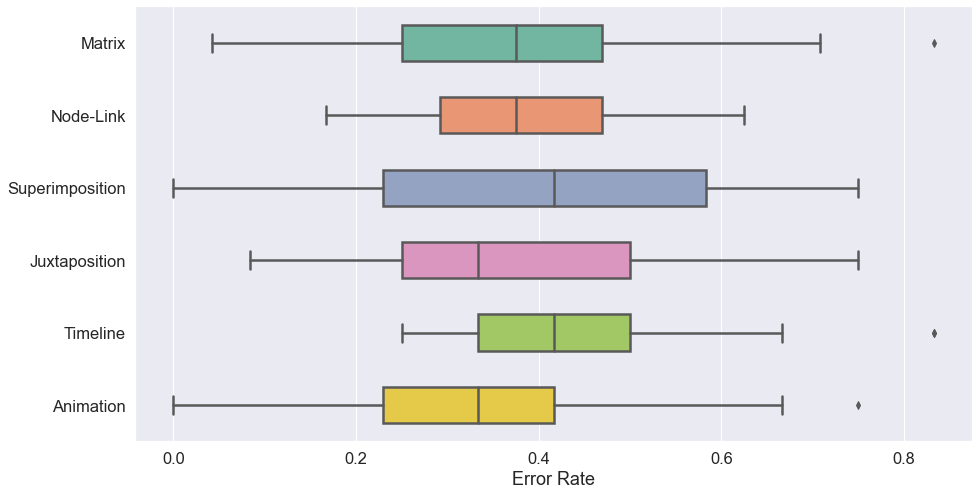

In [333]:
# error rates
sns.set_theme(style="whitegrid")
sns.set(rc = {'figure.figsize':(15,8)})

sns.set(font_scale = 1.5)
ax = sns.boxplot(data=error_rate_all_df, palette="Set2", orient="h", linewidth=2.5, width=0.5)
ax.set_xlabel('Error Rate')
# ax.set_ylabel('Structural/Temporal Encoding')
# ax.set_title=('Error Rates')
# ax = sns.swarmplot(data=error_rate_df, color=".25")


Text(0.5, 0, 'Error Rate')

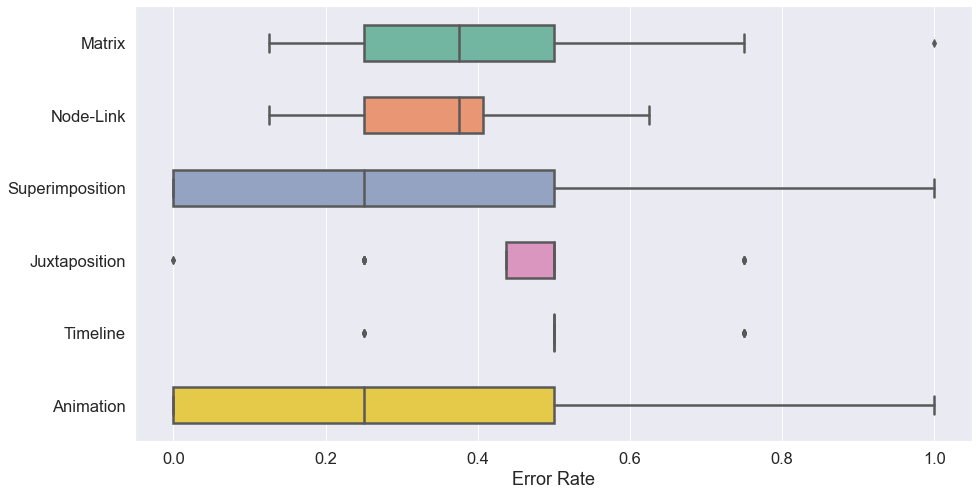

In [334]:
# error rates t1
sns.set_theme(style="whitegrid")
sns.set(font_scale = 1.5)
ax = sns.boxplot(data=error_rate_df, palette="Set2", orient="h", linewidth=2.5, width=0.5)
ax.set_xlabel('Error Rate')

Text(0.5, 0, 'Error Rate')

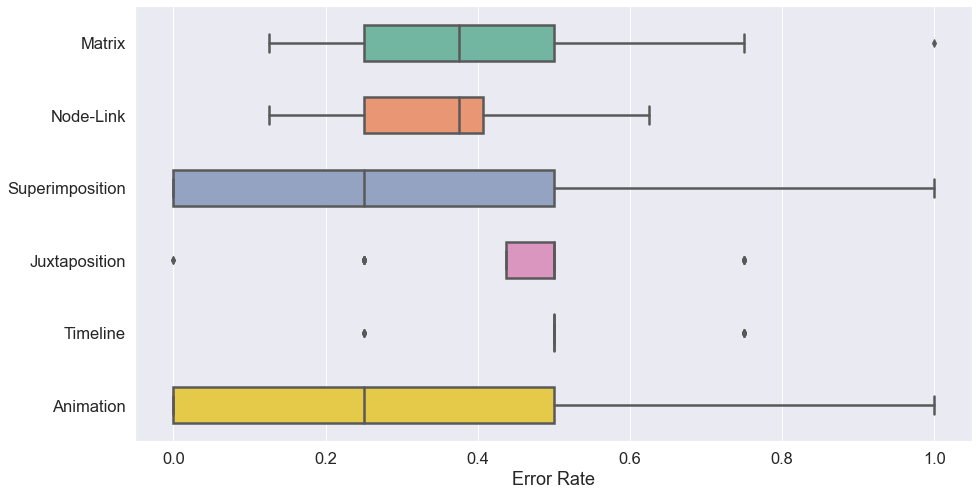

In [335]:
# error rates t2
sns.set_theme(style="whitegrid")
sns.set(font_scale = 1.5)
ax = sns.boxplot(data=error_rate_df, palette="Set2", orient="h", linewidth=2.5, width=0.5)
ax.set_xlabel('Error Rate')

Text(0.5, 0, 'Error Rate')

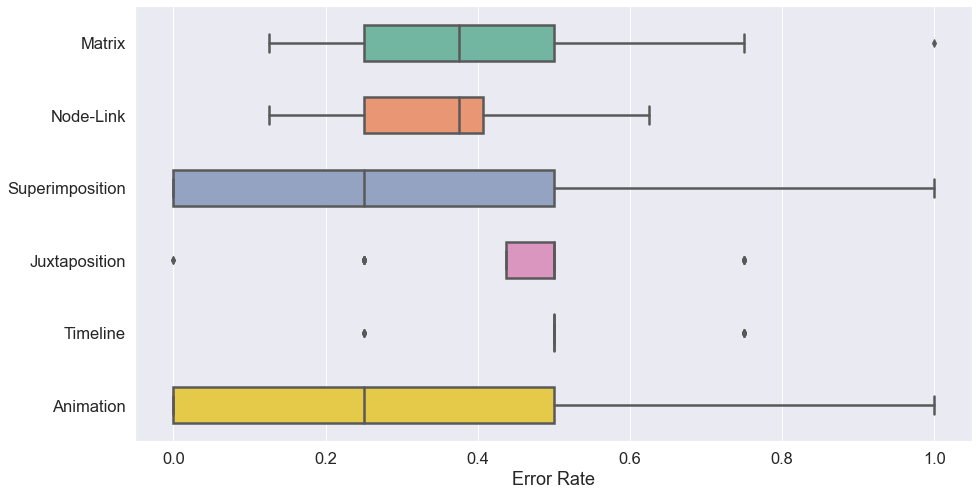

In [336]:
# error rates t3
sns.set_theme(style="whitegrid")
sns.set(font_scale = 1.5)
ax = sns.boxplot(data=error_rate_df, palette="Set2", orient="h", linewidth=2.5, width=0.5)
ax.set_xlabel('Error Rate')

(0.0, 500.0)

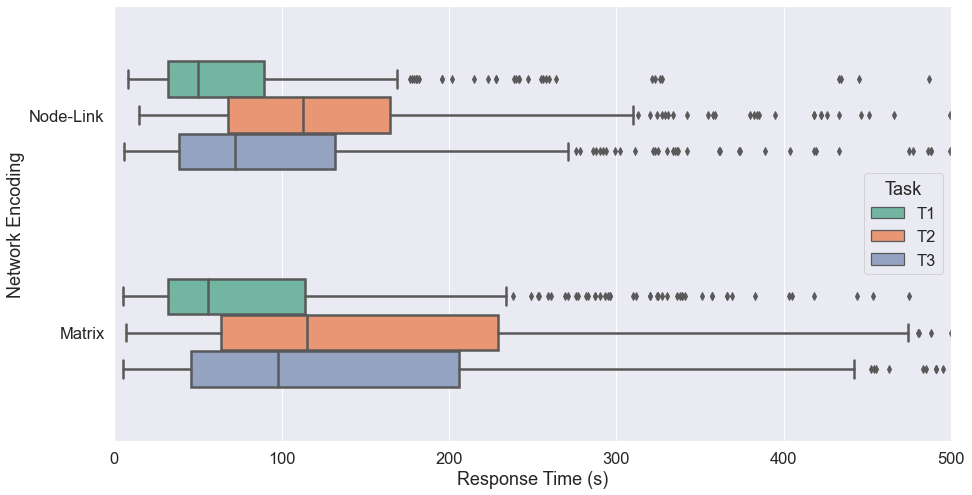

In [337]:
# H1 response time box plot
sns.set_theme(style="whitegrid")
sns.set(font_scale = 1.5)
h1_df['network_enc'] = h1_df['network_enc'].replace(['m', 'nl'], ['Matrix', 'Node-Link'])
h1_df['task_type'] = h1_df['task_type'].replace(['t1', 't2', 't3'], ['T1', 'T2', 'T3'])
h1_df = h1_df.rename(columns={'task_type' : 'Task'})
ax = sns.boxplot(x='time', y='network_enc', hue='Task', data=h1_df, palette="Set2", orient="h", linewidth=2.5, width=0.5)
ax.set_xlabel('Response Time (s)')
ax.set_ylabel('Network Encoding')
ax.set_xlim(0, 500)

Text(0.5, 0, 'Amount of Correct Answers')

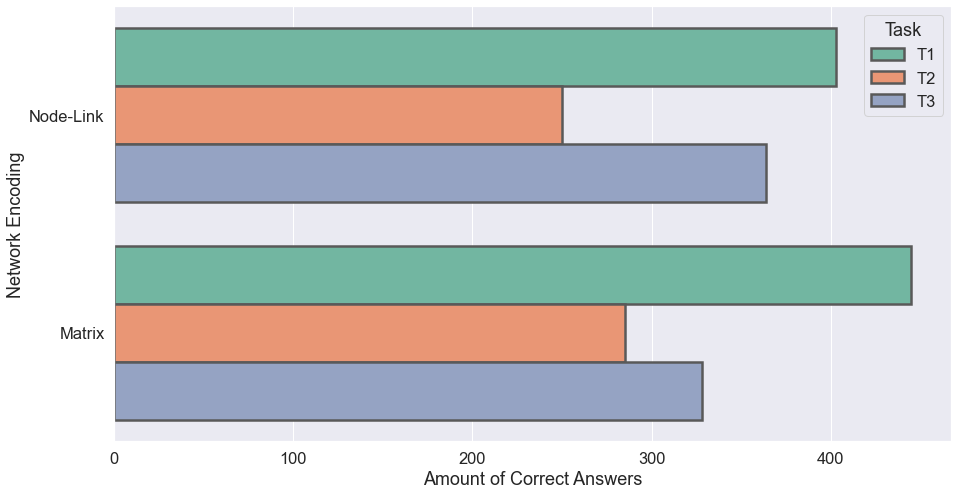

In [338]:
# H1 correctness count plot TRUE
sns.set_theme(style="whitegrid")
sns.set(font_scale = 1.5)
ax = sns.countplot(y='network_enc', hue='Task', data=h1_df[h1_df['correct']=='true'], palette="Set2", orient="h", dodge=True, linewidth=2.5, edgecolor='#595959')
ax.set_ylabel('Network Encoding')
ax.set_xlabel('Amount of Correct Answers')

In [339]:
sns.set_theme(style="whitegrid")
sns.set(font_scale = 2)
sns.set(rc={'figure.figsize':(10,4)})

correct_m_t1, wrong_m_t1 = h1_df[(h1_df['network_enc']=='m') & (h1_df['task_type']=="t1")]['correct'].value_counts()/len(h1_df[(h1_df['network_enc']=='m') & (h1_df['task_type']=="t1")])
correct_m_t2, wrong_m_t2 = h1_df[(h1_df['network_enc']=='m') & (h1_df['task_type']=="t2")]['correct'].value_counts()/len(h1_df[(h1_df['network_enc']=='m') & (h1_df['task_type']=="t2")])
correct_m_t3, wrong_m_t3 = h1_df[(h1_df['network_enc']=='m') & (h1_df['task_type']=="t3")]['correct'].value_counts()/len(h1_df[(h1_df['network_enc']=='m') & (h1_df['task_type']=="t3")])

correct_nl_t1, wrong_nl_t1 = h1_df[(h1_df['network_enc']=='nl') & (h1_df['task_type']=="t1")]['correct'].value_counts()/len(h1_df[(h1_df['network_enc']=='nl') & (h1_df['task_type']=="t1")])
correct_nl_t2, wrong_nl_t2 = h1_df[(h1_df['network_enc']=='nl') & (h1_df['task_type']=="t2")]['correct'].value_counts()/len(h1_df[(h1_df['network_enc']=='nl') & (h1_df['task_type']=="t2")])
correct_nl_t3, wrong_nl_t3 = h1_df[(h1_df['network_enc']=='nl') & (h1_df['task_type']=="t3")]['correct'].value_counts()/len(h1_df[(h1_df['network_enc']=='nl') & (h1_df['task_type']=="t3")])
# print(correct_m_t1, correct_nl_t1)
# print(correct_m_t2, correct_nl_t2)
# print(correct_m_t3, correct_nl_t3)

h1_correctness = pd.DataFrame(columns = {'network_enc', 'Task', 'accuracy'})
h1_correctness = h1_correctness.append({'network_enc': 'Matrix', 'Task': 'T1', 'accuracy': correct_m_t1*100}, ignore_index=True)
h1_correctness= h1_correctness.append({'network_enc': 'Matrix', 'Task': 'T2', 'accuracy': correct_m_t2*100}, ignore_index=True)
h1_correctness = h1_correctness.append({'network_enc': 'Matrix', 'Task': 'T3', 'accuracy': correct_m_t3*100}, ignore_index=True)
h1_correctness= h1_correctness.append({'network_enc': 'Node-Link', 'Task': 'T1', 'accuracy': correct_nl_t1*100}, ignore_index=True)
h1_correctness= h1_correctness.append({'network_enc': 'Node-Link', 'Task': 'T2', 'accuracy': correct_nl_t2*100}, ignore_index=True)
h1_correctness= h1_correctness.append({'network_enc': 'Node-Link', 'Task': 'T3', 'accuracy': correct_nl_t3*100}, ignore_index=True)

ax = sns.barplot(y='network_enc', x='accuracy', hue='Task', data=h1_correctness, palette="Set2", orient="h", linewidth=2.5, edgecolor='#595959')
ax.set_ylabel('Network Encoding')
ax.set_xlabel('Accuracy (in percent)')
ax.set_xlim(0, 100)

KeyError: 'task_type'

In [ ]:
# H1 correctness count plot FALSE
sns.set_theme(style="whitegrid")
sns.set(font_scale = 1.5)
ax = sns.countplot(y='network_enc', hue='task_type', data=h1_df[h1_df['correct']=='false'], palette="Set2")
ax.set_ylabel('Amount of answers')
ax.set_xlabel('Correctness')

ValueError: Could not interpret input 'task_type'

(0.0, 750.0)

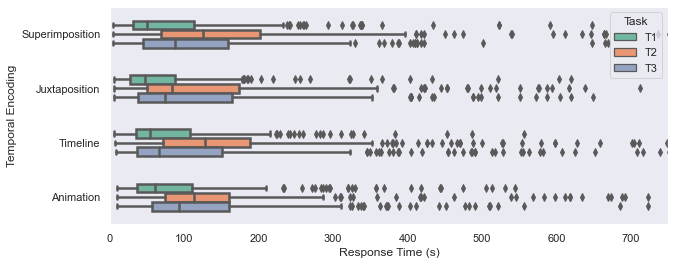

In [349]:
# H2 response time box dark
sns.set_theme(style="dark")
# sns.set(font_scale = 1.5)
h2_df['temporal_enc'] = h2_df['temporal_enc'].replace(['si', 'jp', 'tl', 'an'], ['Superimposition', 'Juxtaposition', 'Timeline', 'Animation'])
h2_df['task_type'] = h2_df['task_type'].replace(['t1', 't2', 't3'], ['T1', 'T2', 'T3'])
h2_df = h2_df.rename(columns={'task_type' : 'Task'})
ax = sns.boxplot(x='time', y='temporal_enc', hue='Task', data=h2_df, palette="Set2", orient="h", linewidth=2.5, width=0.5, hue_order=['T1', 'T2','T3'])
ax.set_xlabel('Response Time (s)')
ax.set_ylabel('Temporal Encoding')
ax.set_xlim(0, 750)

Text(0.5, 0, 'Amount of Correct Answers')

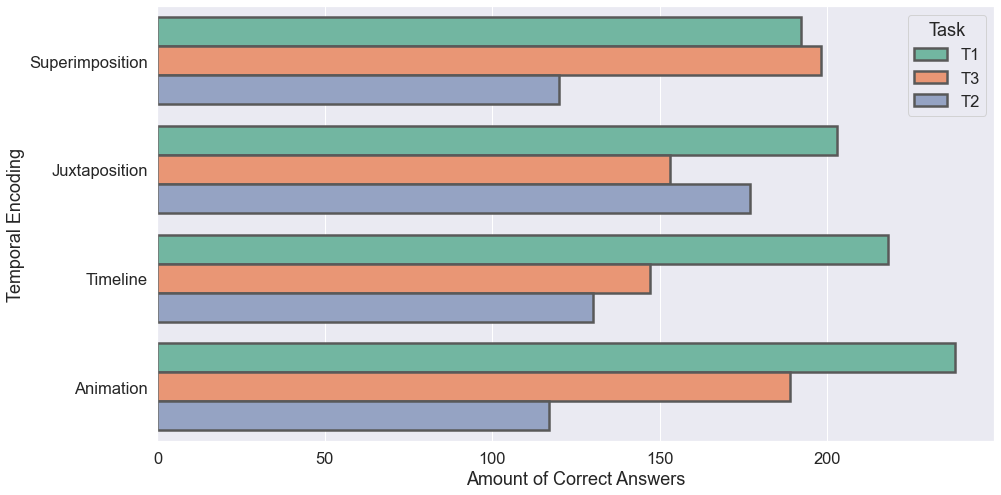

In [ ]:
# H2 correctness count plot TRUE
sns.set_theme(style="whitegrid")
sns.set(font_scale = 1.5)
ax = sns.countplot(y='temporal_enc', hue='Task', data=h2_df[h2_df['correct']=='true'], palette="Set2",  dodge=True, linewidth=2.5, edgecolor='#595959')
ax.set_ylabel('Temporal Encoding')
ax.set_xlabel('Amount of Correct Answers')

(0.0, 100.0)

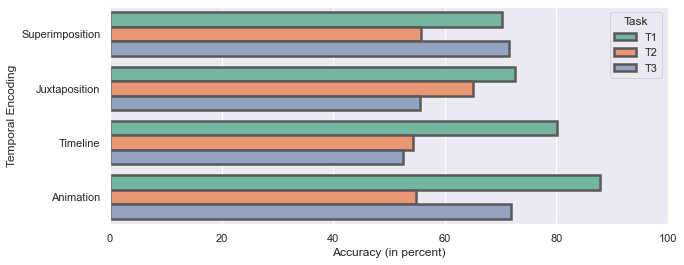

In [ ]:
sns.set_theme(style="whitegrid")
sns.set(font_scale = 2)
sns.set(rc={'figure.figsize':(10,4)})

correct_si_t1, wrong_m_t1 = h2_df[(h2_df['temporal_enc']=='si') & (h2_df['task_type']=="t1")]['correct'].value_counts()/len(h2_df[(h2_df['temporal_enc']=='si') & (h2_df['task_type']=="t1")])
correct_si_t2, wrong_m_t1 = h2_df[(h2_df['temporal_enc']=='si') & (h2_df['task_type']=="t2")]['correct'].value_counts()/len(h2_df[(h2_df['temporal_enc']=='si') & (h2_df['task_type']=="t2")])
correct_si_t3, wrong_m_t1 = h2_df[(h2_df['temporal_enc']=='si') & (h2_df['task_type']=="t3")]['correct'].value_counts()/len(h2_df[(h2_df['temporal_enc']=='si') & (h2_df['task_type']=="t3")])

correct_jp_t1, wrong_m_t2 = h2_df[(h2_df['temporal_enc']=='jp') & (h2_df['task_type']=="t1")]['correct'].value_counts()/len(h2_df[(h2_df['temporal_enc']=='jp') & (h2_df['task_type']=="t1")])
correct_jp_t2, wrong_m_t2 = h2_df[(h2_df['temporal_enc']=='jp') & (h2_df['task_type']=="t2")]['correct'].value_counts()/len(h2_df[(h2_df['temporal_enc']=='jp') & (h2_df['task_type']=="t2")])
correct_jp_t3, wrong_m_t2 = h2_df[(h2_df['temporal_enc']=='jp') & (h2_df['task_type']=="t3")]['correct'].value_counts()/len(h2_df[(h2_df['temporal_enc']=='jp') & (h2_df['task_type']=="t3")])

correct_tl_t1, wrong_m_t3 = h2_df[(h2_df['temporal_enc']=='tl') & (h2_df['task_type']=="t1")]['correct'].value_counts()/len(h2_df[(h2_df['temporal_enc']=='tl') & (h2_df['task_type']=="t1")])
correct_tl_t2, wrong_m_t3 = h2_df[(h2_df['temporal_enc']=='tl') & (h2_df['task_type']=="t2")]['correct'].value_counts()/len(h2_df[(h2_df['temporal_enc']=='tl') & (h2_df['task_type']=="t2")])
correct_tl_t3, wrong_m_t3 = h2_df[(h2_df['temporal_enc']=='tl') & (h2_df['task_type']=="t3")]['correct'].value_counts()/len(h2_df[(h2_df['temporal_enc']=='tl') & (h2_df['task_type']=="t3")])

correct_an_t1, wrong_m_t3 = h2_df[(h2_df['temporal_enc']=='an') & (h2_df['task_type']=="t1")]['correct'].value_counts()/len(h2_df[(h2_df['temporal_enc']=='an') & (h2_df['task_type']=="t1")])
correct_an_t2, wrong_m_t3 = h2_df[(h2_df['temporal_enc']=='an') & (h2_df['task_type']=="t2")]['correct'].value_counts()/len(h2_df[(h2_df['temporal_enc']=='an') & (h2_df['task_type']=="t2")])
correct_an_t3, wrong_m_t3 = h2_df[(h2_df['temporal_enc']=='an') & (h2_df['task_type']=="t3")]['correct'].value_counts()/len(h2_df[(h2_df['temporal_enc']=='an') & (h2_df['task_type']=="t3")])
# print(correct_m_t1, correct_nl_t1)
# print(correct_m_t2, correct_nl_t2)
# print(correct_m_t3, correct_nl_t3)

h2_correctness = pd.DataFrame(columns = {'temporal_enc', 'Task', 'accuracy'})
h2_correctness = h2_correctness.append({'temporal_enc': 'Superimposition', 'Task': 'T1', 'accuracy': correct_si_t1*100}, ignore_index=True)
h2_correctness = h2_correctness.append({'temporal_enc': 'Superimposition', 'Task': 'T2', 'accuracy': correct_si_t2*100}, ignore_index=True)
h2_correctness = h2_correctness.append({'temporal_enc': 'Superimposition', 'Task': 'T3', 'accuracy': correct_si_t3*100}, ignore_index=True)
h2_correctness = h2_correctness.append({'temporal_enc': 'Juxtaposition', 'Task': 'T1', 'accuracy': correct_jp_t1*100}, ignore_index=True)
h2_correctness = h2_correctness.append({'temporal_enc': 'Juxtaposition', 'Task': 'T2', 'accuracy': correct_jp_t2*100}, ignore_index=True)
h2_correctness = h2_correctness.append({'temporal_enc': 'Juxtaposition', 'Task': 'T3', 'accuracy': correct_jp_t3*100}, ignore_index=True)
h2_correctness = h2_correctness.append({'temporal_enc': 'Timeline', 'Task': 'T1', 'accuracy': correct_tl_t1*100}, ignore_index=True)
h2_correctness = h2_correctness.append({'temporal_enc': 'Timeline', 'Task': 'T2', 'accuracy': correct_tl_t2*100}, ignore_index=True)
h2_correctness = h2_correctness.append({'temporal_enc': 'Timeline', 'Task': 'T3', 'accuracy': correct_tl_t3*100}, ignore_index=True)
h2_correctness = h2_correctness.append({'temporal_enc': 'Animation', 'Task': 'T1', 'accuracy': correct_an_t1*100}, ignore_index=True)
h2_correctness = h2_correctness.append({'temporal_enc': 'Animation', 'Task': 'T2', 'accuracy': correct_an_t2*100}, ignore_index=True)
h2_correctness = h2_correctness.append({'temporal_enc': 'Animation', 'Task': 'T3', 'accuracy': correct_an_t3*100}, ignore_index=True)

ax = sns.barplot(y='temporal_enc', x='accuracy', hue='Task', data=h2_correctness, palette="Set2", orient="h", linewidth=2.5, edgecolor='#595959')
ax.set_ylabel('Temporal Encoding')
ax.set_xlabel('Accuracy (in percent)')
ax.set_xlim(0, 100)

In [ ]:
# H2 correctness count plot FALSE
sns.set_theme(style="whitegrid")
sns.set(font_scale = 1.5)
ax = sns.countplot(y='temporal_enc', hue='task_type', data=h2_df[h2_df['correct']=='false'], palette="Set2")
ax.set_ylabel('Amount of answers')
ax.set_xlabel('Correctness')

In [351]:
# H3 response time box plot
sns.set_theme(style="whitegrid")
# sns.set(font_scale = 1.5)
h3_df['temporal_enc'] = h3_df['temporal_enc'].replace(['tl', 'an'], ['Timeline', 'Animation'])
h3_df['task_type'] = h3_df['task_type'].replace(['t1', 't2', 't3'], ['T1', 'T2', 'T3'])
h3_df = h3_df.rename(columns={'task_type' : 'Task'})
ax = sns.boxplot(x='time', y='temporal_enc', hue='Task', data=h3_df, palette="Set2", orient="h", linewidth=2.5, width=0.5, hue_order=['T1', 'T2', 'T3'])
ax.set_xlabel('Response Time (s)')
ax.set_ylabel('Temporal Encoding')
ax.set_xlim(0, 375)

KeyError: 'task_type'

Text(0.5, 0, 'Amount of Correct Answers')

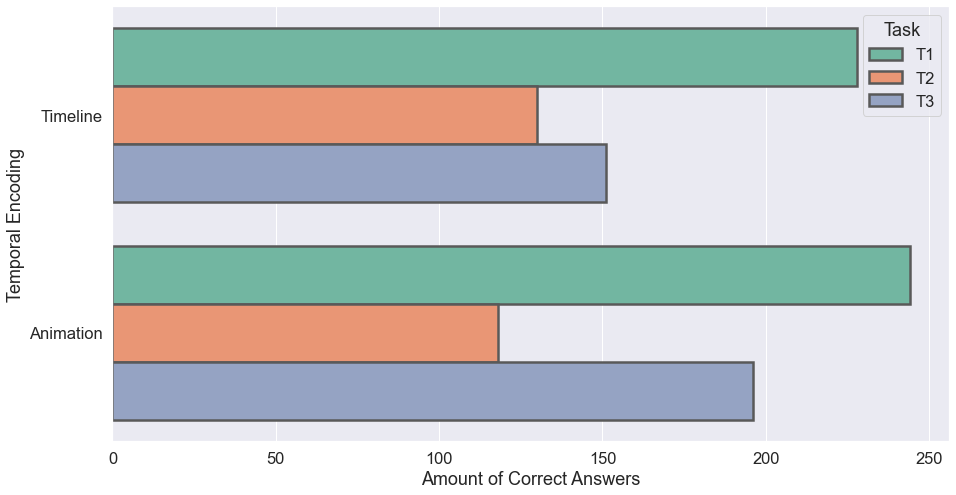

In [ ]:
# 32 correctness count plot TRUE
sns.set_theme(style="whitegrid")
sns.set(font_scale = 1.5)
ax = sns.countplot(y='temporal_enc', hue='Task', data=h3_df[h3_df['correct']=='true'], palette="Set2",  dodge=True, linewidth=2.5, edgecolor='#595959')
ax.set_ylabel('Temporal Encoding')
ax.set_xlabel('Amount of Correct Answers')

In [ ]:
# H3 correctness count plot FALSE
sns.set_theme(style="whitegrid")
sns.set(font_scale = 1.5)
ax = sns.countplot(y='temporal_enc', hue='task_type', data=h3_df[h3_df['correct']=='false'], palette="Set2")
ax.set_ylabel('Amount of answers')
ax.set_xlabel('Correctness')

(0.0, 750.0)

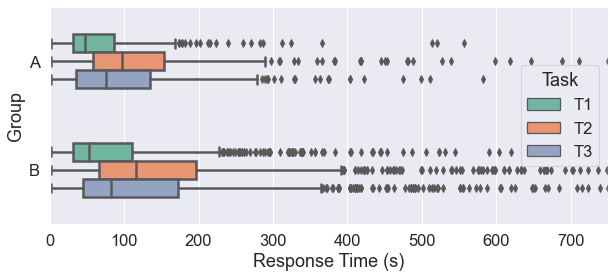

In [352]:
# H4 response time box plot
sns.set_theme(style="whitegrid")
sns.set(font_scale = 1.5)
h4_df = h4_df.rename(columns={'group' : 'Group'})
h4_df['task_type'] = h4_df['task_type'].replace(['t1', 't2', 't3'], ['T1', 'T2', 'T3'])
h4_df = h4_df.rename(columns={'task_type' : 'Task'})
ax = sns.boxplot(x='time', y='Group', hue='Task', data=h4_df, palette="Set2", orient="h", linewidth=2.5, width=0.5, hue_order=['T1', 'T2', 'T3'])
ax.set_xlabel('Response Time (s)')
ax.set_ylabel('Group')
ax.set_xlim(0, 750)

Text(0.5, 0, 'Correctness')

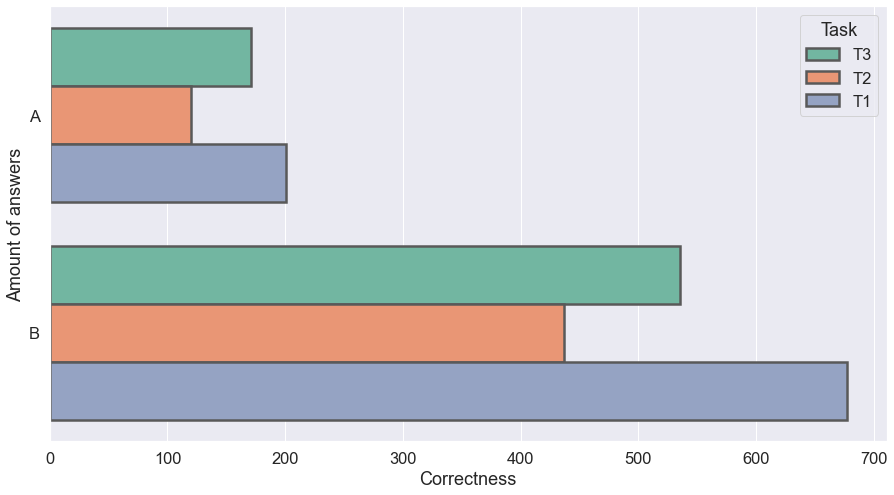

In [ ]:
# H4 correctness count plot TRUE -> More in group b than a -> do percentages
sns.set_theme(style="whitegrid")
sns.set(font_scale = 1.5)
ax = sns.countplot(y='Group', hue='Task', data=h4_df[h4_df['correct']=='true'], palette="Set2", dodge=True, linewidth=2.5, edgecolor='#595959')
ax.set_ylabel('Amount of answers')
ax.set_xlabel('Correctness')

(0.0, 100.0)

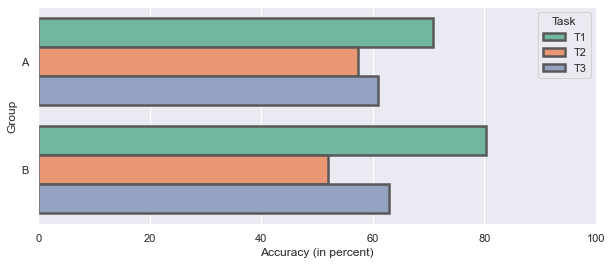

In [ ]:
sns.set_theme(style="whitegrid")
sns.set(font_scale = 2)
sns.set(rc={'figure.figsize':(10,4)})

correct_a_t1, wrong_m_t1 = h4_df[(h4_df['group']=='A') & (h4_df['task_type']=="t1")]['correct'].value_counts()/len(h4_df[(h4_df['group']=='A') & (h4_df['task_type']=="t1")])
correct_a_t2, wrong_m_t1 = h4_df[(h4_df['group']=='A') & (h4_df['task_type']=="t2")]['correct'].value_counts()/len(h4_df[(h4_df['group']=='A') & (h4_df['task_type']=="t2")])
correct_a_t3, wrong_m_t1 = h4_df[(h4_df['group']=='A') & (h4_df['task_type']=="t3")]['correct'].value_counts()/len(h4_df[(h4_df['group']=='A') & (h4_df['task_type']=="t3")])

correct_b_t1, wrong_m_t2 = h4_df[(h4_df['group']=='B') & (h4_df['task_type']=="t1")]['correct'].value_counts()/len(h4_df[(h4_df['group']=='B') & (h4_df['task_type']=="t1")])
correct_b_t2, wrong_m_t2 = h4_df[(h4_df['group']=='B') & (h4_df['task_type']=="t2")]['correct'].value_counts()/len(h4_df[(h4_df['group']=='B') & (h4_df['task_type']=="t2")])
correct_b_t3, wrong_m_t2 = h4_df[(h4_df['group']=='B') & (h4_df['task_type']=="t3")]['correct'].value_counts()/len(h4_df[(h4_df['group']=='B') & (h4_df['task_type']=="t3")])

h3_correctness = pd.DataFrame(columns = {'group', 'Task', 'accuracy'})
h3_correctness = h3_correctness.append({'group': 'A', 'Task': 'T1', 'accuracy': correct_a_t1*100}, ignore_index=True)
h3_correctness = h3_correctness.append({'group': 'A', 'Task': 'T2', 'accuracy': correct_a_t2*100}, ignore_index=True)
h3_correctness = h3_correctness.append({'group': 'A', 'Task': 'T3', 'accuracy': correct_a_t3*100}, ignore_index=True)
h3_correctness = h3_correctness.append({'group': 'B', 'Task': 'T1', 'accuracy': correct_b_t1*100}, ignore_index=True)
h3_correctness = h3_correctness.append({'group': 'B', 'Task': 'T2', 'accuracy': correct_b_t2*100}, ignore_index=True)
h3_correctness = h3_correctness.append({'group': 'B', 'Task': 'T3', 'accuracy': correct_b_t3*100}, ignore_index=True)


ax = sns.barplot(y='group', x='accuracy', hue='Task', data=h3_correctness, palette="Set2", orient="h", linewidth=2.5, edgecolor='#595959')
ax.set_ylabel('Group')
ax.set_xlabel('Accuracy (in percent)')
ax.set_xlim(0, 100)

Text(0.5, 0, 'Amount of Correct Answers')

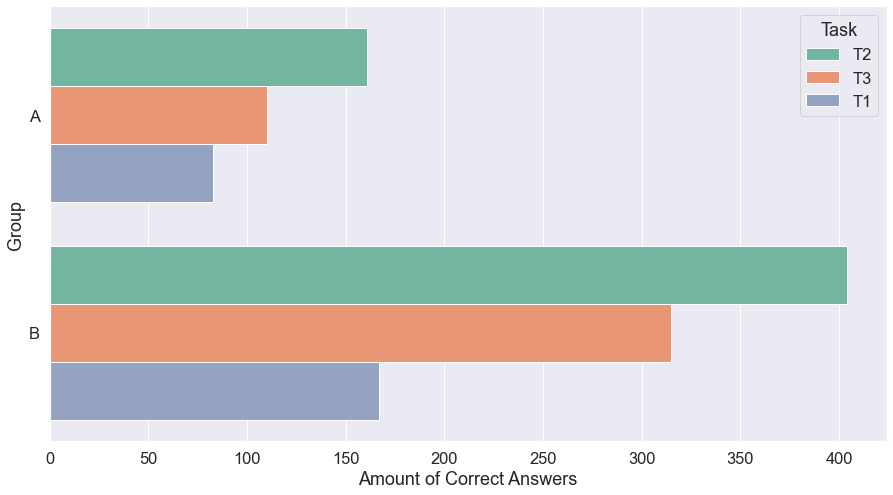

In [ ]:
# H4 correctness count plot FALSE
sns.set_theme(style="whitegrid")
sns.set(font_scale = 1.5)
ax = sns.countplot(y='Group', hue='Task', data=h4_df[h4_df['correct']=='false'], palette="Set2")
ax.set_ylabel('Group')
ax.set_xlabel('Amount of Correct Answers')

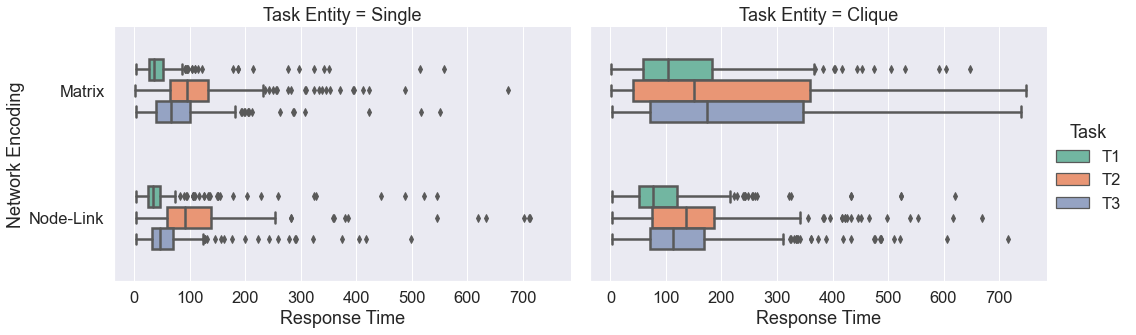

In [353]:
# H5 response time box plot
sns.set_theme(style="whitegrid")
sns.set(font_scale = 1.5)

h5_df['task_type'] = h5_df['task_type'].replace(['t1', 't2', 't3'], ['T1', 'T2', 'T3'])
h5_df['task_entity'] = h5_df['task_entity'].replace(['single', 'clique'], ['Single', 'Clique'])
h5_df['network_enc'] = h5_df['network_enc'].replace(['m', 'nl'], ['Matrix', 'Node-Link'])
h5_df = h5_df.rename(columns={'task_type' : 'Task'})
h5_df = h5_df.rename(columns={'task_entity' : 'Task Entity'})
h5_df = h5_df.rename(columns={'network_enc' : 'Network Encoding'})
h5_df = h5_df.rename(columns={'time' : 'Response Time'})
ax = sns.catplot(y='Network Encoding', x='Response Time', hue='Task', col="Task Entity", data=h5_df[h5_df['Response Time'] <= 750], palette="Set2", orient='h', kind="box", linewidth=2.5, width=0.5, aspect=1.5, hue_order=['T1', 'T2', 'T3'])


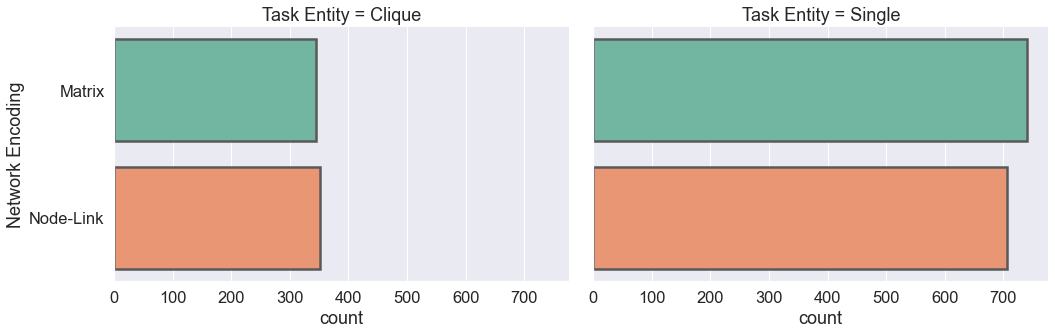

In [ ]:
# H5 correctness count plot FALSE
sns.set_theme(style="whitegrid")
sns.set(font_scale = 1.5)
ax = sns.catplot(y='Network Encoding', col="Task Entity", data=h5_df[h5_df['correct']=='true'], palette="Set2", kind="count", orient='h', linewidth=2.5, aspect=1.5, edgecolor='#595959')
# ax.set_ylabel('Amount of answers')
# ax.set_xlabel('Correctness')

(0.0, 100.0)

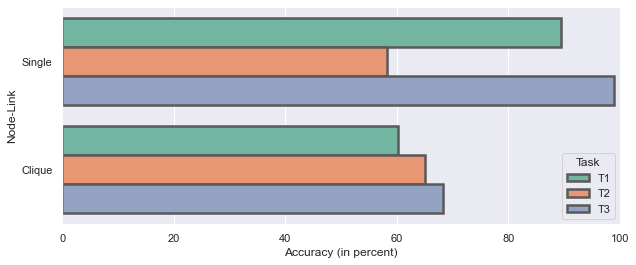

In [ ]:
sns.set_theme(style="whitegrid")
sns.set(font_scale = 2)
sns.set(rc={'figure.figsize':(10,4)})

correct_m_single_t1, wrong_m_t1 = h5_df[(h5_df['network_enc']=='m') & (h5_df['task_entity']=="single") & (h5_df['task_type']=="t1")]['correct'].value_counts()/len(h5_df[(h5_df['network_enc']=='m') & (h5_df['task_entity']=="single")& (h5_df['task_type']=="t1")])
correct_m_single_t2, wrong_m_t1 = h5_df[(h5_df['network_enc']=='m') & (h5_df['task_entity']=="single") & (h5_df['task_type']=="t2")]['correct'].value_counts()/len(h5_df[(h5_df['network_enc']=='m') & (h5_df['task_entity']=="single") & (h5_df['task_type']=="t2")])
correct_m_single_t3, wrong_m_t1 = h5_df[(h5_df['network_enc']=='m') & (h5_df['task_entity']=="single") & (h5_df['task_type']=="t3")]['correct'].value_counts()/len(h5_df[(h5_df['network_enc']=='m') & (h5_df['task_entity']=="single") & (h5_df['task_type']=="t3")])
correct_m_clique_t1, wrong_m_t1 = h5_df[(h5_df['network_enc']=='m') & (h5_df['task_entity']=="clique") & (h5_df['task_type']=="t1")]['correct'].value_counts()/len(h5_df[(h5_df['network_enc']=='m') & (h5_df['task_entity']=="clique") & (h5_df['task_type']=="t1")])
correct_m_clique_t2, wrong_m_t1 = h5_df[(h5_df['network_enc']=='m') & (h5_df['task_entity']=="clique") & (h5_df['task_type']=="t2")]['correct'].value_counts()/len(h5_df[(h5_df['network_enc']=='m') & (h5_df['task_entity']=="clique") & (h5_df['task_type']=="t2")])
correct_m_clique_t3, wrong_m_t1 = h5_df[(h5_df['network_enc']=='m') & (h5_df['task_entity']=="clique") & (h5_df['task_type']=="t3")]['correct'].value_counts()/len(h5_df[(h5_df['network_enc']=='m') & (h5_df['task_entity']=="clique") & (h5_df['task_type']=="t3")])


correct_nl_single_t1, wrong_nl_t1 = h5_df[(h5_df['network_enc']=='nl') & (h5_df['task_entity']=="single") & (h5_df['task_type']=="t1")]['correct'].value_counts()/len(h5_df[(h5_df['network_enc']=='nl') & (h5_df['task_entity']=="single")& (h5_df['task_type']=="t1")])
correct_nl_single_t2, wrong_nl_t1 = h5_df[(h5_df['network_enc']=='nl') & (h5_df['task_entity']=="single") & (h5_df['task_type']=="t2")]['correct'].value_counts()/len(h5_df[(h5_df['network_enc']=='nl') & (h5_df['task_entity']=="single") & (h5_df['task_type']=="t2")])
correct_nl_single_t3, wrong_nl_t1 = h5_df[(h5_df['network_enc']=='nl') & (h5_df['task_entity']=="single") & (h5_df['task_type']=="t3")]['correct'].value_counts()/len(h5_df[(h5_df['network_enc']=='nl') & (h5_df['task_entity']=="single") & (h5_df['task_type']=="t3")])
correct_nl_clique_t1, wrong_nl_t1 = h5_df[(h5_df['network_enc']=='nl') & (h5_df['task_entity']=="clique") & (h5_df['task_type']=="t1")]['correct'].value_counts()/len(h5_df[(h5_df['network_enc']=='nl') & (h5_df['task_entity']=="clique") & (h5_df['task_type']=="t1")])
correct_nl_clique_t2, wrong_nl_t1 = h5_df[(h5_df['network_enc']=='nl') & (h5_df['task_entity']=="clique") & (h5_df['task_type']=="t2")]['correct'].value_counts()/len(h5_df[(h5_df['network_enc']=='nl') & (h5_df['task_entity']=="clique") & (h5_df['task_type']=="t2")])
correct_nl_clique_t3, wrong_nl_t1 = h5_df[(h5_df['network_enc']=='nl') & (h5_df['task_entity']=="clique") & (h5_df['task_type']=="t3")]['correct'].value_counts()/len(h5_df[(h5_df['network_enc']=='nl') & (h5_df['task_entity']=="clique") & (h5_df['task_type']=="t3")])


h4_correctness_m = pd.DataFrame(columns = {'Task Entity', 'Task', 'accuracy'})
h4_correctness_m = h4_correctness_m.append({'Task Entity': 'Single', 'Task': 'T1', 'accuracy': correct_m_single_t1*100}, ignore_index=True)
h4_correctness_m = h4_correctness_m.append({'Task Entity': 'Single', 'Task': 'T2', 'accuracy': correct_m_single_t2*100}, ignore_index=True)
h4_correctness_m = h4_correctness_m.append({'Task Entity': 'Single', 'Task': 'T3', 'accuracy': correct_m_single_t3*100}, ignore_index=True)
h4_correctness_m = h4_correctness_m.append({'Task Entity': 'Clique', 'Task': 'T1', 'accuracy': correct_m_clique_t1*100}, ignore_index=True)
h4_correctness_m = h4_correctness_m.append({'Task Entity': 'Clique', 'Task': 'T2', 'accuracy': correct_m_clique_t2*100}, ignore_index=True)
h4_correctness_m = h4_correctness_m.append({'Task Entity': 'Clique', 'Task': 'T3', 'accuracy': correct_m_clique_t3*100}, ignore_index=True)

h4_correctness_nl = pd.DataFrame(columns = {'Task Entity', 'Task', 'accuracy'})
h4_correctness_nl = h4_correctness_nl.append({'Task Entity': 'Single', 'Task': 'T1', 'accuracy': correct_nl_single_t1*100}, ignore_index=True)
h4_correctness_nl = h4_correctness_nl.append({'Task Entity': 'Single', 'Task': 'T2', 'accuracy': correct_nl_single_t2*100}, ignore_index=True)
h4_correctness_nl = h4_correctness_nl.append({'Task Entity': 'Single', 'Task': 'T3', 'accuracy': correct_nl_single_t3*100}, ignore_index=True)
h4_correctness_nl = h4_correctness_nl.append({'Task Entity': 'Clique', 'Task': 'T1', 'accuracy': correct_nl_clique_t1*100}, ignore_index=True)
h4_correctness_nl = h4_correctness_nl.append({'Task Entity': 'Clique', 'Task': 'T2', 'accuracy': correct_nl_clique_t2*100}, ignore_index=True)
h4_correctness_nl = h4_correctness_nl.append({'Task Entity': 'Clique', 'Task': 'T3', 'accuracy': correct_nl_clique_t3*100}, ignore_index=True)

# h4_correctness_m = h4_correctness_m.append({'network_enc': 'M', 'Task Entity': 'Clique', 'accuracy': correct_m_clique*100}, ignore_index=True)
# h4_correctness_m = h4_correctness_m.append({'network_enc': 'NL', 'Task Entity': 'Single', 'accuracy': correct_nl_single*100}, ignore_index=True)
# h4_correctness_m = h4_correctness_m.append({'network_enc': 'NL', 'Task Entity': 'Clique', 'accuracy': correct_nl_clique*100}, ignore_index=True)

ax = sns.barplot(y='Task Entity', x='accuracy', hue='Task', data=h4_correctness_nl, palette="Set2", orient="h", linewidth=2.5, edgecolor='#595959')
ax.set_ylabel('Node-Link')
ax.set_xlabel('Accuracy (in percent)')
ax.set_xlim(0, 100)

In [ ]:
# H5 correctness count plot FALSE
sns.set_theme(style="whitegrid")
sns.set(font_scale = 1.5)
ax = sns.countplot(y='group', hue='task_type', data=h5_df[h5_df['correct']=='false'], palette="Set2")
ax.set_ylabel('Amount of answers')
ax.set_xlabel('Correctness')

Text(0, 0.5, 'Network Encoding')

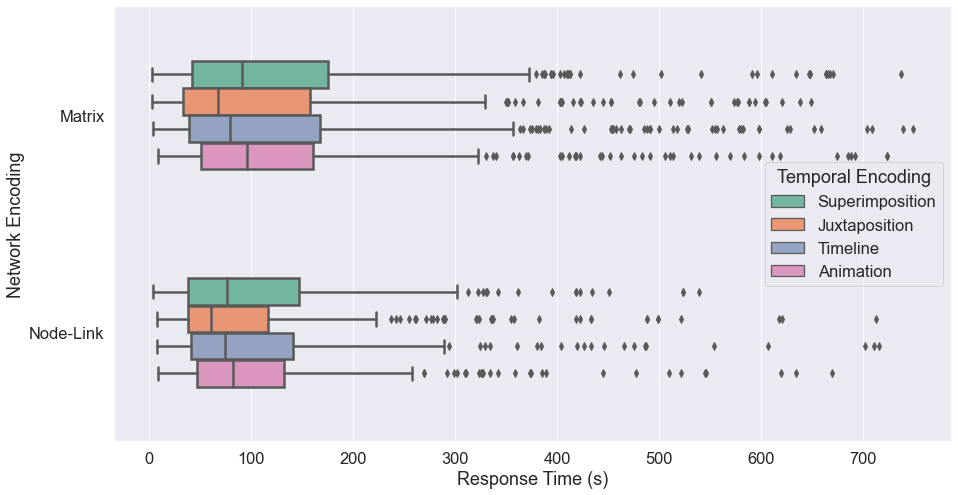

In [ ]:
# H6 box plot response times
sns.set_theme(style="whitegrid")
sns.set(font_scale = 1.5)
# h4_df = h4_df.rename(columns={'group' : 'Group'})
h6_df['task_type'] = h6_df['task_type'].replace(['t1', 't2', 't3'], ['T1', 'T2', 'T3'])
h6_df['temporal_enc'] = h6_df['temporal_enc'].replace(['si', 'jp', 'tl', 'an'], ['Superimposition', 'Juxtaposition', 'Timeline', 'Animation'])
h6_df['network_enc'] = h6_df['network_enc'].replace(['m', 'nl'], ['Matrix', 'Node-Link'])
h6_df = h6_df.rename(columns={'temporal_enc' : 'Temporal Encoding'})

ax = sns.boxplot(x='time', y='network_enc', hue='Temporal Encoding', data=h6_df[h6_df['time'] <= 750], palette="Set2", orient="h", linewidth=2.5, width=0.5)
ax.set_xlabel('Response Time (s)')
ax.set_ylabel('Network Encoding')
# ax.set_xlim(0, 500)

Text(0.5, 0, 'Amount of Correct Answers')

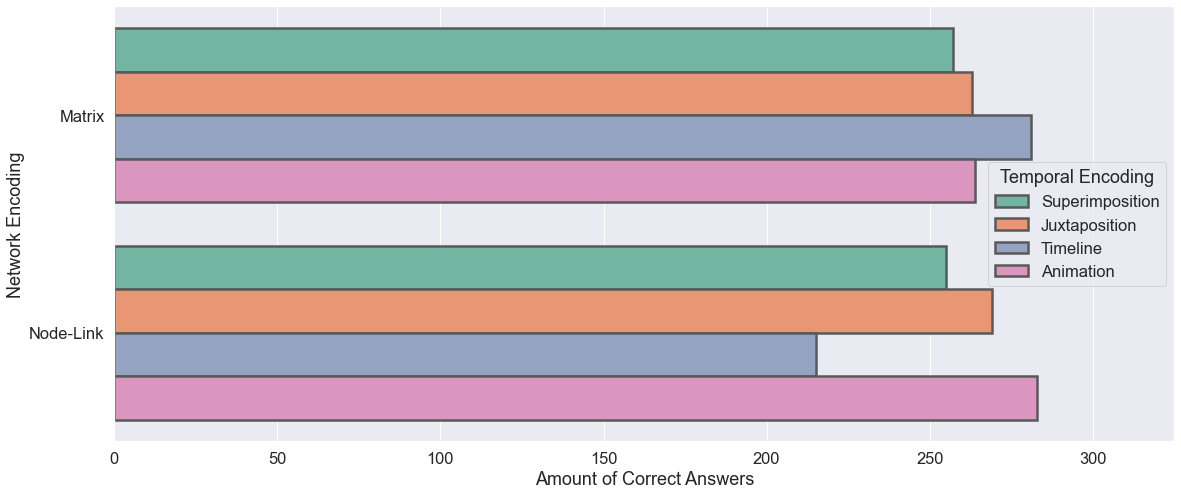

In [ ]:
# H6 correctness count plot TRUE -> More in group b than a -> do percentages
sns.set_theme(style="whitegrid")
sns.set(font_scale = 1.5)
# sns.set(rc = {'figure.figsize':(19,8)})
ax = sns.countplot(y='network_enc', hue='Temporal Encoding', data=h6_df[h6_df['correct']=='true'], palette="Set2", dodge=True, linewidth=2.5, edgecolor='#595959')
ax.set_xlim(0, 325)
ax.set_ylabel('Network Encoding')
ax.set_xlabel('Amount of Correct Answers')

(0.0, 100.0)

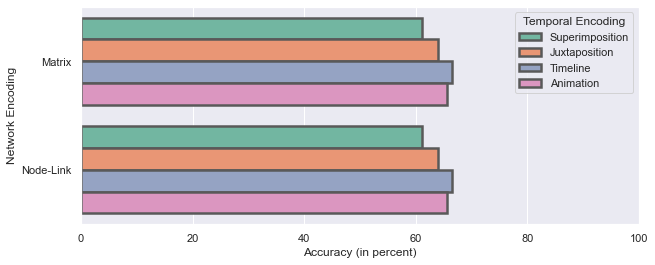

In [ ]:
sns.set_theme(style="whitegrid")
sns.set(font_scale = 2)
sns.set(rc={'figure.figsize':(10,4)})

correct_m_si, wrong_m_t1 = h6_df[(h6_df['network_enc']=='m') & (h6_df['temporal_enc']=="si")]['correct'].value_counts()/len(h6_df[(h6_df['network_enc']=='m') & (h6_df['temporal_enc']=="si")])
correct_m_jp, wrong_m_t1 = h6_df[(h6_df['network_enc']=='m') & (h6_df['temporal_enc']=="jp")]['correct'].value_counts()/len(h6_df[(h6_df['network_enc']=='m') & (h6_df['temporal_enc']=="jp")])
correct_m_tl, wrong_m_t1 = h6_df[(h6_df['network_enc']=='m') & (h6_df['temporal_enc']=="tl")]['correct'].value_counts()/len(h6_df[(h6_df['network_enc']=='m') & (h6_df['temporal_enc']=="tl")])
correct_m_an, wrong_m_t1 = h6_df[(h6_df['network_enc']=='m') & (h6_df['temporal_enc']=="an")]['correct'].value_counts()/len(h6_df[(h6_df['network_enc']=='m') & (h6_df['temporal_enc']=="an")])

correct_nl_si, wrong_nl_t1 = h6_df[(h6_df['network_enc']=='nl') & (h6_df['temporal_enc']=="si")]['correct'].value_counts()/len(h6_df[(h6_df['network_enc']=='nl') & (h6_df['temporal_enc']=="si")])
correct_nl_jp, wrong_nl_t1 = h6_df[(h6_df['network_enc']=='nl') & (h6_df['temporal_enc']=="jp")]['correct'].value_counts()/len(h6_df[(h6_df['network_enc']=='nl') & (h6_df['temporal_enc']=="jp")])
correct_nl_tl, wrong_nl_t1 = h6_df[(h6_df['network_enc']=='nl') & (h6_df['temporal_enc']=="tl")]['correct'].value_counts()/len(h6_df[(h6_df['network_enc']=='nl') & (h6_df['temporal_enc']=="tl")])
correct_nl_an, wrong_nl_t1 = h6_df[(h6_df['network_enc']=='nl') & (h6_df['temporal_enc']=="an")]['correct'].value_counts()/len(h6_df[(h6_df['network_enc']=='nl') & (h6_df['temporal_enc']=="an")])

h5_correctness = pd.DataFrame(columns = {'network_enc', 'Temporal Encoding', 'accuracy'})

h5_correctness = h5_correctness.append({'network_enc': 'Matrix', 'Temporal Encoding': 'Superimposition', 'accuracy': correct_m_si*100}, ignore_index=True)
h5_correctness = h5_correctness.append({'network_enc': 'Matrix', 'Temporal Encoding': 'Juxtaposition', 'accuracy': correct_m_jp*100}, ignore_index=True)
h5_correctness = h5_correctness.append({'network_enc': 'Matrix', 'Temporal Encoding': 'Timeline', 'accuracy': correct_m_tl*100}, ignore_index=True)
h5_correctness = h5_correctness.append({'network_enc': 'Matrix', 'Temporal Encoding': 'Animation', 'accuracy': correct_m_an*100}, ignore_index=True)

h5_correctness = h5_correctness.append({'network_enc': 'Node-Link', 'Temporal Encoding': 'Superimposition', 'accuracy': correct_m_si*100}, ignore_index=True)
h5_correctness = h5_correctness.append({'network_enc': 'Node-Link', 'Temporal Encoding': 'Juxtaposition', 'accuracy': correct_m_jp*100}, ignore_index=True)
h5_correctness = h5_correctness.append({'network_enc': 'Node-Link', 'Temporal Encoding': 'Timeline', 'accuracy': correct_m_tl*100}, ignore_index=True)
h5_correctness = h5_correctness.append({'network_enc': 'Node-Link', 'Temporal Encoding': 'Animation', 'accuracy': correct_m_an*100}, ignore_index=True)


ax = sns.barplot(y='network_enc', x='accuracy', hue='Temporal Encoding', data=h5_correctness, palette="Set2", orient="h", linewidth=2.5, edgecolor='#595959')
ax.set_ylabel('Network Encoding')
ax.set_xlabel('Accuracy (in percent)')
ax.set_xlim(0, 100)

In [ ]:
# preferences
sns.set(style="darkgrid")
sns.set(font_scale = 1.5)
ax = sns.distplot(preferences_df['NL-JP'], hist_kws=dict(edgecolor="#595959", linewidth=2.5, alpha=1), kde=False,  color='#8a8a8a')
ax.set_xlabel('Node-Link Juxtaposition Preferences')

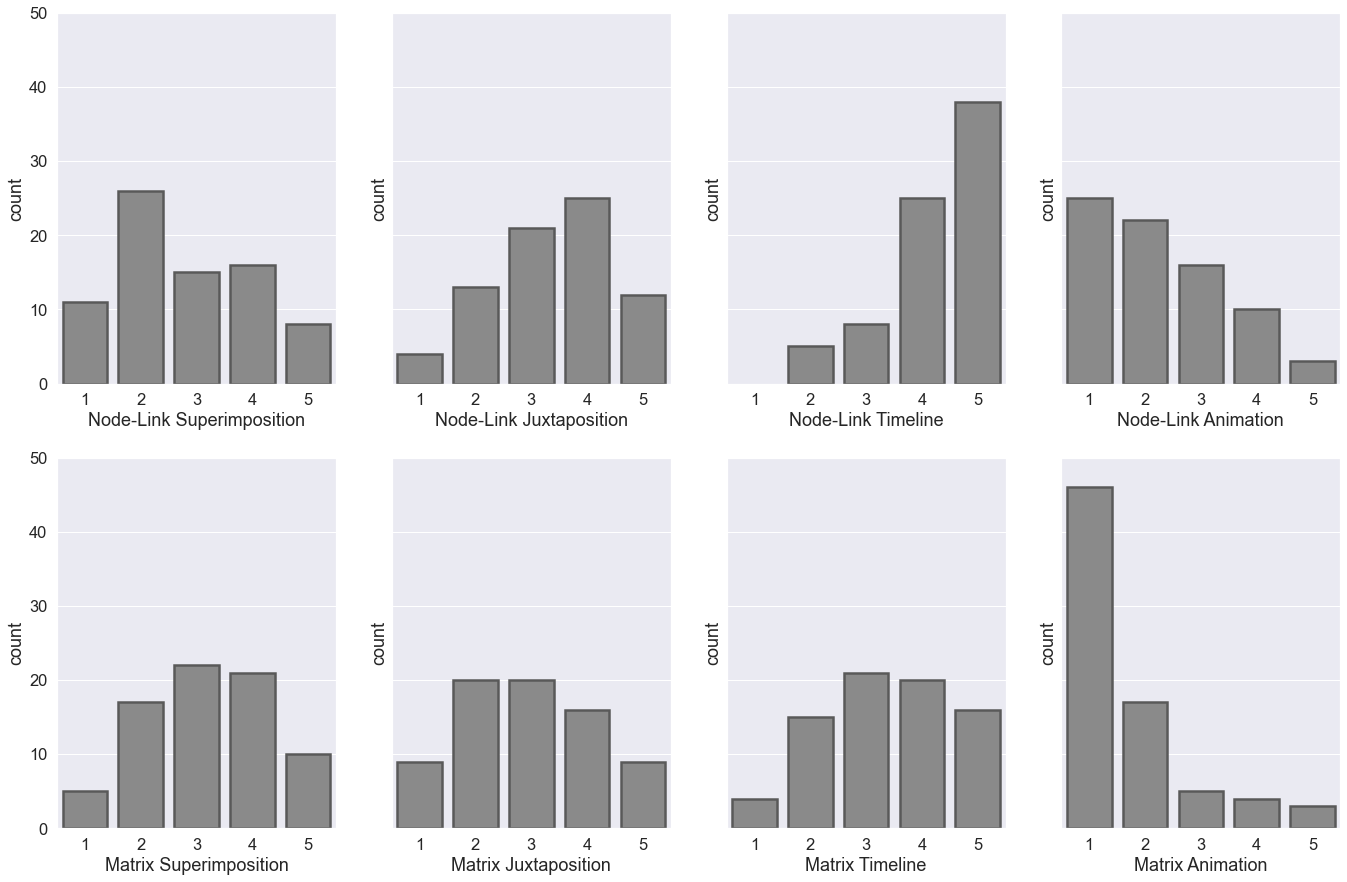

In [ ]:
# preferences - small multiples
sns.set_theme(style="darkgrid")
sns.set(font_scale = 1.5)
fig, axs = plt.subplots(2, 4, figsize=(23,15), sharex='none', sharey=True)

ylim = 50
axs[0, 0].set_ylim(0, ylim)
axs[0, 1].set_ylim(0, ylim)
axs[0, 2].set_ylim(0, ylim)
axs[0, 3].set_ylim(0, ylim)
axs[1, 0].set_ylim(0, ylim)
axs[1, 1].set_ylim(0, ylim)
axs[1, 2].set_ylim(0, ylim)
axs[1, 3].set_ylim(0, ylim)

# axs[0, 1].set_yticks([])
# axs[0, 2].set_yticks([])
# axs[0, 3].set_yticks([])
# axs[1, 1].set_yticks([])
# axs[1, 2].set_yticks([])
# axs[1, 3].set_yticks([])

# axs[0,1].set_title('Sharing Y axis')
# axs[0, 0].set_ylabel('Amount of Preferences')
# axs[0, 1].get_yaxis().set_visible(False)
# axs[0, 2].get_yaxis().set_visible(False)
# axs[0, 3].get_yaxis().set_visible(False)
# axs[1, 1].get_yaxis().set_visible(False)
# axs[1, 2].get_yaxis().set_visible(False)
# axs[1, 3].get_yaxis().set_visible(False)

preferences_df = preferences_df.rename(columns={'NL-SI' : 'Node-Link Superimposition', 'NL-JP': 'Node-Link Juxtaposition', 'NL-TL': 'Node-Link Timeline', 'NL-AN': 'Node-Link Animation', 'M-SI': 'Matrix Superimposition', 'M-JP': 'Matrix Juxtaposition', 'M-TL': 'Matrix Timeline', 'M-AN': 'Matrix Animation'})

likert = [1,2,3,4,5]
sns.countplot(preferences_df['Node-Link Superimposition'], ax=axs[0,0], dodge=True, linewidth=2.5, edgecolor='#595959', palette=["#8a8a8a"], order=likert)
sns.set_theme(style="darkgrid")
sns.countplot(preferences_df['Node-Link Juxtaposition'], ax=axs[0,1], dodge=True, linewidth=2.5, edgecolor='#595959', palette=["#8a8a8a"], order=likert)
sns.countplot(preferences_df['Node-Link Timeline'], ax=axs[0,2], dodge=True, linewidth=2.5, edgecolor='#595959', palette=["#8a8a8a"], order=likert)
sns.countplot(preferences_df['Node-Link Animation'], ax=axs[0,3], dodge=True, linewidth=2.5, edgecolor='#595959', palette=["#8a8a8a"], order=likert)
sns.countplot(preferences_df['Matrix Superimposition'], ax=axs[1,0], dodge=True, linewidth=2.5, edgecolor='#595959', palette=["#8a8a8a"], order=likert)
sns.countplot(preferences_df['Matrix Juxtaposition'], ax=axs[1,1], dodge=True, linewidth=2.5, edgecolor='#595959', palette=["#8a8a8a"], order=likert)
sns.countplot(preferences_df['Matrix Timeline'], ax=axs[1,2], dodge=True, linewidth=2.5, edgecolor='#595959', palette=["#8a8a8a"], order=likert)
sns.countplot(preferences_df['Matrix Animation'], ax=axs[1,3], dodge=True, linewidth=2.5, edgecolor='#595959', palette=["#8a8a8a"], order=likert)
sns.set_theme(style="darkgrid")
# sns.distplot(preferences_df['NL-SI'], hist_kws=dict(edgecolor="#595959", linewidth=2.5, alpha=1), kde=False,  color='#8a8a8a', ax=axs[0,1], bins=5)    
# sns.distplot(preferences_df['NL-TL'], hist_kws=dict(edgecolor="#595959", linewidth=2.5, alpha=1), kde=False,  color='#8a8a8a', ax=axs[0,2], bins=5)    
# sns.distplot(preferences_df['NL-AN'], hist_kws=dict(edgecolor="#595959", linewidth=2.5, alpha=1), kde=False,  color='#8a8a8a', ax=axs[0,3], bins=5)    
# sns.distplot(preferences_df['M-SI'], hist_kws=dict(edgecolor="#595959", linewidth=2.5, alpha=1), kde=False,  color='#8a8a8a', ax=axs[1,0], bins=5)    
# sns.distplot(preferences_df['M-JP'], hist_kws=dict(edgecolor="#595959", linewidth=2.5, alpha=1), kde=False,  color='#8a8a8a', ax=axs[1,1], bins=5)    
# sns.distplot(preferences_df['M-TL'], hist_kws=dict(edgecolor="#595959", linewidth=2.5, alpha=1), kde=False,  color='#8a8a8a', ax=axs[1,2], bins=5)    
# sns.distplot(preferences_df['M-AN'], hist_kws=dict(edgecolor="#595959", linewidth=2.5, alpha=1), kde=False,  color='#8a8a8a', ax=axs[1,3], bins=5)    
